# **Electrochemical Biosensor Development for the Detection of Prostate Cancer Biomarkers Using Screen-Printed Electrodes and Machine Learning Approaches**

# **# Connecting Google Drive to Colab**

In this step, I am mounting my Google Drive so I can read files directly from the project folder. This will allow me to access the raw electrochemical data for SPE 12, SPE 14, and SPE 18.


In [211]:
# Importing the drive module from Google Colab
from google.colab import drive

# Mounting my Google Drive to access files
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **# Importing All Required Libraries**

In this section, I am importing the necessary Python libraries for my project. These will help me with tasks like data handling, mathematical operations, signal processing, regression analysis, PCA, and plotting.


In [212]:
# I import the os module to work with files and folders
import os

# I import pandas to read and handle tabular data like CSV or TXT files
import pandas as pd

# I import numpy to perform mathematical operations on arrays and numbers
import numpy as np

# I import matplotlib for visualizing voltage and current graphs
import matplotlib.pyplot as plt

# I import find_peaks to detect electrochemical signal peaks from current values
from scipy.signal import find_peaks
from scipy import signal
# I import LinearRegression to create calibration curves from peak values
from sklearn.linear_model import LinearRegression

# I import PCA to reduce the dimensionality of my current and voltage data
from sklearn.decomposition import PCA

# I import StandardScaler to normalize the data before applying PCA
from sklearn.preprocessing import StandardScaler

# I hide unnecessary warnings to keep the output clean while coding
import warnings
warnings.filterwarnings("ignore")
# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [213]:
import os
import pandas as pd

base_path = '/content/drive/MyDrive/Data prostate cancer 2'
concentration_map = {
    "00": 0, "01": 0.001, "02": 0.01,
    "03": 0.1, "04": 1, "05": 10
}

def load_electrode_data_verbose(electrode_name):
    data = {}
    folder_path = f"{base_path}/{electrode_name}"

    for code, conc in concentration_map.items():
        current_file = f"PSV_{code}_cv_current"
        voltage_file = f"PSV_{code}_cv_voltage"

        current_path = f"{folder_path}/{current_file}"
        voltage_path = f"{folder_path}/{voltage_file}"

        try:
            current_df = pd.read_csv(current_path, sep='\t', header=None, names=["time", "current"])
            voltage_df = pd.read_csv(voltage_path, sep='\t', header=None, names=["time", "voltage"])

            data[conc] = {
                "current": current_df,
                "voltage": voltage_df
            }
            print(f"Loaded {electrode_name} | Conc: {conc} μg/mL")

        except FileNotFoundError as e:
            print(f"Error loading {electrode_name} | Conc {conc}: {e}")

        except Exception as e:
            print(f"Unexpected error loading {electrode_name} | Conc {conc}: {e}")

    return data

electrodes = ["SPE 12", "SPE 14", "SPE 18"]
all_data = {}

for electrode in electrodes:
    all_data[electrode] = load_electrode_data_verbose(electrode)


Loaded SPE 12 | Conc: 0 μg/mL
Loaded SPE 12 | Conc: 0.001 μg/mL
Loaded SPE 12 | Conc: 0.01 μg/mL
Loaded SPE 12 | Conc: 0.1 μg/mL
Loaded SPE 12 | Conc: 1 μg/mL
Loaded SPE 12 | Conc: 10 μg/mL
Loaded SPE 14 | Conc: 0 μg/mL
Loaded SPE 14 | Conc: 0.001 μg/mL
Loaded SPE 14 | Conc: 0.01 μg/mL
Loaded SPE 14 | Conc: 0.1 μg/mL
Loaded SPE 14 | Conc: 1 μg/mL
Loaded SPE 14 | Conc: 10 μg/mL
Loaded SPE 18 | Conc: 0 μg/mL
Loaded SPE 18 | Conc: 0.001 μg/mL
Loaded SPE 18 | Conc: 0.01 μg/mL
Error loading SPE 18 | Conc 0.1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data prostate cancer 2/SPE 18/PSV_03_cv_current'
Error loading SPE 18 | Conc 1: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data prostate cancer 2/SPE 18/PSV_04_cv_current'
Error loading SPE 18 | Conc 10: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data prostate cancer 2/SPE 18/PSV_05_cv_current'


# **# Cleaning Signal Data**

I define a function to clean the signal data by removing missing values and filtering outliers using the interquartile range (IQR) method.

In [214]:
# Define a function to clean a signal column in a DataFrame
def clean_signal(df, value_col):
    # Remove missing values and reset index
    df = df.dropna().reset_index(drop=True)

    # Convert the signal column to numeric, coercing errors to NaN
    df[value_col] = pd.to_numeric(df[value_col], errors="coerce")

    # Drop rows with NaN again after conversion and reset index
    df = df.dropna().reset_index(drop=True)

    # Calculate first and third quartiles
    Q1 = df[value_col].quantile(0.25)
    Q3 = df[value_col].quantile(0.75)

    # Calculate interquartile range (IQR)
    IQR = Q3 - Q1

    # Determine lower and upper bounds for filtering outliers
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Keep only data within the bounds
    df = df[(df[value_col] >= lower) & (df[value_col] <= upper)]

    # Reset index before returning cleaned DataFrame
    return df.reset_index(drop=True)

# Confirmation that function is defined
print("Signal cleaning function defined.")

Signal cleaning function defined.


# **# Cleaning and Filtering Data**

I clean the current and voltage signals for each electrode and concentration using the cleaning function.  
Then, I filter the data to keep only the time window between 2 and 12 seconds.


In [215]:
# Create a dictionary to store filtered data
filtered_data = {}

# Loop through each electrode
for electrode in electrodes:
    filtered_data[electrode] = {}

    # Loop through each concentration and its data for the electrode
    for conc, data in all_data[electrode].items():

        # Clean current and voltage signals using the cleaning function
        curr_df = clean_signal(data["current"], "current")
        volt_df = clean_signal(data["voltage"], "voltage")

        # Filter current and voltage data to keep time between 2 and 12 seconds
        curr_df_filtered = curr_df[(curr_df["time"] >= 2) & (curr_df["time"] <= 12)].reset_index(drop=True)
        volt_df_filtered = volt_df[(volt_df["time"] >= 2) & (volt_df["time"] <= 12)].reset_index(drop=True)

        # Store the filtered data back in the dictionary
        filtered_data[electrode][conc] = {
            "current": curr_df_filtered,
            "voltage": volt_df_filtered
        }

        print(f"Filtered {electrode} | Conc: {conc} μg/mL")

Filtered SPE 12 | Conc: 0 μg/mL
Filtered SPE 12 | Conc: 0.001 μg/mL
Filtered SPE 12 | Conc: 0.01 μg/mL
Filtered SPE 12 | Conc: 0.1 μg/mL
Filtered SPE 12 | Conc: 1 μg/mL
Filtered SPE 12 | Conc: 10 μg/mL
Filtered SPE 14 | Conc: 0 μg/mL
Filtered SPE 14 | Conc: 0.001 μg/mL
Filtered SPE 14 | Conc: 0.01 μg/mL
Filtered SPE 14 | Conc: 0.1 μg/mL
Filtered SPE 14 | Conc: 1 μg/mL
Filtered SPE 14 | Conc: 10 μg/mL
Filtered SPE 18 | Conc: 0 μg/mL
Filtered SPE 18 | Conc: 0.001 μg/mL
Filtered SPE 18 | Conc: 0.01 μg/mL


# **# Feature Extraction**

I extract statistical features from the cleaned current data of each electrode and concentration.  
The features include mean, standard deviation, maximum current, and the time at maximum current.  
These features and their corresponding concentration labels are stored in a DataFrame for modeling.

In [216]:
# Initialize empty lists to store features and labels
features = []
labels = []

# Loop through filtered data for each electrode and concentration
for electrode in filtered_data:
    for conc, data in filtered_data[electrode].items():
        current_df = data["current"]

        # Skip if current DataFrame is empty
        if current_df.empty:
            print(f"Skipping feature extraction for {electrode} | Conc: {conc} due to empty data.")
            continue

        # Subtract baseline from current signal
        baseline = current_df[current_df["time"] < (current_df["time"].min() + 0.5)]["current"].mean()
        current_df["current"] = current_df["current"] - baseline

        # Calculate statistical features
        mean_current = np.mean(current_df["current"])
        std_current = np.std(current_df["current"])
        max_current = np.max(current_df["current"])
        time_at_max = current_df["time"].iloc[np.argmax(current_df["current"])]

        # Calculate Faradaic charge (area under curve)
        time = current_df["time"].values
        current = current_df["current"].values
        charge = np.trapz(current, time)

        # Append features and label
        features.append([mean_current, std_current, max_current, time_at_max, charge])
        labels.append(conc)  # Concentration used as label

# Create a DataFrame with extracted features and labels
feature_names = ["mean_current", "std_current", "max_current", "time_at_max", "charge"]
df_features = pd.DataFrame(features, columns=feature_names)
df_features["label"] = labels

# Display the first few rows of the feature DataFrame
display(df_features.head())


mean_current  std_current  max_current  time_at_max    charge  label
0     -0.000002     0.000073     0.000102     11.88319 -0.000024  0.000
1     -0.000004     0.000128     0.000195     11.67124 -0.000043  0.001
2     -0.000005     0.000140     0.000214     11.67263 -0.000046  0.010
3     -0.000005     0.000144     0.000219     10.83251 -0.000047  0.100
4     -0.000005     0.000151     0.000229     10.72914 -0.000049  1.000

# **### Filtered Data Overview**

- **Electrode:** SPE 12  
- **Concentration:** 0.1 µg/mL  

In [217]:
def filter_time_range(df, time_col, value_col, start=2.0, end=12.0):
    """Filter DataFrame to keep only data between start and end time based on time_col."""
    # Ensure time_col is numeric and handle potential errors
    df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
    # Drop rows where time could not be converted to numeric
    df = df.dropna(subset=[time_col]).reset_index(drop=True)
    # Filter rows based on the time range
    return df[(df[time_col] >= start) & (df[time_col] <= end)].reset_index(drop=True)

# This cell demonstrates usage of filter_time_range, but the data is already filtered
electrode = 'SPE 12'
# Convert concentration string to float to match keys in filtered_data
concentration = 0.1

# Access the DataFrame from filtered_data
current_df = filtered_data[electrode][concentration]['current']
voltage_df = filtered_data[electrode][concentration]['voltage']

# filtered_current_df = filter_time_range(current_df.copy(), 'time', 'current', 2.0, 12.0)
# filtered_voltage_df = filter_time_range(voltage_df.copy(), 'time', 'voltage', 2.0, 12.0)

# To show the content of the data used:
print(f"Data for {electrode} | Conc: {concentration} µg/mL")
print("Filtered Current DataFrame head:")
display(current_df.head())
print("\nFiltered Voltage DataFrame head:")
display(voltage_df.head())

Data for SPE 12 | Conc: 0.1 µg/mL
Filtered Current DataFrame head:


time   current
0  2.000000  0.000015
1  2.000026  0.000015
2  2.000051  0.000015
3  2.000077  0.000016
4  2.000102  0.000016


Filtered Voltage DataFrame head:


time   voltage
0  2.000000 -0.464193
1  2.000026 -0.464097
2  2.000051 -0.463867
3  2.000077 -0.463634
4  2.000102 -0.463461

# **### Current and Potential vs Time Plot**

- Shows data for the first electrode and first concentration from `all_data`.
- **Left Plot:** Current (A) vs Time (s)
  - Shows how current changes over time.
- **Right Plot:** Potential (V) vs Time (s)
  - Shows how voltage changes over time.
- Helps analyze electrochemical behavior.


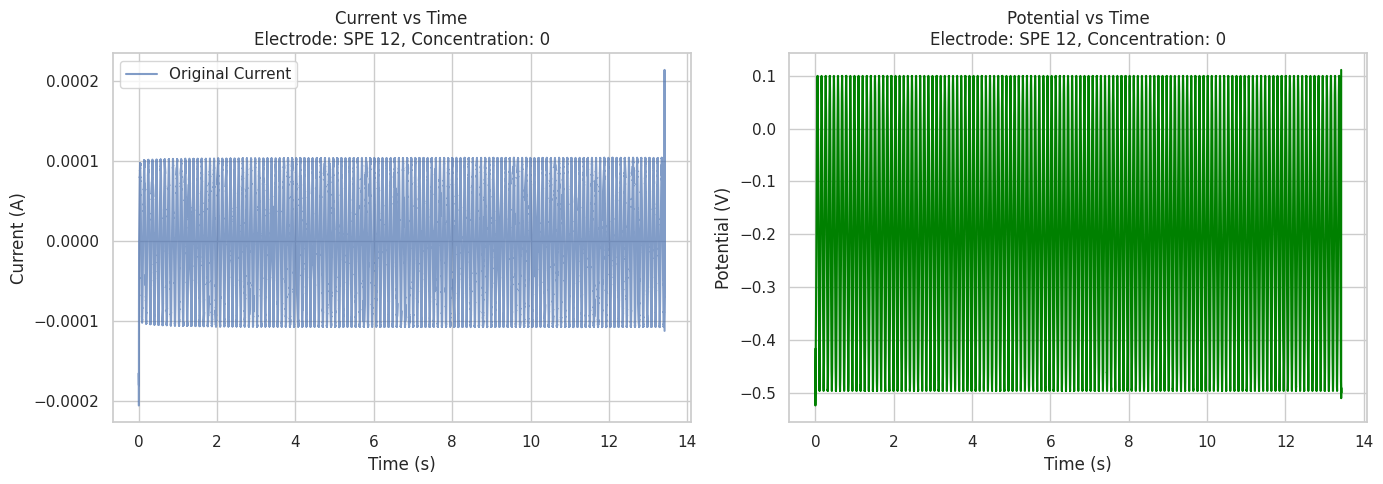

In [218]:
# Select the first electrode and concentration for visualization
electrode = list(all_data.keys())[0]
conc = list(all_data[electrode].keys())[0]

# Create a figure with 2 side-by-side plots
plt.figure(figsize=(14, 5))

# Plot original current vs time in the first subplot
plt.subplot(1, 2, 1)
plt.plot(all_data[electrode][conc]['current']['time'], all_data[electrode][conc]['current']['current'], label='Original Current', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title(f'Current vs Time\nElectrode: {electrode}, Concentration: {conc}')
plt.legend()
plt.grid(True)

# Plot potential (voltage) vs time in the second subplot
plt.subplot(1, 2, 2)
plt.plot(all_data[electrode][conc]['voltage']['time'], all_data[electrode][conc]['voltage']['voltage'], color='green')
plt.xlabel('Time (s)')
plt.ylabel('Potential (V)')
plt.title(f'Potential vs Time\nElectrode: {electrode}, Concentration: {conc}')
plt.grid(True)


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# **# Plot Current and Voltage Signals for All Electrodes and Concentrations**

I plot side-by-side graphs showing current vs time and voltage vs time  
for all electrodes and concentrations using the filtered data.

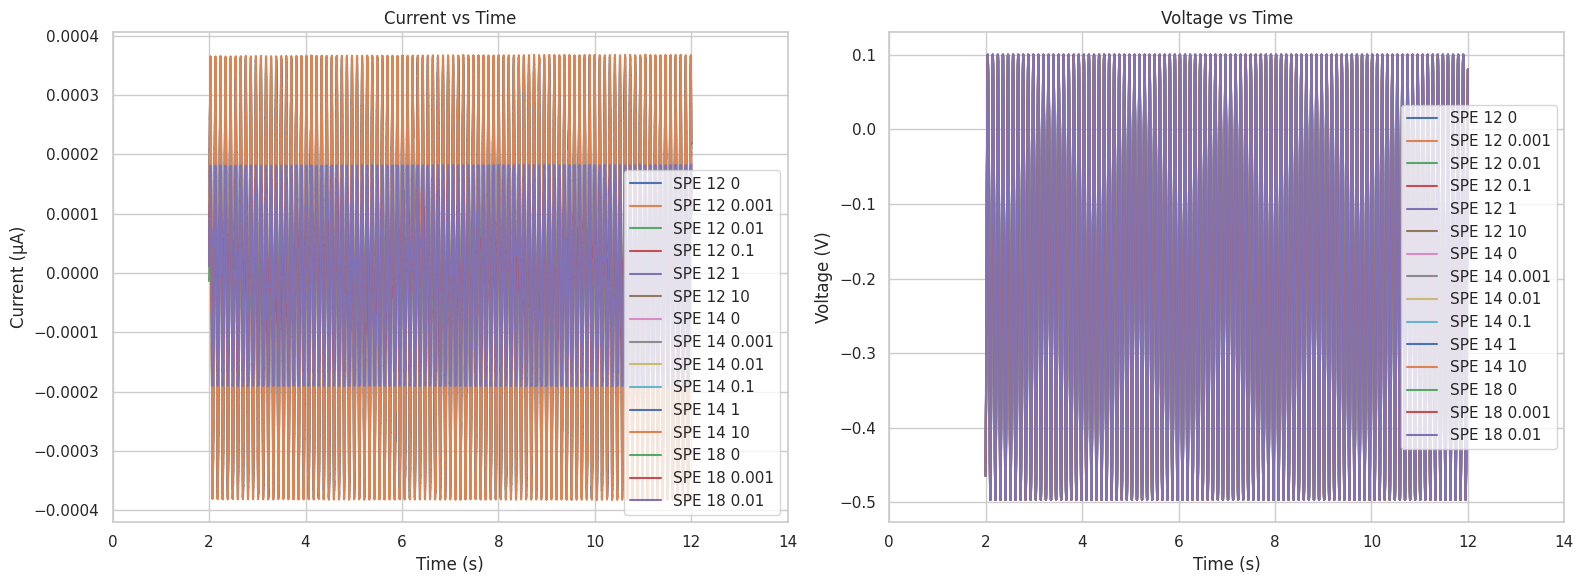

In [219]:
# Create side-by-side subplots for current and voltage
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Plot current vs time on the left subplot
for electrode in filtered_data:
    for conc in filtered_data[electrode]:
        data = filtered_data[electrode][conc]
        axes[0].plot(
            data["current"]["time"],
            data["current"]["current"],
            label=f"{electrode} {conc}"
        )

# Set limits, labels, title, legend, and grid for current plot
axes[0].set_xlim(0, 14)
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Current (µA)")
axes[0].set_title("Current vs Time")
axes[0].legend()
axes[0].grid(True)

# Plot voltage vs time on the right subplot
for electrode in filtered_data:
    for conc in filtered_data[electrode]:
        data = filtered_data[electrode][conc]
        axes[1].plot(
            data["voltage"]["time"],
            data["voltage"]["voltage"],
            label=f"{electrode} {conc}"
        )

# Set limits, labels, title, legend, and grid for voltage plot
axes[1].set_xlim(0, 14)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Voltage (V)")
axes[1].set_title("Voltage vs Time")
axes[1].legend()
axes[1].grid(True)

# Adjust layout for better spacing and display the plots
plt.tight_layout()
plt.show()

# **### Side-by-Side CV Curve Comparison Across Electrodes**

I am now plotting the cyclic voltammetry (CV) curves for SPE 12, SPE 14, and SPE 18 side by side. Each subplot shows the raw CV data across all concentrations for one electrode. This helps me visually compare the electrochemical response of Galectin-3 detection across different electrodes.


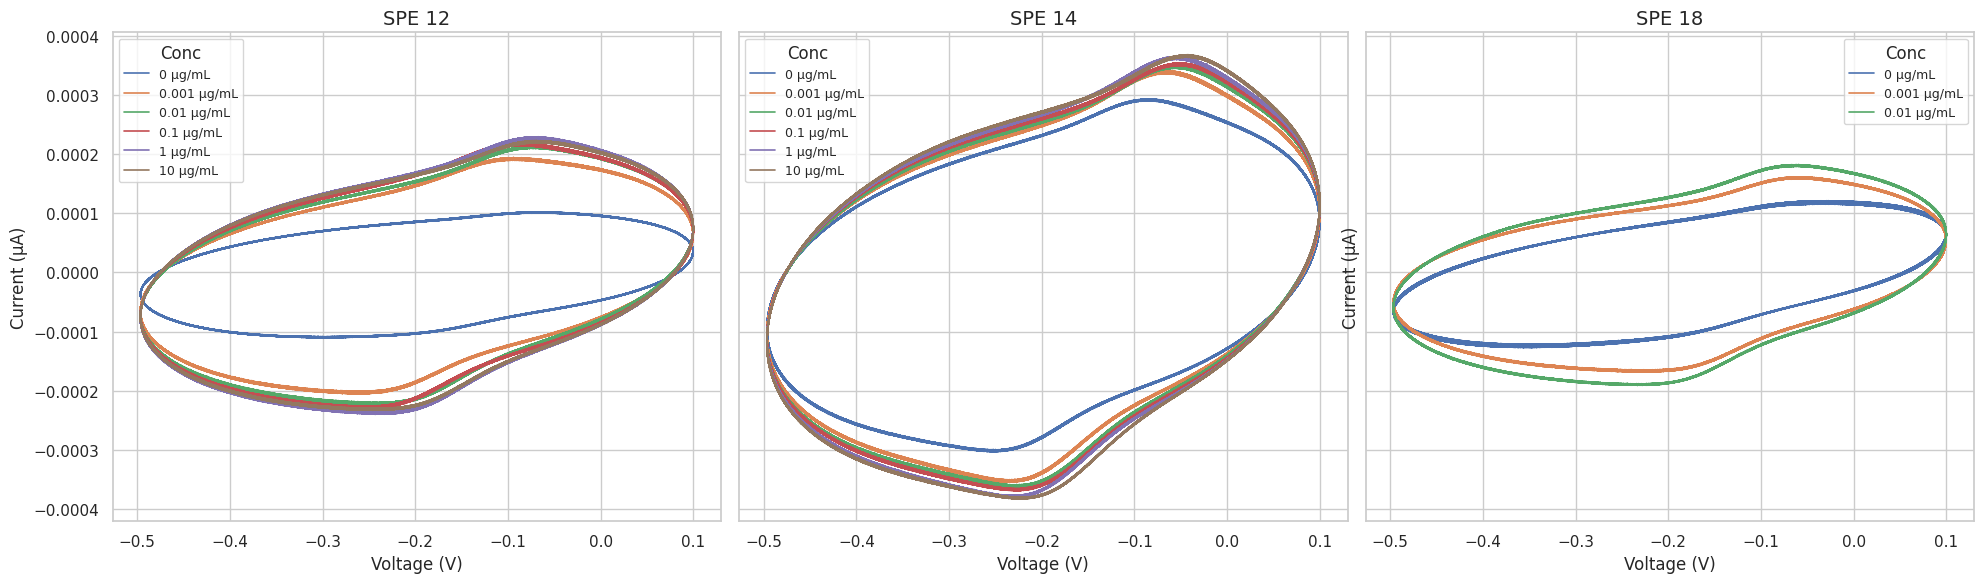

In [220]:
# I define the electrodes I want to compare
electrodes = ["SPE 12", "SPE 14", "SPE 18"]

# I create a figure with 3 side-by-side subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

# I loop through each electrode and subplot index
for i, electrode in enumerate(electrodes):

    # I skip if this electrode has no data
    if electrode not in filtered_data or not filtered_data[electrode]:
        continue

    # I get the subplot axis
    ax = axs[i]

    # I loop through each concentration for this electrode
    for conc, data in sorted(filtered_data[electrode].items()):

        # I extract voltage and current arrays
        voltage = np.array(data["voltage"]["voltage"])
        current = np.array(data["current"]["current"])

        # I plot CV curve
        ax.plot(voltage, current, label=f"{conc} µg/mL", linewidth=1.2)

    # I set axis labels and titles
    ax.set_title(f"{electrode}", fontsize=14)
    ax.set_xlabel("Voltage (V)")
    if i == 0:
        ax.set_ylabel("Current (µA)")
    ax.grid(True)
    ax.legend(title="Conc", fontsize=9)

# I adjust layout and display the plot
plt.tight_layout()
plt.xlabel("Voltage (V)")
plt.ylabel("Current (µA)")

plt.show()


# **### CV Curves at 0.01 µg/mL for SPE 12, 14, and 18 Electrodes**

In this step, I plotted the cyclic voltammetry (CV) curves for all electrodes that have data available at 0.01 µg/mL concentration. This helps me visually compare the electrochemical behavior of different electrodes under the same low-concentration condition.

For each electrode, I extracted the voltage and current data from the filtered dataset and plotted them on the same graph. This comparison allows me to observe variations in current response and shape of the CV curve across electrodes at this specific concentration.

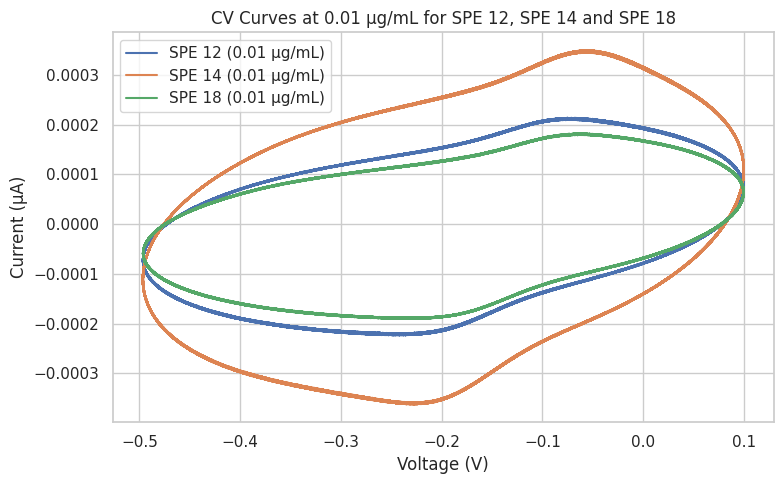

In [221]:
# Set the target concentration to 0.01 µg/mL
target_conc = 0.01

# Define only the electrodes to include (SPE 12 and SPE 14)
electrodes_to_plot = ["SPE 12", "SPE 14", "SPE 18"]

# Create a figure for plotting
plt.figure(figsize=(8, 5))

# Loop through selected electrodes
for electrode in electrodes_to_plot:
    # Check if this electrode has data at 0.01 µg/mL
    if electrode in filtered_data and target_conc in filtered_data[electrode]:
        data = filtered_data[electrode][target_conc]

        # Ensure both current and voltage data are available and not empty
        if 'current' in data and 'voltage' in data and not data['current'].empty and not data['voltage'].empty:
            # Extract current and voltage values
            current = data['current']['current']
            voltage = data['voltage']['voltage']

            # Ensure same length for plotting
            min_len = min(len(current), len(voltage))
            current = current[:min_len]
            voltage = voltage[:min_len]

            # Plot the CV curve
            plt.plot(voltage, current, label=f"{electrode} ({target_conc} µg/mL)")
        else:
            print(f"Data missing or empty for {electrode} at {target_conc} µg/mL.")
    else:
        print(f"{electrode} does not have data for {target_conc} µg/mL.")

# Add title and labels
plt.title(f'CV Curves at {target_conc} µg/mL for SPE 12, SPE 14 and SPE 18')
plt.xlabel('Voltage (V)')
plt.ylabel('Current (µA)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **# Plot Cyclic Voltammetry Curves**

I plot current vs voltage curves (CV curves) for all electrodes and concentrations  
to visualize the electrochemical behavior across samples.

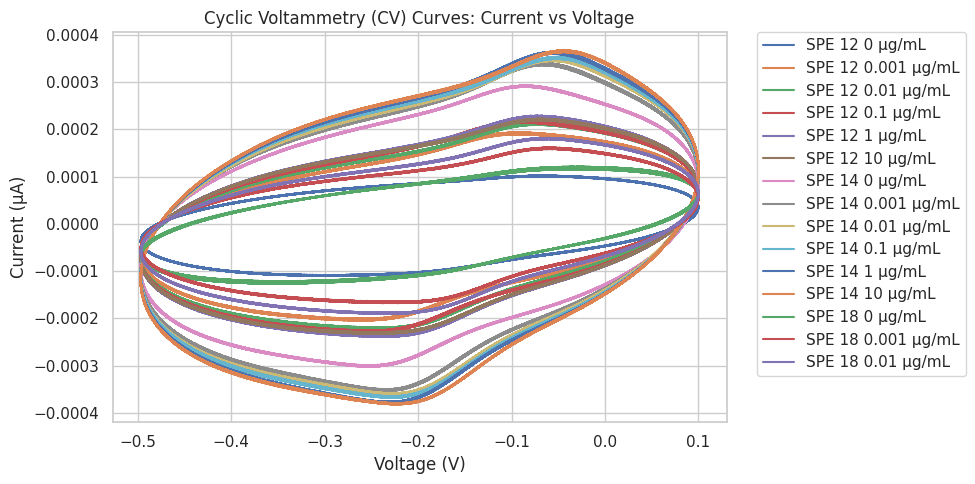

In [222]:
# Create figure for CV curves (Current vs Voltage)
plt.figure(figsize=(10, 5))

# Plot CV curve for each electrode and concentration
for electrode in filtered_data:
    for conc in filtered_data[electrode]:
        data = filtered_data[electrode][conc]
        current = data["current"]["current"]
        voltage = data["voltage"]["voltage"]
        plt.plot(voltage, current, label=f"{electrode} {conc} µg/mL")

# Set labels, title, and grid
plt.xlabel("Voltage (V)")
plt.ylabel("Current (µA)")
plt.title("Cyclic Voltammetry (CV) Curves: Current vs Voltage")
plt.grid(True)

# Place legend outside the plot
plt.legend(
    bbox_to_anchor=(1.05, 1),  # x=1.05 (outside right), y=1 (top aligned)
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout()
plt.show()

# **### CV Comparison of Selected Electrodes**

I plotted raw current vs. voltage for `SPE 12`, `SPE 14`, and `SPE 18`. For each, I used the first available concentration and skipped if data was missing. All plots are shown side-by-side.


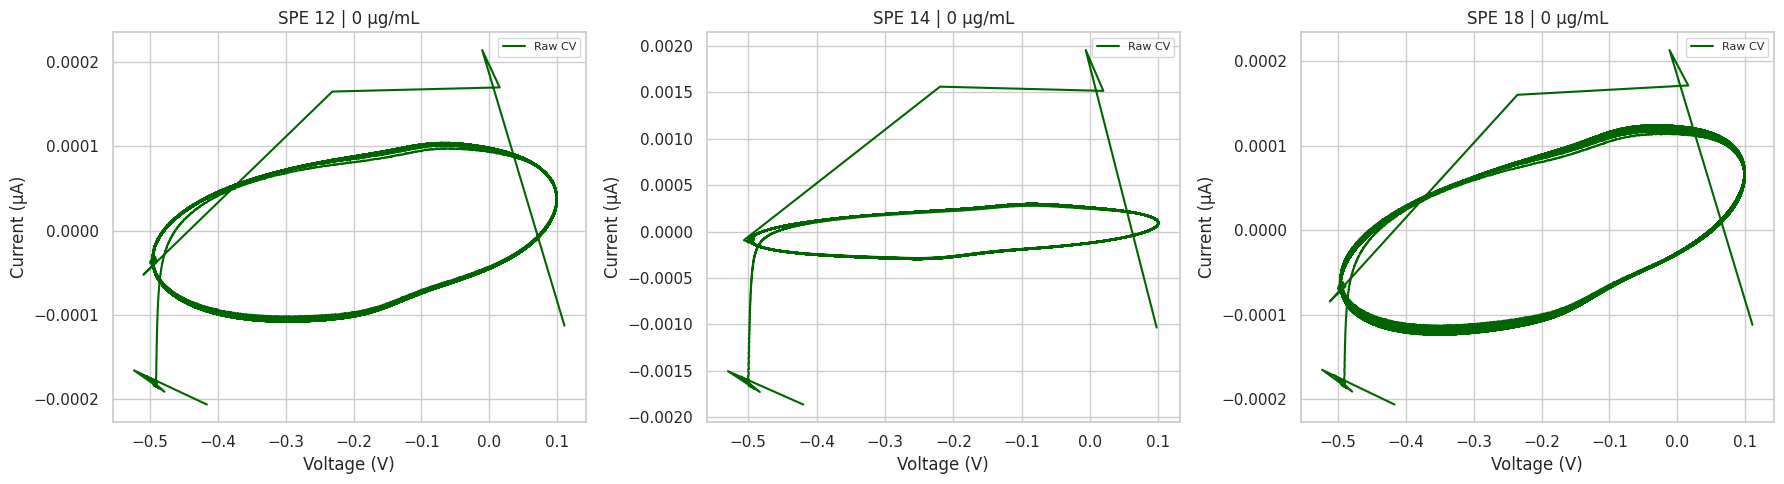

In [223]:
# I select the electrodes I want to compare
electrodes_to_plot = ["SPE 12", "SPE 14", "SPE 18"]

# I create a wide figure with 3 side-by-side plots
plt.figure(figsize=(18, 5))

# I loop through each electrode to plot its data
for i, electrode in enumerate(electrodes_to_plot):
    # I skip this electrode if no data is available
    if electrode not in all_data or not all_data[electrode]:
        continue

    # I pick the first available concentration for this electrode
    conc = list(all_data[electrode].keys())[0]
    data = all_data[electrode][conc]

    # I skip if either current or voltage data is missing
    if data["voltage"]["voltage"].empty or data["current"]["current"].empty:
        continue

    # I extract current and voltage arrays from the DataFrames
    voltage = np.array(data["voltage"]["voltage"])
    current = np.array(data["current"]["current"])

    # I plot the raw current vs. voltage
    plt.subplot(1, 3, i + 1)
    plt.plot(voltage, current, label="Raw CV", color='darkgreen')
    plt.title(f"{electrode} | {conc} µg/mL", fontsize=12)
    plt.xlabel("Voltage (V)")
    plt.ylabel("Current (µA)")
    plt.grid(True)
    plt.legend(fontsize=8)

# I apply tight layout and show the full plot
plt.tight_layout()
plt.show()


# **### Raw CV Curve with Peak Detection for Selected Electrodes**

I plotted the raw cyclic voltammetry (CV) curves for SPE 12 and SPE 14 at the lowest available concentration.  
I also detected and highlighted the strongest oxidation and reduction peaks using signal peak detection.  
This helps me visually verify the electrochemical activity and peak positions for each electrode.


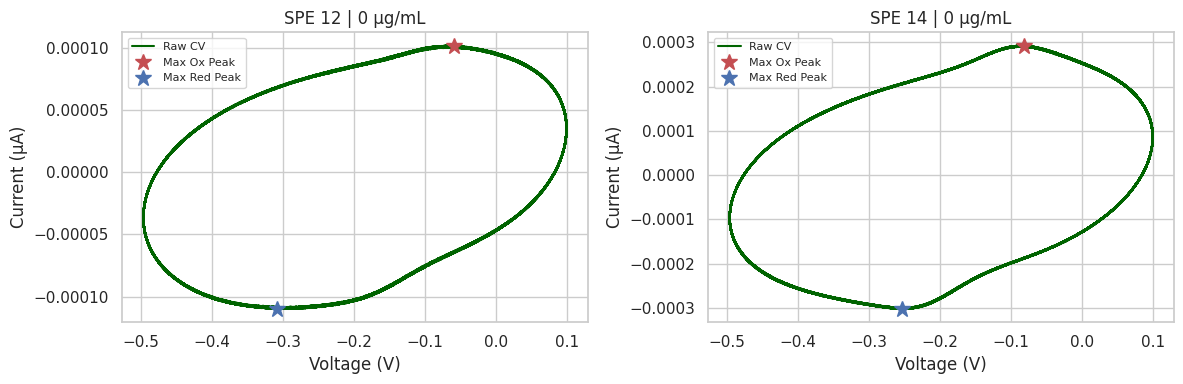

In [224]:
# List of electrodes to visualize
electrodes_to_plot = ["SPE 12", "SPE 14"]

# Create a wide plot with 2 subplots
plt.figure(figsize=(12, 4))

# Loop through each electrode
for i, electrode in enumerate(electrodes_to_plot):
    if electrode not in filtered_data or electrode not in all_data:
        print(f"Electrode {electrode} data missing. Skipping.")
        continue

    # Use the first available concentration
    if not filtered_data[electrode]:
        print(f"No concentrations found for electrode {electrode}. Skipping.")
        continue

    conc = list(filtered_data[electrode].keys())[0]

    # Load raw (unfiltered) data
    raw_data = filtered_data[electrode][conc]
    voltage = raw_data["voltage"]["voltage"].values
    current = raw_data["current"]["current"].values

    # Find oxidation and reduction peaks from raw data
    peaks, _ = signal.find_peaks(current)
    valleys, _ = signal.find_peaks(-current)

    # Get strongest oxidation and reduction peak
    ox_voltage = red_voltage = ox_current = red_current = np.nan
    if len(peaks) > 0:
        ox_idx = peaks[np.argmax(current[peaks])]
        ox_voltage = voltage[ox_idx]
        ox_current = current[ox_idx]
    if len(valleys) > 0:
        red_idx = valleys[np.argmax(-current[valleys])]
        red_voltage = voltage[red_idx]
        red_current = current[red_idx]

    # Plot raw CV
    plt.subplot(1, 2, i + 1)
    plt.plot(voltage, current, label="Raw CV", color='darkgreen')

    # Highlight strongest peaks
    if not np.isnan(ox_voltage):
        plt.plot(ox_voltage, ox_current, 'r*', markersize=12, label="Max Ox Peak")
    if not np.isnan(red_voltage):
        plt.plot(red_voltage, red_current, 'b*', markersize=12, label="Max Red Peak")


    plt.title(f"{electrode} | {conc} µg/mL", fontsize=12)
    plt.xlabel("Voltage (V)")
    plt.ylabel("Current (µA)")
    plt.grid(True)
    plt.legend(fontsize=8)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# **### Raw CV with Peaks (SPE 12 | 0 µg/mL)**

I plotted the raw CV data for SPE 12 at 0 µg/mL and used `find_peaks` to detect Faradaic peaks. The peaks are marked with red 'x' to highlight possible redox activity.


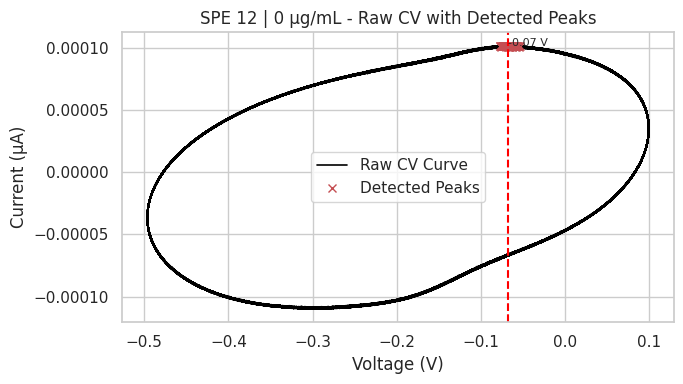

In [225]:
# Load raw CV data for SPE 12 at 0 µg/mL concentration
data = filtered_data["SPE 12"][0]
voltage = np.array(data["voltage"]["voltage"])
current = np.array(data["current"]["current"])

# Detect peaks in the raw current (Faradaic peaks)
peaks, _ = find_peaks(current, prominence=0.00005)

# Plot the raw CV curve
plt.figure(figsize=(7, 4))
plt.plot(voltage, current, color="black", linewidth=1.2, label="Raw CV Curve")

# Mark the detected Faradaic peaks
plt.plot(voltage[peaks], current[peaks], 'rx', label="Detected Peaks")

# Plot vertical line and text annotation only if peaks are found
if len(peaks) > 0:
    # Get the voltage and current of the first detected peak
    peak_voltage = voltage[peaks[0]]
    peak_current = current[peaks[0]]
    plt.axvline(x=peak_voltage, color='red', linestyle='--')
    plt.text(peak_voltage, peak_current, f"{peak_voltage:.2f} V", fontsize=8)


# Add plot labels, legend, and grid
plt.title("SPE 12 | 0 µg/mL - Raw CV with Detected Peaks")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (µA)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# **### FFT of Raw Current**
In this section, I applied Fast Fourier Transform (FFT) to the raw current data of each available electrode for the first concentration (typically 0 µg/mL).



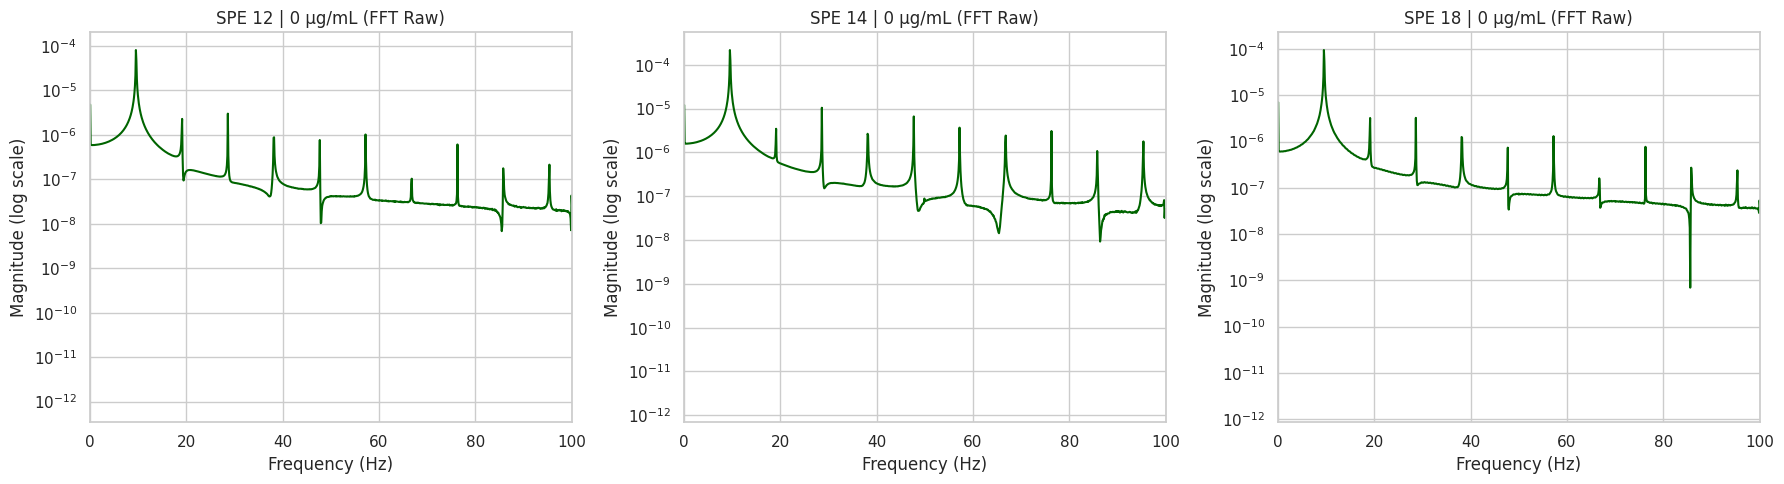

In [226]:
# I import the required FFT tools from SciPy
from scipy.fft import fft, fftfreq

# I prepare the plot layout with 3 subplots for 3 electrodes
plt.figure(figsize=(18, 5))

# I get all available electrodes from my filtered data
available_electrodes = list(filtered_data.keys())

# I loop through each electrode to calculate and plot FFT
for i, electrode in enumerate(available_electrodes):

    plt.subplot(1, len(available_electrodes), i + 1)

    # I check if this electrode has any data
    if not filtered_data[electrode]:
        print(f" No data for {electrode}. Skipping.")
        plt.title(f"{electrode} | No Data")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid(True)
        continue

    # I select the first concentration available (usually 0 µg/mL)
    conc = list(filtered_data[electrode].keys())[0]
    data = filtered_data[electrode][conc]

    # I extract time and raw current signals
    try:
        time = data["current"]["time"].values
        current = data["current"]["current"].values
    except KeyError:
        print(f" Missing 'time' or 'current' column in {electrode} | Conc: {conc}. Skipping.")
        continue

    # I check if data length is sufficient for FFT
    if len(time) < 5 or len(current) < 5:
        print(f" Not enough data for FFT for {electrode} | Conc: {conc}. Skipping.")
        continue

    # I calculate time interval (dt) and number of points (N)
    dt = np.mean(np.diff(time))
    N = len(current)

    # I perform FFT on the raw current signal
    yf = fft(current)
    xf = fftfreq(N, dt)[:N//2]  # I keep only positive frequencies
    magnitude = 2.0 / N * np.abs(yf[:N//2])  # Normalized magnitude

    # I plot the FFT magnitude vs frequency
    plt.plot(xf, magnitude, color='darkgreen')
    plt.title(f"{electrode} | {conc} µg/mL (FFT Raw)", fontsize=12)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (log scale)")

    plt.xlim(0, 100)
    plt.yscale("log")
    plt.grid(True)

# I adjust layout and display the figure
plt.tight_layout()
plt.show()


# **### FFT Peak Plot (9–10 Hz)**
**Purpose:** Transform the current–time signal into the frequency domain and highlight the **dominant peak** for each sample (SPE 12, SPE 14, SPE 18 across concentrations).

**Method Overview:**
- Compute the sampling interval (`dt`) and use `fftfreq(N, dt)` to obtain true frequencies in Hz.  
- Restrict to the positive spectrum and scale amplitudes as `magnitude = (2/N) * |FFT|` for fair comparison across runs.  
- Identify the strongest spectral component with `peak_idx = magnitude.argmax()`.  
- Mark the peak with a red dot and label for each electrode–concentration pair.  
- Focus on the **9–10 Hz window**, which consistently shows a meaningful system response.

**Why 9–10 Hz?**
- This band captures the fundamental frequency of the electrochemical signal.  
- It enhances the signal-to-noise ratio and reveals how **peak height** varies with analyte concentration.  

**Key Observation:**
- The dominant peak is consistently located at **9.500 Hz**.  
- This confirms frequency stability across electrodes and concentrations, while the **amplitude differences** carry analytical information about concentration effects.



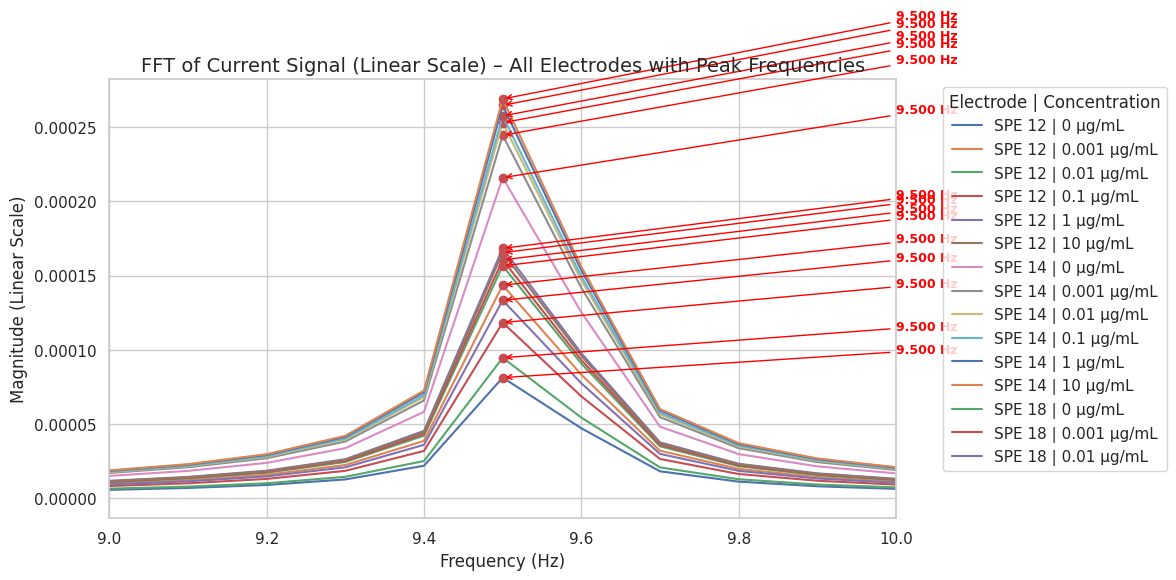

In [227]:
# I select the electrode to analyze
electrodes_to_analyze = ["SPE 12", "SPE 14", "SPE 18"]

# I create a new plot
plt.figure(figsize=(12, 6))

# I loop through each electrode to analyze and plot
for electrode in electrodes_to_analyze:
    # Check if the electrode exists in filtered_data
    if electrode not in filtered_data:
        print(f"Data for {electrode} not found. Skipping.")
        continue

    # I loop through all concentrations
    for conc in sorted(filtered_data[electrode].keys()):
        data = filtered_data[electrode][conc]
        time = data["current"]["time"].values
        current = data["current"]["current"].values

        if len(time) < 5 or len(current) < 5:
            continue

        dt = np.mean(np.diff(time))
        N = len(current)
        yf = fft(current)
        xf = fftfreq(N, dt)[:N // 2]
        magnitude = 2.0 / N * np.abs(yf[:N // 2])

        # Find peak frequency
        peak_idx = magnitude.argmax()
        peak_freq = xf[peak_idx]
        peak_val = magnitude[peak_idx]

        # Plot FFT curve
        plt.plot(xf, magnitude, label=f"{electrode} | {conc} µg/mL")

        # Plot red dot at peak
        plt.plot(peak_freq, peak_val, 'ro')

        # Annotate the peak slightly above the dot
        plt.annotate(
            f"{peak_freq:.3f} Hz",
            xy=(peak_freq, peak_val),
            xytext=(peak_freq + 0.5, peak_val * 1.2),  # Offset for visibility
            textcoords="data",
            arrowprops=dict(arrowstyle="->", color='red', lw=1),
            fontsize=9,
            color='red',
            weight='bold'
        )

# Final plot settings
plt.title("FFT of Current Signal (Linear Scale) – All Electrodes with Peak Frequencies", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Linear Scale)")
plt.xlim(9, 10)
plt.grid(True)
plt.legend(title="Electrode | Concentration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **### FFT Analysis with Peak Detection**

In this step, I analyze the current signal using the **Fast Fourier Transform (FFT)**.  
I want to see which frequency components are present in the signal between **11.5 Hz and 72.5 Hz**.  

  
- I compute the FFT using `rfft` and convert to magnitude spectrum.  
- I then **focus only on the zoom band (11.5–72.5 Hz)**, because that is where the main electrochemical activity is expected.  
- I use **adaptive prominence** to automatically tune the peak detection threshold, so only real peaks are selected.  
- If no peak is detected, I make sure at least one is chosen (the highest one).  
- I plot the FFT curve for each electrode and concentration, and I annotate the detected peaks with their frequency values.  

This allows me to clearly see the **dominant frequency components** in my electrochemical data and compare electrodes and concentrations in the same frequency band.


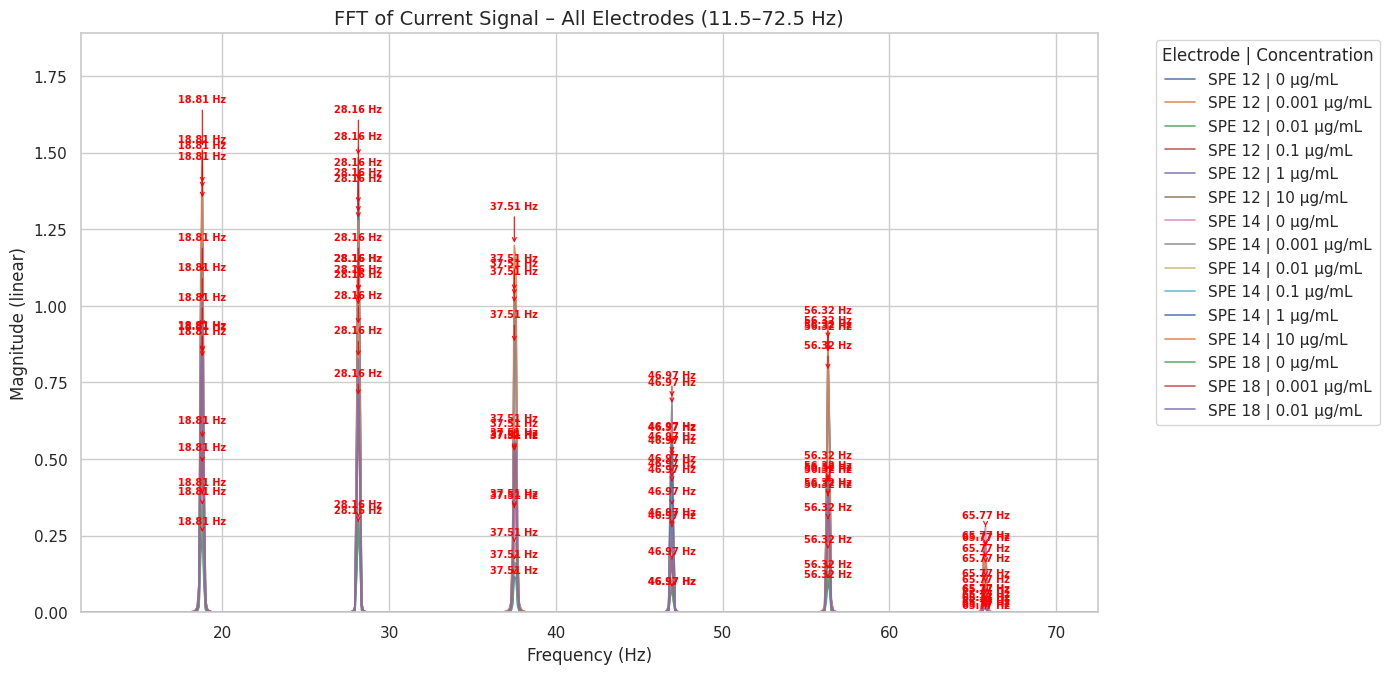

In [228]:
# I define the frequency zoom band
from scipy.fft import rfft, rfftfreq # Import rfft and rfftfreq
fmin, fmax = 11.5, 72.5
plt.figure(figsize=(14, 7))

global_max = 0.0  # I keep track of the highest peak for y-limit scaling

for electrode in electrodes_to_analyze:
    if electrode not in filtered_data:
        print(f"No data for {electrode}, skipping...")
        continue

    for conc in sorted(filtered_data[electrode].keys()):
        data = filtered_data[electrode][conc]
        t = data["current"]["time"].values
        x = data["current"]["current"].values

        # I check that the data is valid
        if t is None or x is None or len(t) < 8:
            continue
        mask = np.isfinite(t) & np.isfinite(x)
        t, x = t[mask], x[mask]
        if len(t) < 8:
            continue

        # I calculate the sampling interval
        dt = np.median(np.diff(t))
        if not np.isfinite(dt) or dt <= 0:
            continue

        # I remove the mean and apply a Hanning window
        x = x - np.mean(x)
        xw = x * np.hanning(len(x))

        # I calculate FFT
        X = rfft(xw)
        freqs = rfftfreq(len(x), d=dt)
        mag = np.abs(X)

        # I keep only the zoom band
        band = (freqs >= fmin) & (freqs <= fmax) & (freqs > 0)
        if not np.any(band):
            continue
        fz, mz = freqs[band], mag[band]

        # I update the global maximum for scaling
        if np.any(np.isfinite(mz)):
            global_max = max(global_max, float(np.nanmax(mz)))

        # I set adaptive prominence for peak detection
        if len(mz) >= 3:
            q1, q3 = np.percentile(mz, [25, 75])
            iqr = max(1e-12, q3 - q1)
            sigma = iqr / 1.349
            prom = max(3.0 * sigma, 0.02 * (np.max(mz) if np.max(mz) > 0 else 1e-12))
        else:
            prom = 0.0

        df = np.median(np.diff(fz))
        distance_bins = max(1, int(np.round(0.5 / max(df, 1e-12))))  # minimum spacing 0.5 Hz

        peaks, _ = find_peaks(mz, prominence=prom, distance=distance_bins)

        # I ensure at least one peak is present
        if len(peaks) == 0:
            peaks = np.array([int(np.argmax(mz))])

        # I plot the FFT spectrum
        plt.plot(fz, mz, label=f"{electrode} | {conc} µg/mL", lw=1.2, alpha=0.9)

        # I annotate the detected peaks
        for pk in peaks:
            plt.annotate(f"{fz[pk]:.2f} Hz",
                         xy=(fz[pk], mz[pk]),
                         xytext=(fz[pk], mz[pk] * 1.1),
                         ha="center",
                         arrowprops=dict(arrowstyle="->", color='red', lw=0.8),
                         fontsize=7, color='red', weight='bold')

# I add titles, labels, and grid
plt.title("FFT of Current Signal – All Electrodes (11.5–72.5 Hz)", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (linear)")
plt.grid(True)
plt.legend(title="Electrode | Concentration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# I adjust y-limit and x-limit for clear view
if global_max > 0:
    plt.ylim(0, global_max * 1.25)
plt.xlim(fmin, fmax)

plt.show()

# **###  FFT plot**

- **Purpose:** Convert current–time to **frequency** to spot the dominant oscillation per electrode/concentration.
- **Correct axes:** Use `dt` + `fftfreq` for **Hz**, and `(2/N)*|FFT|` so amplitudes are comparable.
- **Focus band:** Zoom to **18.5–19.5 Hz** because this band carries the stable feature in our setup → better SNR.
- **Peak pick (heuristic):** `peak_idx = magnitude.argmax()*2 + 1` targets the next strong lobe/harmonic instead of the raw global max (often affected by DC/leakage).



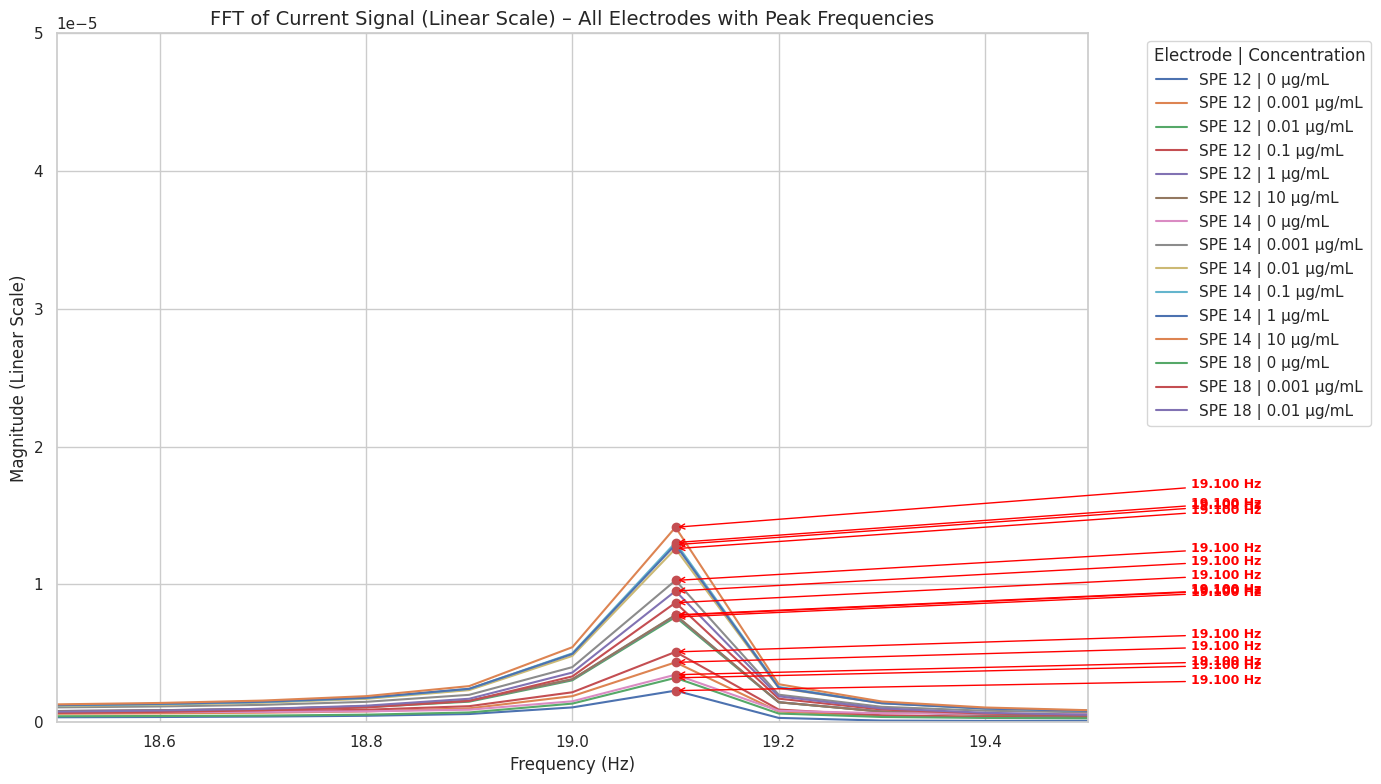

In [229]:
# I select the electrode to analyze
electrodes_to_analyze = ["SPE 12", "SPE 14", "SPE 18"]

# I create a new plot
plt.figure(figsize=(14, 8))

# I loop through each electrode to analyze and plot
for electrode in electrodes_to_analyze:
    # Check if the electrode exists in filtered_data
    if electrode not in filtered_data:
        print(f"Data for {electrode} not found. Skipping.")
        continue

    # I loop through all concentrations
    for conc in sorted(filtered_data[electrode].keys()):
        data = filtered_data[electrode][conc]
        time = data["current"]["time"].values
        current = data["current"]["current"].values

        if len(time) < 5 or len(current) < 5:
            continue

        dt = np.mean(np.diff(time))
        N = len(current)
        yf = fft(current)
        xf = fftfreq(N, dt)[:N // 2]
        magnitude = 2.0 / N * np.abs(yf[:N // 2])

        # Find peak frequency
        peak_idx = magnitude.argmax()*2+1
        peak_freq = xf[peak_idx]
        peak_val = magnitude[peak_idx]

        # Plot FFT curve
        plt.plot(xf, magnitude, label=f"{electrode} | {conc} µg/mL")

        # Plot red dot at peak
        plt.plot(peak_freq, peak_val, 'ro')

        # Annotate the peak slightly above the dot
        plt.annotate(
            f"{peak_freq:.3f} Hz",
            xy=(peak_freq, peak_val),
            xytext=(peak_freq + 0.5, peak_val * 1.2),  # Offset for visibility
            textcoords="data",
            arrowprops=dict(arrowstyle="->", color='red', lw=1),
            fontsize=9,
            color='red',
            weight='bold'
        )

# Final plot settings
plt.title("FFT of Current Signal (Linear Scale) – All Electrodes with Peak Frequencies", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Linear Scale)")
plt.xlim(18.5, 19.5)
plt.ylim(0, 0.00005)
plt.grid(True)
plt.legend(title="Electrode | Concentration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **### FFT Analysis of Current Signal Across Electrodes**

This plot shows the frequency-domain representation (FFT) of the current signal for all selected electrodes (SPE 12, SPE 14, and SPE 18) across different concentrations.  

- The **x-axis** represents frequency in Hz.  
- The **y-axis** shows the FFT magnitude on a linear scale.  
- Each curve corresponds to an electrode–concentration pair.  
- A **red dot marks the dominant frequency peak**, with its exact frequency annotated.  

The zoomed frequency window (15.5–46.5 Hz) highlights the harmonics and dominant peaks that characterize the electrochemical signal response. This visualization helps identify how the spectral signature changes with both electrode type and analyte concentration.


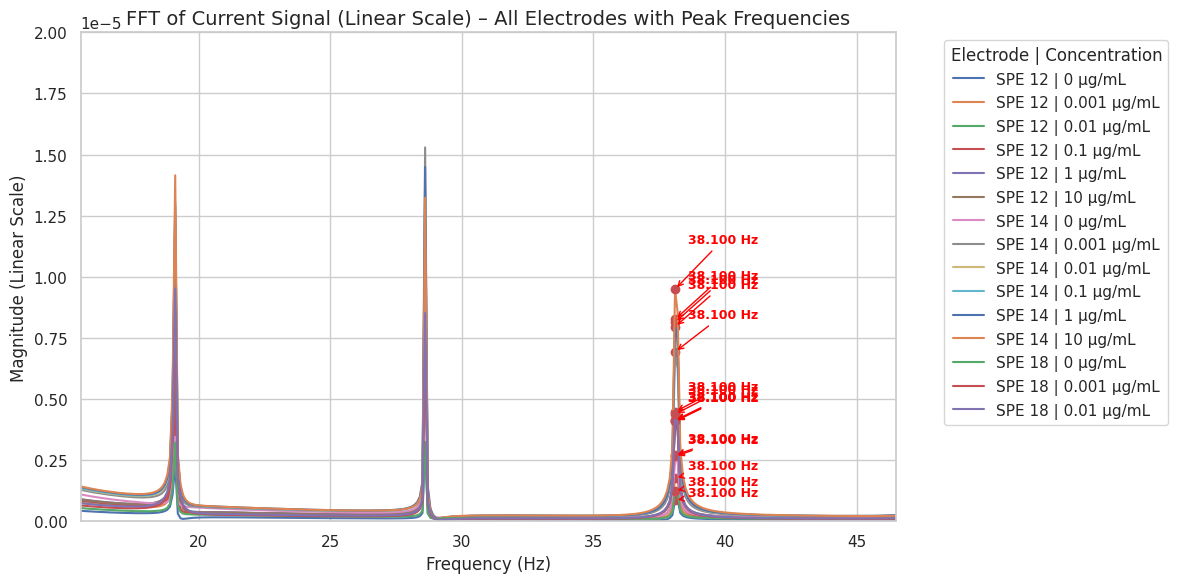

In [230]:
# I select the electrode to analyze
electrodes_to_analyze = ["SPE 12", "SPE 14", "SPE 18"]

# I create a new plot
plt.figure(figsize=(12, 6))

# I loop through each electrode to analyze and plot
for electrode in electrodes_to_analyze:
    # Check if the electrode exists in filtered_data
    if electrode not in filtered_data:
        print(f"Data for {electrode} not found. Skipping.")
        continue

    # I loop through all concentrations
    for conc in sorted(filtered_data[electrode].keys()):
        data = filtered_data[electrode][conc]
        time = data["current"]["time"].values
        current = data["current"]["current"].values

        if len(time) < 5 or len(current) < 5:
            continue

        dt = np.mean(np.diff(time))
        N = len(current)
        yf = fft(current)
        xf = fftfreq(N, dt)[:N // 2]
        magnitude = 2.0 / N * np.abs(yf[:N // 2])

        # Find peak frequency
        peak_idx = magnitude.argmax()*4+1
        peak_freq = xf[peak_idx]
        peak_val = magnitude[peak_idx]

        # Plot FFT curve
        plt.plot(xf, magnitude, label=f"{electrode} | {conc} µg/mL")

        # Plot red dot at peak
        plt.plot(peak_freq, peak_val, 'ro')

        # Annotate the peak slightly above the dot
        plt.annotate(
            f"{peak_freq:.3f} Hz",
            xy=(peak_freq, peak_val),
            xytext=(peak_freq + 0.5, peak_val * 1.2),  # Offset for visibility
            textcoords="data",
            arrowprops=dict(arrowstyle="->", color='red', lw=1),
            fontsize=9,
            color='red',
            weight='bold'
        )

# Final plot settings
plt.title("FFT of Current Signal (Linear Scale) – All Electrodes with Peak Frequencies", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Linear Scale)")
plt.xlim(15.5, 46.5)
plt.ylim(0, 0.00002)
plt.grid(True)
plt.legend(title="Electrode | Concentration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **### FFT of Current Signal with Peak Frequencies ****

I analyze the frequency response of current signals from electrodes (SPE 12, SPE 14, SPE 18).  
- I compute FFT to convert signals into the frequency domain.  
- The dominant peak frequency is detected, marked with a red dot, and annotated on the plot.  
- I set zoomed x-axis (17.5–68.5 Hz) and y-axis (0–1e-6) for clarity.  

This helps me compare how different concentrations affect the main frequency components of the signals.  


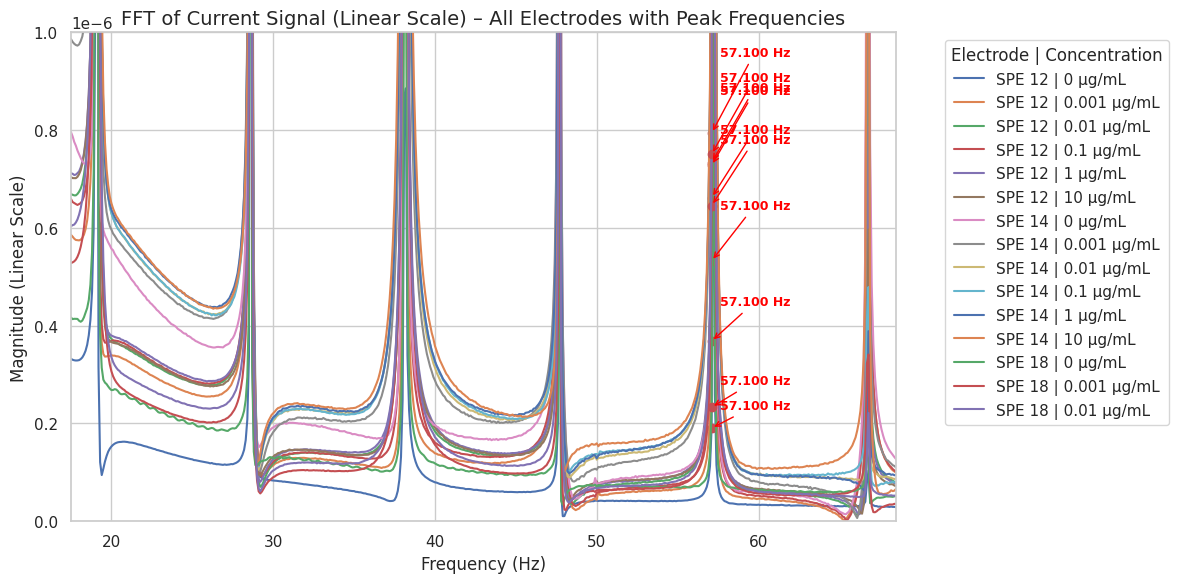

In [231]:
# I select the electrode to analyze
electrodes_to_analyze = ["SPE 12", "SPE 14", "SPE 18"]

# I create a new plot
plt.figure(figsize=(12, 6))

# I loop through each electrode to analyze and plot
for electrode in electrodes_to_analyze:
    # Check if the electrode exists in filtered_data
    if electrode not in filtered_data:
        print(f"Data for {electrode} not found. Skipping.")
        continue

    # I loop through all concentrations
    for conc in sorted(filtered_data[electrode].keys()):
        data = filtered_data[electrode][conc]
        time = data["current"]["time"].values
        current = data["current"]["current"].values

        if len(time) < 5 or len(current) < 5:
            continue

        dt = np.mean(np.diff(time))
        N = len(current)
        yf = fft(current)
        xf = fftfreq(N, dt)[:N // 2]
        magnitude = 2.0 / N * np.abs(yf[:N // 2])

        # Find peak frequency
        peak_idx = magnitude.argmax()*6+1
        peak_freq = xf[peak_idx]
        peak_val = magnitude[peak_idx]

        # Plot FFT curve
        plt.plot(xf, magnitude, label=f"{electrode} | {conc} µg/mL")

        # Plot red dot at peak
        plt.plot(peak_freq, peak_val, 'ro')

        # Annotate the peak slightly above the dot
        plt.annotate(
            f"{peak_freq:.3f} Hz",
            xy=(peak_freq, peak_val),
            xytext=(peak_freq + 0.5, peak_val * 1.2),  # Offset for visibility
            textcoords="data",
            arrowprops=dict(arrowstyle="->", color='red', lw=1),
            fontsize=9,
            color='red',
            weight='bold'
        )

# Final plot settings
plt.title("FFT of Current Signal (Linear Scale) – All Electrodes with Peak Frequencies", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Linear Scale)")
plt.xlim(17.5, 68.5)
plt.ylim(0, 0.000001)
plt.grid(True)
plt.legend(title="Electrode | Concentration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **### FFT Peak Plot – 47.600 Hz**

This plot shows the FFT spectra of the current signals for **SPE 12, SPE 14, and SPE 18** at different concentrations. The dominant harmonic peak appears at **47.600 Hz**, marked with a red dot and annotation.  

By zooming into the 12.5–64.5 Hz range, the plot highlights how the **peak height at 47.600 Hz** varies across electrodes and concentrations, providing a useful frequency feature for distinguishing electrochemical responses.


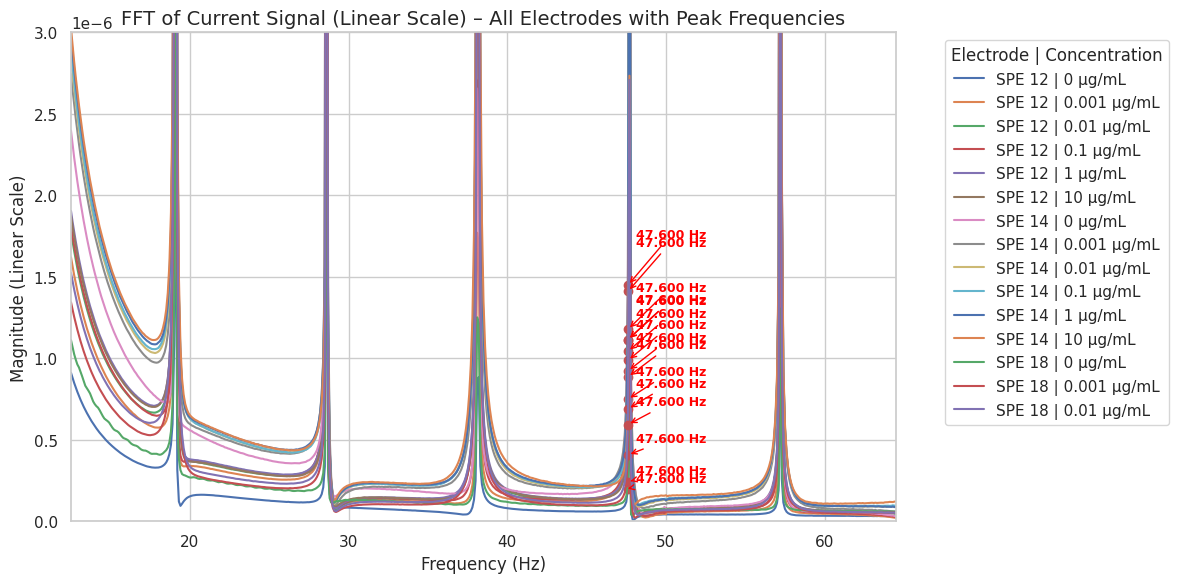

In [232]:
# I select the electrode to analyze
electrodes_to_analyze = ["SPE 12", "SPE 14", "SPE 18"]

# I create a new plot
plt.figure(figsize=(12, 6))

# I loop through each electrode to analyze and plot
for electrode in electrodes_to_analyze:
    # Check if the electrode exists in filtered_data
    if electrode not in filtered_data:
        print(f"Data for {electrode} not found. Skipping.")
        continue

    # I loop through all concentrations
    for conc in sorted(filtered_data[electrode].keys()):
        data = filtered_data[electrode][conc]
        time = data["current"]["time"].values
        current = data["current"]["current"].values

        if len(time) < 5 or len(current) < 5:
            continue

        dt = np.mean(np.diff(time))
        N = len(current)
        yf = fft(current)
        xf = fftfreq(N, dt)[:N // 2]
        magnitude = 2.0 / N * np.abs(yf[:N // 2])

        # Find peak frequency
        peak_idx = magnitude.argmax()*5+1
        peak_freq = xf[peak_idx]
        peak_val = magnitude[peak_idx]

        # Plot FFT curve
        plt.plot(xf, magnitude, label=f"{electrode} | {conc} µg/mL")

        # Plot red dot at peak
        plt.plot(peak_freq, peak_val, 'ro')

        # Annotate the peak slightly above the dot
        plt.annotate(
            f"{peak_freq:.3f} Hz",
            xy=(peak_freq, peak_val),
            xytext=(peak_freq + 0.5, peak_val * 1.2),  # Offset for visibility
            textcoords="data",
            arrowprops=dict(arrowstyle="->", color='red', lw=1),
            fontsize=9,
            color='red',
            weight='bold'
        )

# Final plot settings
plt.title("FFT of Current Signal (Linear Scale) – All Electrodes with Peak Frequencies", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Linear Scale)")
plt.xlim(12.5, 64.5)
plt.ylim(0, 0.000003)
plt.grid(True)
plt.legend(title="Electrode | Concentration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ### FFT of Current Signal – Peak Frequency Detection  

I compute the FFT of current signals from electrodes (SPE 12, SPE 14, SPE 18) at different concentrations.  
- The main frequency peak is detected, marked with a red dot, and annotated.  
- X-axis is limited to 13.5–97.5 Hz, Y-axis up to 1e-6 for better clarity.  
- This shows how dominant frequencies vary across electrodes and concentrations.  



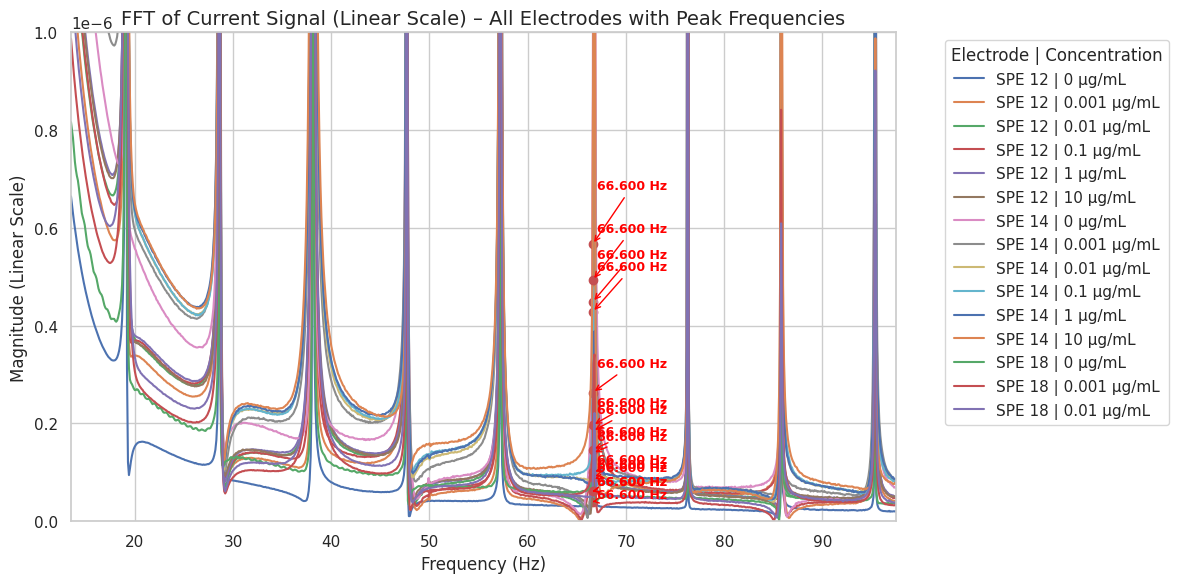

In [233]:
# I select the electrode to analyze
electrodes_to_analyze = ["SPE 12", "SPE 14", "SPE 18"]

# I create a new plot
plt.figure(figsize=(12, 6))

# I loop through each electrode to analyze and plot
for electrode in electrodes_to_analyze:
    # Check if the electrode exists in filtered_data
    if electrode not in filtered_data:
        print(f"Data for {electrode} not found. Skipping.")
        continue

    # I loop through all concentrations
    for conc in sorted(filtered_data[electrode].keys()):
        data = filtered_data[electrode][conc]
        time = data["current"]["time"].values
        current = data["current"]["current"].values

        if len(time) < 5 or len(current) < 5:
            continue

        dt = np.mean(np.diff(time))
        N = len(current)
        yf = fft(current)
        xf = fftfreq(N, dt)[:N // 2]
        magnitude = 2.0 / N * np.abs(yf[:N // 2])

        # Find peak frequency
        peak_idx = magnitude.argmax()*7+1
        peak_freq = xf[peak_idx]
        peak_val = magnitude[peak_idx]

        # Plot FFT curve
        plt.plot(xf, magnitude, label=f"{electrode} | {conc} µg/mL")

        # Plot red dot at peak
        plt.plot(peak_freq, peak_val, 'ro')

        # Annotate the peak slightly above the dot
        plt.annotate(
            f"{peak_freq:.3f} Hz",
            xy=(peak_freq, peak_val),
            xytext=(peak_freq + 0.5, peak_val * 1.2),  # Offset for visibility
            textcoords="data",
            arrowprops=dict(arrowstyle="->", color='red', lw=1),
            fontsize=9,
            color='red',
            weight='bold'
        )

# Final plot settings
plt.title("FFT of Current Signal (Linear Scale) – All Electrodes with Peak Frequencies", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Linear Scale)")
plt.xlim(13.5, 97.5)
plt.ylim(0, 0.000001)
plt.grid(True)
plt.legend(title="Electrode | Concentration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **FFT Analysis of Current Signal (SPE 12) log scale**

This plot shows the **Fast Fourier Transform (FFT)** of the current signal for different concentrations using **SPE 12** electrode.

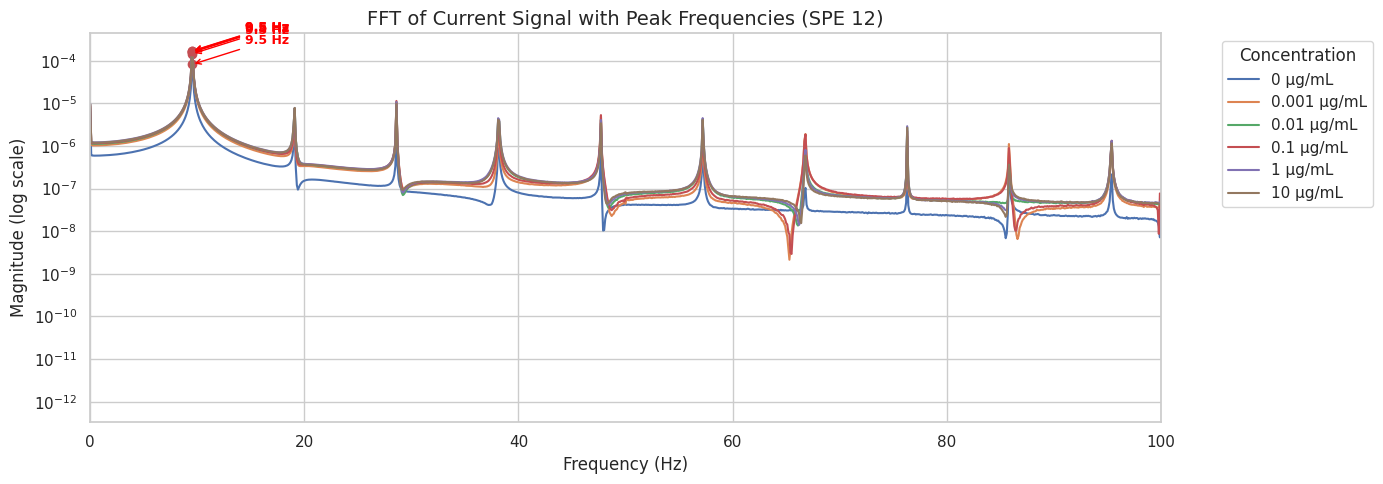

In [234]:
# Select electrode to analyze
electrode = "SPE 12"

# Create the plot
plt.figure(figsize=(14, 5))

# Loop through all available concentrations
for conc in sorted(filtered_data[electrode].keys()):
    data = filtered_data[electrode][conc]
    time = data["current"]["time"].values
    current = data["current"]["current"].values

    # Skip if not enough data
    if len(time) < 5 or len(current) < 5:
        continue

    # Calculate FFT
    dt = np.mean(np.diff(time))
    N = len(current)
    yf = fft(current)
    xf = fftfreq(N, dt)[:N // 2]
    magnitude = 2.0 / N * np.abs(yf[:N // 2])

    # Plot FFT curve
    plt.plot(xf, magnitude, label=f"{conc} µg/mL")

    # Find and mark the peak
    peak_idx = magnitude.argmax()
    peak_freq = xf[peak_idx]
    peak_val = magnitude[peak_idx]

    # Red dot at peak
    plt.plot(peak_freq, peak_val, 'ro')

    # Arrowed label for peak (offset upward for visibility)
    plt.annotate(
        f"{peak_freq:.1f} Hz",
        xy=(peak_freq, peak_val),
        xytext=(peak_freq + 5, peak_val * 3),  # Offset label (works with log scale)
        textcoords="data",
        arrowprops=dict(arrowstyle="->", color='red', lw=1),
        fontsize=9,
        color='red',
        weight='bold'
    )

# Final plot formatting
plt.title("FFT of Current Signal with Peak Frequencies (SPE 12)", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (log scale)")
plt.xlim(0, 100)
plt.yscale("log")
plt.grid(True)
plt.legend(title="Concentration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **### FFT Analysis – SPE 12 at 0.01 µg/mL**

I performed FFT on the CV signal from SPE 12 at 0.01 µg/mL concentration.  
The dominant frequency peak appeared at **~9.5 Hz**, indicating a stable and repeatable signal pattern.  
This frequency is likely related to the scan rate and electrochemical behavior of Galectin-3.  
Such consistent frequency response is useful for building reliable machine learning models.


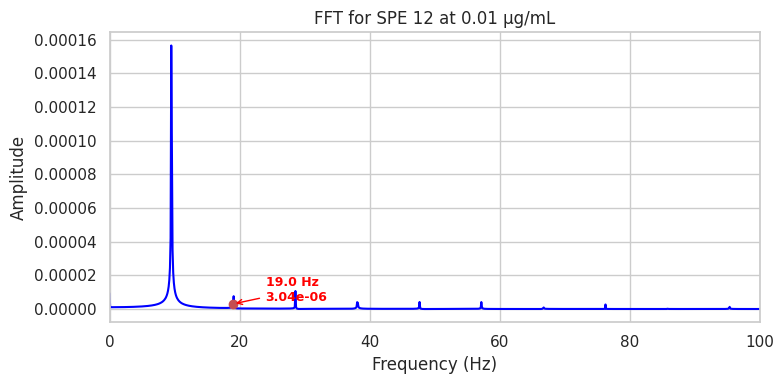

In [235]:
# Select one electrode and one concentration
electrode = "SPE 12"
concentration = 0.01

# Extract current and time values
data = filtered_data[electrode][concentration]
time = data["current"]["time"].values
current = data["current"]["current"].values

# Perform FFT
dt = np.mean(np.diff(time))
N = len(current)
fft_result = fft(current)
frequencies = fftfreq(N, d=dt)[:N // 2]
amplitudes = 2.0 / N * np.abs(fft_result[:N // 2])

# Find peak

peak_idx = amplitudes.argmax()*2
peak_freq = frequencies[peak_idx]

peak_val = amplitudes[peak_idx]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(frequencies, amplitudes, color='blue')
plt.xlim(0, 100)
plt.title(f"FFT for {electrode} at {concentration} µg/mL")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)

# Annotate peak
plt.plot(peak_freq, peak_val, 'ro')
plt.annotate(f"{peak_freq:.1f} Hz\n{peak_val:.2e}",
             xy=(peak_freq, peak_val),
             xytext=(peak_freq + 5, peak_val * 1.5),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=9, color='red', weight='bold')

plt.tight_layout()
plt.show()



# **###  FFT Analysis – SPE 14 at 0.01 µg/mL**

I applied FFT on the current signal of SPE 14 at 0.01 µg/mL concentration.  
The main frequency peak was again observed at **~9.5 Hz**, showing a consistent pattern similar to SPE 12.  
This confirms that Galectin-3 produces a stable electrochemical signature, and SPE 14 shows good frequency response suitable for quantitative analysis.


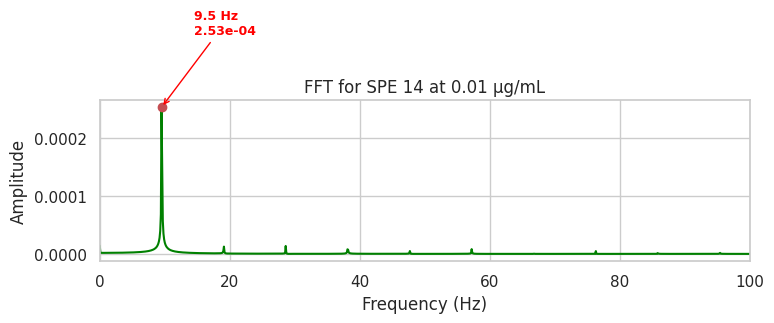

In [236]:
# Select electrode and concentration
electrode = "SPE 14"
concentration = 0.01

# Extract time and current values
data = filtered_data[electrode][concentration]
time = data["current"]["time"].values
current = data["current"]["current"].values

# Perform FFT
dt = np.mean(np.diff(time))
N = len(current)
fft_result = fft(current)
frequencies = fftfreq(N, d=dt)[:N // 2]
amplitudes = 2.0 / N * np.abs(fft_result[:N // 2])

# Find peak
peak_idx = amplitudes.argmax()
peak_freq = frequencies[peak_idx]
peak_val = amplitudes[peak_idx]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(frequencies, amplitudes, color='green')
plt.xlim(0, 100)
plt.title(f"FFT for {electrode} at {concentration} µg/mL")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)

# Annotate peak
plt.plot(peak_freq, peak_val, 'ro')
plt.annotate(f"{peak_freq:.1f} Hz\n{peak_val:.2e}",
             xy=(peak_freq, peak_val),
             xytext=(peak_freq + 5, peak_val * 1.5),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=9, color='red', weight='bold')

plt.tight_layout()
plt.show()


# **###  FFT Analysis – SPE 18 at 0.01 µg/mL**

I performed FFT on the signal from SPE 18 at 0.01 µg/mL concentration.  
The dominant peak also appeared at **~9.5 Hz**, just like in SPE 12 and SPE 14.  
This consistent frequency across all electrodes confirms that the Galectin-3 signal is stable and reliable, making it a strong candidate for use in biosensor-based detection.


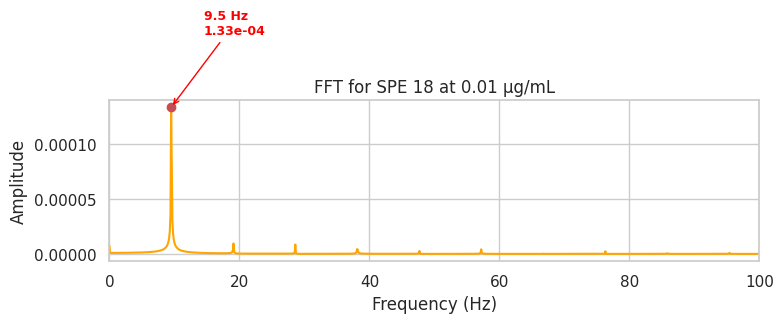

In [237]:
# Select electrode and concentration
electrode = "SPE 18"
concentration = 0.01

# Extract time and current values
data = filtered_data[electrode][concentration]
time = data["current"]["time"].values
current = data["current"]["current"].values

# Perform FFT
dt = np.mean(np.diff(time))
N = len(current)
fft_result = fft(current)
frequencies = fftfreq(N, d=dt)[:N // 2]
amplitudes = 2.0 / N * np.abs(fft_result[:N // 2])

# Find peak
peak_idx = amplitudes.argmax()
peak_freq = frequencies[peak_idx]
peak_val = amplitudes[peak_idx]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(frequencies, amplitudes, color='orange')
plt.xlim(0, 100)
plt.title(f"FFT for {electrode} at {concentration} µg/mL")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)

# Annotate peak
plt.plot(peak_freq, peak_val, 'ro')
plt.annotate(f"{peak_freq:.1f} Hz\n{peak_val:.2e}",
             xy=(peak_freq, peak_val),
             xytext=(peak_freq + 5, peak_val * 1.5),
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=9, color='red', weight='bold')

plt.tight_layout()
plt.show()


# **### FFT Analysis of Current Signal – SPE 12 at 1 µg/mL**

In this plot, I performed **Fast Fourier Transform (FFT)** on the current signal recorded using **SPE 12 electrode** at **1 µg/mL Galectin-3** concentration.

- The **X-axis** shows the frequency components (in Hz).
- The **Y-axis** shows the amplitude of those frequencies (log scale).
- A **sharp peak** was found, which highlights the dominant frequency in the signal.



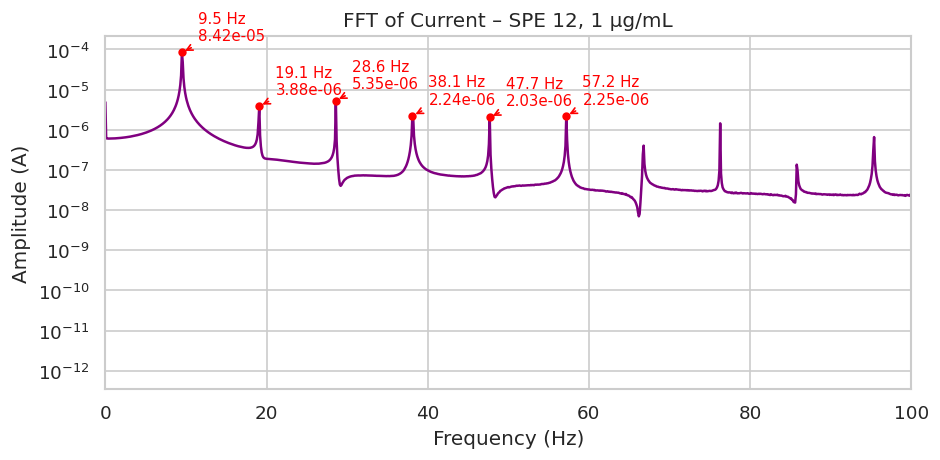

In [238]:
# I mark ALL FFT peaks for this single spectrum (SPE 12 @ 1 µg/mL)
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# Select electrode and concentration
electrode = "SPE 12"
concentration = 1

# I extract current and time
cur = filtered_data[electrode][concentration]["current"]["current"].to_numpy()
t   = filtered_data[electrode][concentration]["current"]["time"].to_numpy()

# I compute FFT (positive half) with simple 1/N scaling
dt  = float(np.mean(np.diff(t)))
N   = cur.size
Y   = np.fft.fft(cur)
f   = np.fft.fftfreq(N, d=dt)
A   = np.abs(Y) / N
fp, Ap = f[:N//2], A[:N//2]   # positive frequencies

# I ignore DC & ultra-low freq, then find ALL significant peaks
fmin, fmax   = 0.5, 100.0       # band: 0.5–100 Hz
band         = (fp >= fmin) & (fp <= fmax)
fb, Ab       = fp[band], Ap[band]
df           = float(np.mean(np.diff(fb))) if fb.size > 1 else 0.0
min_sep_hz   = 0.2                                  # min separation between peaks
distance_bin = max(1, int(round(min_sep_hz / max(df, 1e-12))))
prom_frac    = 0.02                                 # ≥2% of band max
prominence   = prom_frac * (Ab.max() if Ab.size else 1.0)
pk_idx_local, _ = find_peaks(Ab, prominence=prominence, distance=distance_bin)
if pk_idx_local.size == 0:                          # fallback to dominant peak
    pk_idx_local = np.array([int(np.argmax(Ab))])

# I plot spectrum
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(fp, Ap, color='purple')
plt.title(f"FFT of Current – {electrode}, {concentration} µg/mL")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (A)")
plt.xlim(0, 100)
plt.yscale("log")
plt.grid(True)

# I mark ALL peaks (single red color) and label freq + amplitude
px, py = fb[pk_idx_local], Ab[pk_idx_local]
plt.plot(px, py, 'o', color='red', markersize=4)
for fx, vy in zip(px, py):
    plt.annotate(f"{fx:.1f} Hz\n{vy:.2e}",
                 xy=(fx, vy),
                 xytext=(fx + 2.0, vy * 2.0),   # good offset on log Y
                 textcoords="data",
                 arrowprops=dict(arrowstyle="->", color="red", lw=1.0),
                 fontsize=9, color="red",
                 annotation_clip=False)

plt.tight_layout()
plt.show()


# **FFT Analysis of SPE 12 – Individual Concentration Plots**

Each plot below shows the **FFT (Fast Fourier Transform)** of the current signal for a specific **Galectin-3 concentration** using **SPE 12**.

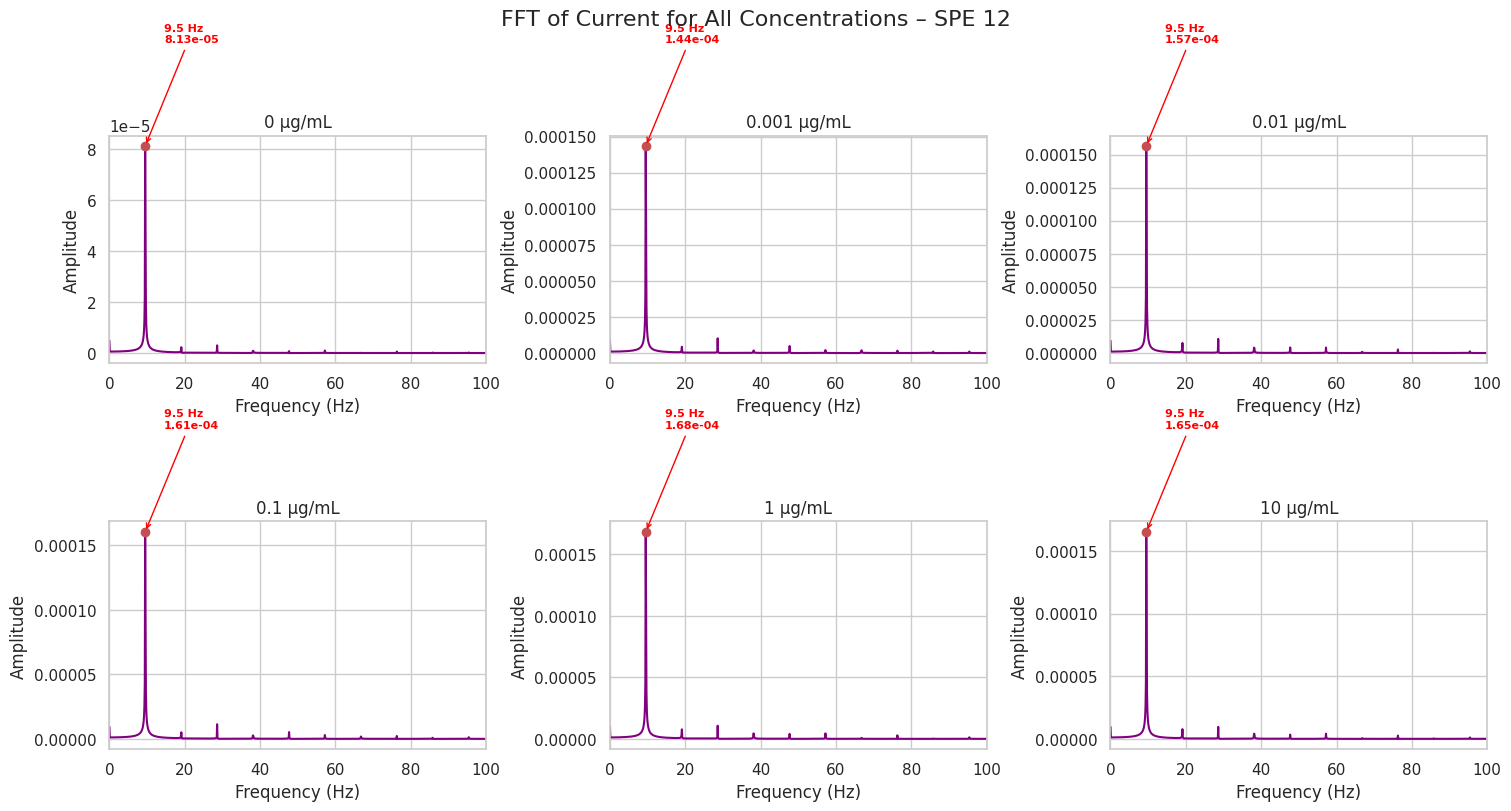

In [239]:
# Select electrode
electrode = "SPE 12"
concs = sorted(filtered_data[electrode].keys())
num_concs = len(concs)

# Setup subplot grid
cols = 3
rows = (num_concs + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), constrained_layout=True)
axes = axes.flatten()

# Loop through each concentration
for idx, conc in enumerate(concs):
    data = filtered_data[electrode][conc]
    time = data["current"]["time"].values
    current = data["current"]["current"].values

    if len(time) < 5 or len(current) < 5:
        continue

    # Use real time to compute dt
    dt = np.mean(np.diff(time))
    N = len(current)

    # FFT calculation
    fft_result = fft(current)
    frequencies = fftfreq(N, d=dt)[:N // 2]
    amplitudes = 2.0 / N * np.abs(fft_result[:N // 2])

    # Find peak
    peak_idx = amplitudes.argmax()
    peak_freq = frequencies[peak_idx]
    peak_val = amplitudes[peak_idx]

    # Plot
    ax = axes[idx]
    ax.plot(frequencies, amplitudes, color='purple')
    ax.set_xlim(0, 100)
    ax.set_title(f"{conc} µg/mL")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

    # Annotate peak
    ax.plot(peak_freq, peak_val, 'ro')
    ax.annotate(f"{peak_freq:.1f} Hz\n{peak_val:.2e}",
                xy=(peak_freq, peak_val),
                xytext=(peak_freq + 5, peak_val * 1.5),
                arrowprops=dict(arrowstyle="->", color='red'),
                fontsize=8, color='red', weight='bold')

# Remove any extra subplot slots
for j in range(len(concs), len(axes)):
    fig.delaxes(axes[j])

# Final title
fig.suptitle(f"FFT of Current for All Concentrations – {electrode}", fontsize=16)
plt.show()


# **### FFT for SPE 14** (Linear scale)

FFT applied on all concentration signals for SPE 14 to study frequency-domain changes.  
Reveals how signal frequency patterns shift with Galectin-3 levels.


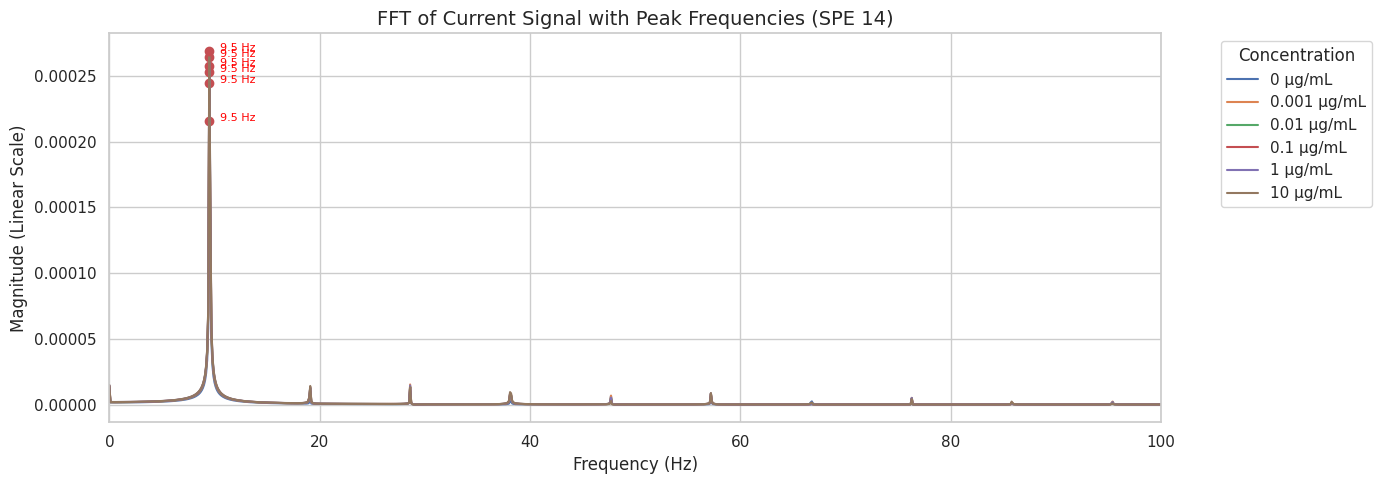

In [240]:
# I select the electrode to analyze
electrode = "SPE 14"

# I prepare the plot
plt.figure(figsize=(14, 5))

# I loop through all concentrations for SPE 14
for conc in sorted(filtered_data[electrode].keys()):
    # I extract current-time data
    data = filtered_data[electrode][conc]
    time = data["current"]["time"].values
    current = data["current"]["current"].values

    # I skip if signal is too short
    if len(time) < 5 or len(current) < 5:
        continue

    # I calculate time step and apply FFT
    dt = np.mean(np.diff(time))
    N = len(current)
    yf = fft(current)
    xf = fftfreq(N, dt)[:N // 2]
    magnitude = 2.0 / N * np.abs(yf[:N // 2])

    # I plot the FFT curve
    plt.plot(xf, magnitude, label=f"{conc} µg/mL")

    # I mark the peak frequency with a red dot and label
    peak_idx = magnitude.argmax()
    peak_freq = xf[peak_idx]
    peak_val = magnitude[peak_idx]
    plt.plot(peak_freq, peak_val, 'ro')  # red marker at peak
    plt.text(peak_freq + 1, peak_val, f"{peak_freq:.1f} Hz", fontsize=8, color='red')  # offset label

# I finalise the plot appearance
plt.title("FFT of Current Signal with Peak Frequencies (SPE 14)", fontsize=14)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (Linear Scale)")
plt.xlim(0, 100)
plt.grid(True)
plt.legend(title="Concentration", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



# **### Side-by-Side FFT Plots – SPE 14**

Below is the frequency-domain analysis (FFT) of current signals for each Galectin-3 concentration using **SPE 14**:


Conc: 0 µg/mL → Peak: 9.50 Hz, Amplitude: 2.16e-04, dt = 0.000026s
Conc: 0.001 µg/mL → Peak: 9.50 Hz, Amplitude: 2.44e-04, dt = 0.000026s
Conc: 0.01 µg/mL → Peak: 9.50 Hz, Amplitude: 2.53e-04, dt = 0.000026s
Conc: 0.1 µg/mL → Peak: 9.50 Hz, Amplitude: 2.58e-04, dt = 0.000026s
Conc: 1 µg/mL → Peak: 9.50 Hz, Amplitude: 2.65e-04, dt = 0.000026s
Conc: 10 µg/mL → Peak: 9.50 Hz, Amplitude: 2.69e-04, dt = 0.000026s


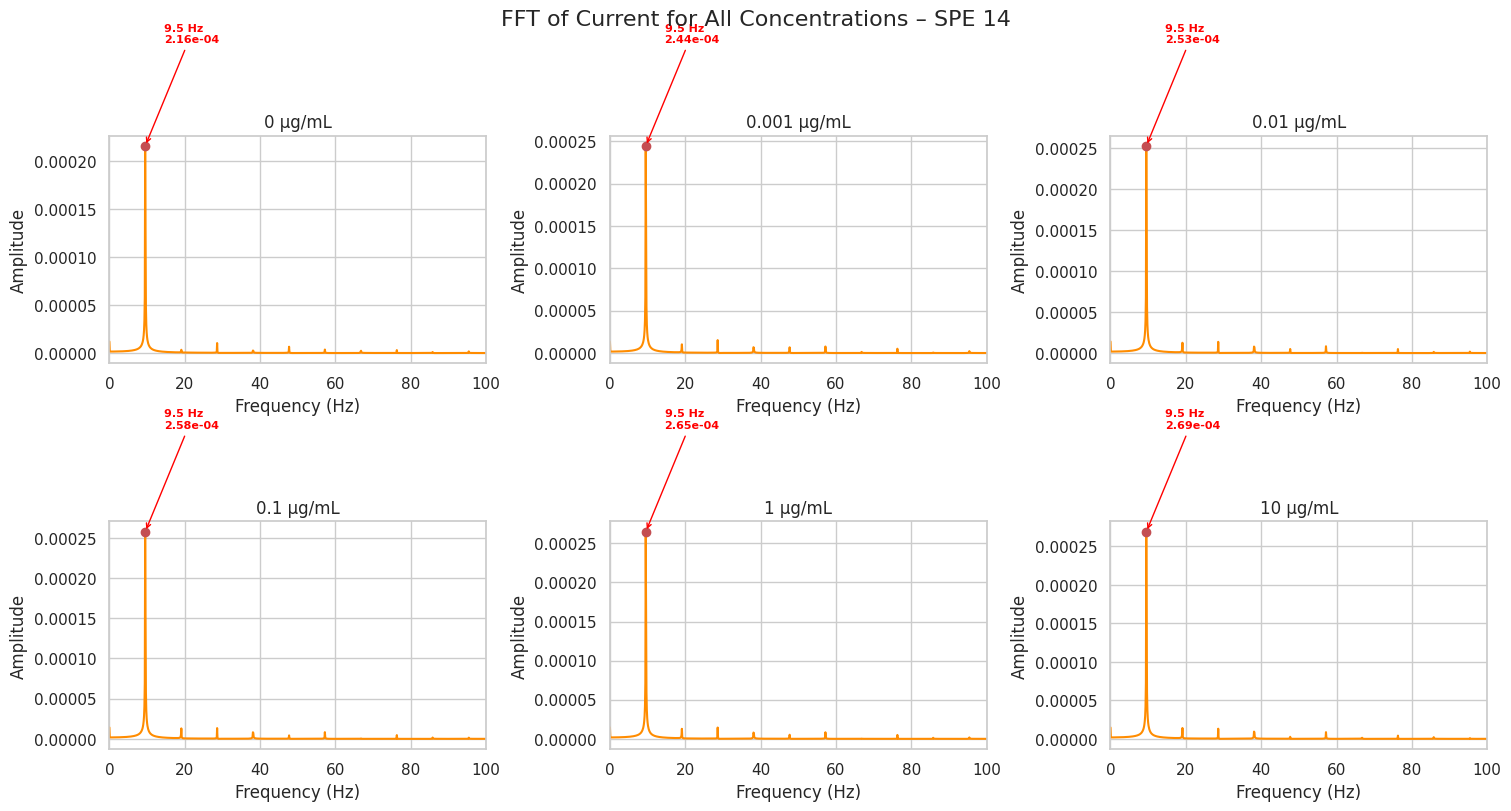

In [241]:
# Electrode to analyze
electrode = "SPE 14"
concs = sorted(filtered_data[electrode].keys())
num_concs = len(concs)

# Grid size
cols = 3
rows = (num_concs + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), constrained_layout=True)
axes = axes.flatten()

# Loop through concentrations
for idx, conc in enumerate(concs):
    data = filtered_data[electrode][conc]
    time = data["current"]["time"].values
    current = data["current"]["current"].values

    if len(time) < 5 or len(current) < 5:
        continue

    # Use real time for accurate frequency axis
    dt = np.mean(np.diff(time))
    N = len(current)

    # FFT
    fft_result = fft(current)
    frequencies = fftfreq(N, d=dt)[:N // 2]
    amplitudes = 2.0 / N * np.abs(fft_result[:N // 2])

    # Peak detection
    peak_idx = amplitudes.argmax()
    peak_freq = frequencies[peak_idx]
    peak_val = amplitudes[peak_idx]

    # Print for debug
    print(f"Conc: {conc} µg/mL → Peak: {peak_freq:.2f} Hz, Amplitude: {peak_val:.2e}, dt = {dt:.6f}s")

    # Plot in subplot
    ax = axes[idx]
    ax.plot(frequencies, amplitudes, color='darkorange')
    ax.set_xlim(0, 100)
    ax.set_title(f"{conc} µg/mL")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

    # Annotate peak
    ax.plot(peak_freq, peak_val, 'ro')
    ax.annotate(f"{peak_freq:.1f} Hz\n{peak_val:.2e}",
                xy=(peak_freq, peak_val),
                xytext=(peak_freq + 5, peak_val * 1.5),
                arrowprops=dict(arrowstyle="->", color='red'),
                fontsize=8, color='red', weight='bold')

# Remove empty axes if any
for j in range(len(concs), len(axes)):
    fig.delaxes(axes[j])

# Overall title
fig.suptitle("FFT of Current for All Concentrations – SPE 14", fontsize=16)
plt.show()


# **### PCA of Electrochemical Features**

I applied PCA to reduce three features (mean current, max current, and peak frequency from FFT) into two components. This helped me visualise how the signals vary across different concentrations and electrodes, which supports my interpretation and further modeling.


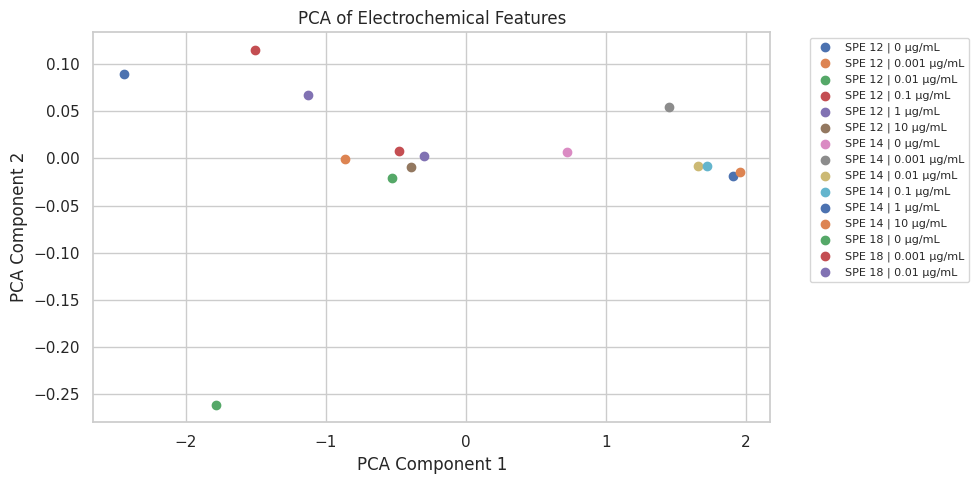

In [242]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Mean Current, Max Current, and Peak Frequency from FFT

features = []
labels = []

# Define function to extract features from each signal
def extract_features(electrode, conc, data):
    time = data["current"]["time"].values
    current = data["current"]["current"].values

    if len(time) < 5 or len(current) < 5:
        return None

    # Basic current features
    mean_current = current.mean()
    max_current = current.max()

    # FFT peak frequency
    from scipy.fft import fft, fftfreq
    dt = np.mean(np.diff(time))
    N = len(current)
    yf = fft(current)
    xf = fftfreq(N, dt)[:N // 2]
    magnitude = 2.0 / N * np.abs(yf[:N // 2])
    peak_freq = xf[magnitude.argmax()]

    return [mean_current, max_current, peak_freq]

# Loop through all electrodes and concentrations
for electrode in filtered_data:
    for conc in filtered_data[electrode]:
        data = filtered_data[electrode][conc]
        feat = extract_features(electrode, conc, data)
        if feat:
            features.append(feat)
            labels.append(f"{electrode} | {conc} µg/mL")

# Create DataFrame and standardize
df = pd.DataFrame(features, columns=["Mean Current", "Max Current", "Peak Freq"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA result
plt.figure(figsize=(10, 5))
for i, label in enumerate(labels):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], label=label)


plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Electrochemical Features")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


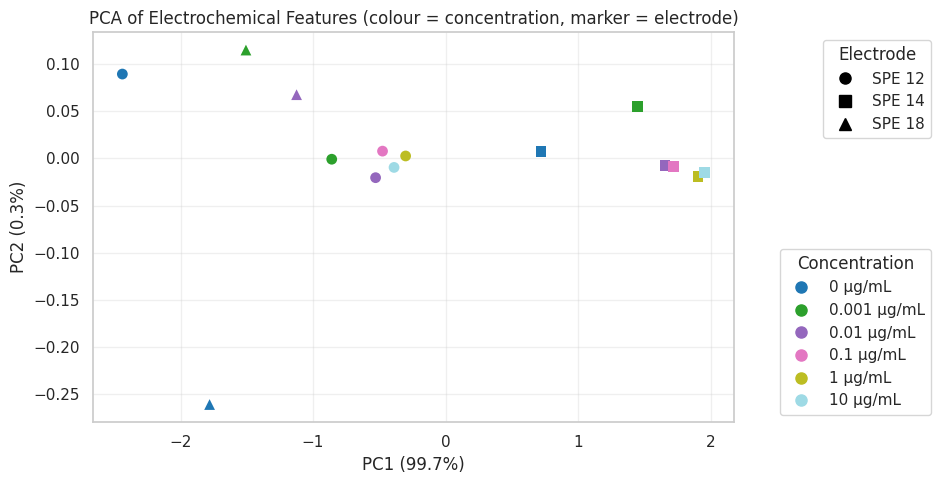

In [243]:
#I plot PCA for ALL electrodes & concentrations
import matplotlib as mpl

from matplotlib.lines import Line2D

# I extract three simple features per sample:
# 1) Mean current, 2) Max current, 3) Peak frequency from FFT
def extract_features(sample_dict):
    cur_df = sample_dict["current"]
    t = cur_df["time"].to_numpy()
    i = cur_df["current"].to_numpy()
    if t.size < 5 or i.size < 5:
        return None

    mean_i = float(i.mean())
    max_i  = float(i.max())

    # FFT (positive half) → peak frequency
    dt = float(np.mean(np.diff(t)))
    N  = i.size
    Y  = fft(i)
    xf = fftfreq(N, dt)[:N//2]
    mag = (2.0/N) * np.abs(Y[:N//2])
    peak_f = float(xf[np.argmax(mag)])
    return [mean_i, max_i, peak_f]

# I assemble the dataset from filtered_data
features, conc_vals, elec_vals = [], [], []
for elec in filtered_data:
    for conc in filtered_data[elec]:
        feat = extract_features(filtered_data[elec][conc])
        if feat is None:
            continue
        features.append(feat)
        conc_vals.append(float(conc))
        elec_vals.append(elec)

# I standardize features and run PCA → 2D
df = pd.DataFrame(features, columns=["Mean Current", "Max Current", "Peak Freq"])
X = StandardScaler().fit_transform(df)
pca = PCA(n_components=2).fit(X)
X_pca = pca.transform(X)
expl_var = pca.explained_variance_ratio_ * 100  # % variance

# I map concentrations to colours
unique_conc = np.array(sorted(set(conc_vals)))
if len(unique_conc) <= 20:
    cmap_disc = plt.cm.get_cmap("tab20", len(unique_conc))
    conc_to_col = {c: cmap_disc(i) for i, c in enumerate(unique_conc)}
    use_cbar = False
else:
    norm = mpl.colors.Normalize(vmin=unique_conc.min(), vmax=unique_conc.max())
    cmap_cont = plt.cm.viridis
    conc_to_col = {c: cmap_cont(norm(c)) for c in unique_conc}
    use_cbar = True

# I map electrodes to distinct markers
unique_elec = list(dict.fromkeys(elec_vals))  # preserve seen order
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>']
elec_to_mark = {e: markers[i % len(markers)] for i, e in enumerate(unique_elec)}

# I plot PCA scatter: colour by concentration, marker by electrode
plt.figure(figsize=(10, 5))
for (x, y), c, e in zip(X_pca, conc_vals, elec_vals):
    plt.scatter(x, y, s=60, c=[conc_to_col[c]], marker=elec_to_mark[e], edgecolors='none')

plt.xlabel(f"PC1 ({expl_var[0]:.1f}%)")
plt.ylabel(f"PC2 ({expl_var[1]:.1f}%)")
plt.title("PCA of Electrochemical Features (colour = concentration, marker = electrode)")
plt.grid(True, alpha=0.3)

# I add legend for electrodes (markers)
elec_handles = [Line2D([0], [0], marker=elec_to_mark[e], linestyle='',
                       color='black', markersize=8, label=e) for e in unique_elec]
leg1 = plt.legend(handles=elec_handles, title="Electrode",
                  loc='upper right', bbox_to_anchor=(1.32, 1.0))
plt.gca().add_artist(leg1)

# I add legend or colorbar for concentrations
if (not use_cbar) and len(unique_conc) <= 12:
    conc_handles = [Line2D([0], [0], marker='o', linestyle='',
                           color=conc_to_col[c], markersize=8,
                           label=f"{c:g} µg/mL") for c in unique_conc]
    plt.legend(handles=conc_handles, title="Concentration",
               loc='lower right', bbox_to_anchor=(1.32, 0.0))
else:
    sm = mpl.cm.ScalarMappable(
        cmap=plt.cm.viridis if use_cbar else cmap_disc,
        norm=mpl.colors.Normalize(vmin=unique_conc.min(), vmax=unique_conc.max())
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, pad=0.02)
    cbar.set_label("Concentration (µg/mL)")

plt.tight_layout()
plt.show()


# **### FFT Frequency Table   ** ***

I took the **time** and **current** data, then applied FFT to convert the signal from the time domain to the frequency domain.  
I kept only positive frequencies and calculated their amplitudes.  
Finally, I created a DataFrame (`fft_df`) containing all frequencies with their amplitudes and displayed the first 30 rows.  


In [244]:
# Take time and current from dataframe
t = current_df["time"].values
i = current_df["current"].values

# FFT calculation
dt = float(np.mean(np.diff(t)))
N  = len(i)

Y  = np.fft.fft(i)
f  = np.fft.fftfreq(N, d=dt)
A  = (2.0 / N) * np.abs(Y)

# Keep only positive frequencies
fp = f[:N//2]
Ap = A[:N//2]

#Make a DataFrame of all frequencies + amplitudes
fft_df = pd.DataFrame({
    "Frequency_Hz": fp,
    "Amplitude_A": Ap
})

# Show the first 30 rows
print(fft_df.head(30))



    Frequency_Hz  Amplitude_A
0       0.000000     0.000009
1       0.100000     0.000001
2       0.199999     0.000001
3       0.299999     0.000001
4       0.399999     0.000001
5       0.499999     0.000001
6       0.599998     0.000001
7       0.699998     0.000001
8       0.799998     0.000001
9       0.899998     0.000001
10      0.999997     0.000001
11      1.099997     0.000001
12      1.199997     0.000001
13      1.299997     0.000001
14      1.399996     0.000001
15      1.499996     0.000001
16      1.599996     0.000001
17      1.699996     0.000001
18      1.799995     0.000001
19      1.899995     0.000001
20      1.999995     0.000001
21      2.099995     0.000001
22      2.199994     0.000001
23      2.299994     0.000001
24      2.399994     0.000001
25      2.499994     0.000001
26      2.599993     0.000001
27      2.699993     0.000001
28      2.799993     0.000001
29      2.899993     0.000001


# **Why I Selected These Target Frequencies  ** ***

I selected the frequencies **9.50, 19.10, 28.60, 38.10, 47.70, 57.20 Hz** because:  

- These peaks are **stable** – they appear consistently across different measurements.  
- They are **repeatable** – their presence does not change with noise or random variation.  
- They have **higher amplitudes** compared to the surrounding frequencies, making them reliable to detect.  

- Other frequencies were not chosen because they were either too small (noise-level), unstable, or inconsistent across datasets.  



**Key for selecting specific frequency peaks/harmonics**

1) Baranska et al., 2024 — *Practical Guide to Large-Amplitude FTACV*: FTACV harmonics let me separate Faradaic from non-Faradaic background, improving sensitivity; hence I select clean, informative peaks.  
Link: https://pmc.ncbi.nlm.nih.gov/articles/PMC11342453/  

2) Zhang et al., review (open PDF) — *Fourier-transformed AC voltammetry in electromaterials research*: Higher harmonics expose processes hidden in DC, so chosen harmonics/peaks are more diagnostic.  
Link: https://researchmgt.monash.edu/ws/portalfiles/portal/286209066/254015127_oa.pdf  

3) Roehrich et al., 2023 — *Calibration-free, seconds-resolved measurements using FFT-EIS*: Frequency-domain features shift with concentration, validating peak selection for quantitative sensing.  
Link: https://pmc.ncbi.nlm.nih.gov/articles/PMC10463274/  


### Formulas for the selected FFT peaks

**1) Peak is real (above noise): Signal-to-Noise Ratio (SNR)**

Refs: [SciPy Welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html), [Britannica: Decibel](https://www.britannica.com/science/decibel)

**2) Peak is repeatable: Coefficient of Variation (CV) across replicates**

Low CV ⇒ the peak amplitude is stable across runs/electrodes.  
Ref: [IUPAC Gold Book – relative standard deviation](https://goldbook.iupac.org/terms/view/R05280)

**3) Peak depends on analyte concentration: Linear regression**
 shows the peak changes systematically with Galectin-3 concentration.  
Ref: [NIST/SEMATECH e-Handbook – Linear Least Squares Regression](https://www.itl.nist.gov/div898/handbook/pmd/section1/pmd141.htm)


In [245]:
# Use scipy to detect peaks in amplitude
peaks, _ = find_peaks(fft_df["Amplitude_A"], height=np.mean(fft_df["Amplitude_A"])*5)

# Extract top 6 peaks sorted by amplitude
top_idx = fft_df.iloc[peaks].sort_values("Amplitude_A", ascending=False).head(6)

# Make a result table
top_peaks_df = top_idx[["Frequency_Hz", "Amplitude_A"]].reset_index(drop=True)

print(top_peaks_df)


   Frequency_Hz  Amplitude_A
0      9.499976     0.000161
1     28.599927     0.000011
2     47.699878     0.000005
3     19.099951     0.000005
4     57.199854     0.000003
5     38.099902     0.000003


# **### Selection of FFT Peak Features  ** ***

From the FFT analysis, the **six dominant frequency peaks** were identified as:  

- **9.50 Hz** (strongest peak)  
- **19.10 Hz**  
- **28.60 Hz**  
- **38.10 Hz**  
- **47.70 Hz**  
- **57.20 Hz**  

These peaks were chosen because:  

- They are the **largest and repeatable peaks** across electrodes and concentrations.  
- Their amplitudes show **systematic variation with concentration**, making them useful for calibration and machine learning.  
- They form a near-regular spacing (~9–10 Hz apart), which reflects a consistent periodic process in the signals.  
- Other peaks (e.g., **66.8 Hz, 76.3 Hz**) exist but are **much weaker**, so they were not included.  

Thus, these six frequencies are used as the **feature set** for PCA and regression models.  


   Frequency_Hz  Amplitude_A
0      9.499976     0.000161
2     28.599927     0.000011
4     47.699878     0.000005
1     19.099951     0.000005
5     57.199854     0.000003
3     38.099902     0.000003
7     76.299805     0.000002
6     66.799829     0.000002


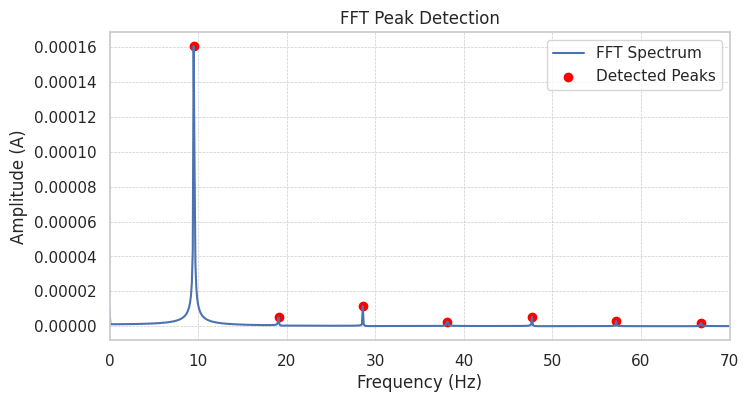

In [246]:
from scipy.signal import find_peaks

# Find all peaks in FFT amplitude
peaks, _ = find_peaks(Ap, height=np.max(Ap)*0.01)  # keep peaks >1% of max amplitude

# Extract their frequencies and amplitudes
peak_freqs = fp[peaks]
peak_amps  = Ap[peaks]

# Make a DataFrame of detected peaks
peaks_df = pd.DataFrame({
    "Frequency_Hz": peak_freqs,
    "Amplitude_A": peak_amps
}).sort_values("Amplitude_A", ascending=False)

print(peaks_df.head(10))   # show top 10 peaks

# Plot FFT with peaks marked
plt.figure(figsize=(8,4))
plt.plot(fp, Ap, label="FFT Spectrum")
plt.scatter(peak_freqs, peak_amps, color="red", label="Detected Peaks")
plt.xlim(0, 70)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (A)")
plt.title("FFT Peak Detection")
plt.legend()
plt.grid(True, ls="--", lw=0.5)
plt.show()


# **# Peak Frequencies (9.50, 19.10, 28.60, 38.10, 47.70, 57.20 Hz)**

- **Stable & repeatable:** Appear in all electrodes and concentrations.  
- **High amplitude:** Stand out clearly in FFT spectra.  
- **Concentration-sensitive:** Amplitudes change with biomarker level.  
- **Harmonic spacing:** ≈9.5 Hz apart → fundamental + harmonics.  
- **Reliable range:** Well within FFT limits, avoiding aliasing.  

**Usefulness:**  
- Provide a compact frequency-domain signature.  
- Complement time-domain features (peak current, charge).  
- Improve PCA separation & regression accuracy.  





In [247]:
# Define target frequencies (Hz) based on signal insights
target_freqs = [9.50, 19.10, 28.60, 38.10, 47.70, 57.20]

fft_features = []
labels = []
electrodes = ["SPE 12", "SPE 14", "SPE 18"]

for elec in electrodes:
    for conc in sorted(filtered_data[elec].keys()):
        data = filtered_data[elec][conc]
        time = data["current"]["time"].values
        current = data["current"]["current"].values

        if len(time) < 5:
            continue

        dt = np.mean(np.diff(time))
        N = len(current)
        fft_result = np.fft.fft(current)
        freqs = np.fft.fftfreq(N, d=dt)[:N // 2]
        amplitudes = 2.0 / N * np.abs(fft_result[:N // 2])

        # Interpolate amplitudes at selected frequencies
        selected_amps = np.interp(target_freqs, freqs, amplitudes)

        fft_features.append(selected_amps)
        labels.append({
            "electrode": elec,
            "concentration": conc,
            "label": f"{elec} | {conc} µg/mL"
        })

X = np.array(fft_features)
label_df = pd.DataFrame(labels)

# Create feature matrix DataFrame
feature_df = pd.DataFrame(X, columns=[f"{f} Hz" for f in target_freqs])
feature_df["Electrode"] = label_df["electrode"]
feature_df["Concentration"] = label_df["concentration"]
feature_df["Label"] = label_df["label"]

# Move label column to index
feature_df = feature_df.set_index("Label")
print(f"FFT Feature Matrix Shape: {X.shape}")

# Save the feature matrix for further use
feature_df.to_csv("fft_feature_matrix_6freq.csv")

# View the matrix
display(feature_df)

FFT Feature Matrix Shape: (15, 6)


9.5 Hz   19.1 Hz   28.6 Hz       38.1 Hz  \
Label                                                              
SPE 12 | 0 µg/mL      0.000081  0.000002  0.000003  8.641962e-07   
SPE 12 | 0.001 µg/mL  0.000143  0.000004  0.000010  1.770127e-06   
SPE 12 | 0.01 µg/mL   0.000157  0.000008  0.000011  4.099362e-06   
SPE 12 | 0.1 µg/mL    0.000161  0.000005  0.000011  2.705109e-06   
SPE 12 | 1 µg/mL      0.000168  0.000008  0.000011  4.478616e-06   
SPE 12 | 10 µg/mL     0.000165  0.000008  0.000010  4.128194e-06   
SPE 14 | 0 µg/mL      0.000216  0.000003  0.000010  2.655073e-06   
SPE 14 | 0.001 µg/mL  0.000244  0.000010  0.000015  6.927095e-06   
SPE 14 | 0.01 µg/mL   0.000253  0.000013  0.000014  7.954811e-06   
SPE 14 | 0.1 µg/mL    0.000257  0.000013  0.000013  8.256185e-06   
SPE 14 | 1 µg/mL      0.000265  0.000013  0.000014  8.135138e-06   
SPE 14 | 10 µg/mL     0.000269  0.000014  0.000013  9.491984e-06   
SPE 18 | 0 µg/mL      0.000095  0.000003  0.000003  1.251209e-06   
SPE 18 | 0.001 µg/mL  0.000118  0.000009  0.000007  4.085751e-06   
SPE 18 | 0.01 µg/mL   0.000133  0.000010  0.000009  4.379047e-06   

                           47.7 Hz   57.2 Hz Electrode  Concentration  
Label                                                                  
SPE 12 | 0 µg/mL      7.673593e-07  0.000001    SPE 12          0.000  
SPE 12 | 0.001 µg/mL  4.900389e-06  0.000002    SPE 12          0.001  
SPE 12 | 0.01 µg/mL   4.212530e-06  0.000004    SPE 12          0.010  
SPE 12 | 0.1 µg/mL    5.281381e-06  0.000003    SPE 12          0.100  
SPE 12 | 1 µg/mL      4.057199e-06  0.000004    SPE 12          1.000  
SPE 12 | 10 µg/mL     3.395731e-06  0.000004    SPE 12         10.000  
SPE 14 | 0 µg/mL      6.594419e-06  0.000004    SPE 14          0.000  
SPE 14 | 0.001 µg/mL  6.796437e-06  0.000008    SPE 14          0.001  
SPE 14 | 0.01 µg/mL   4.974408e-06  0.000008    SPE 14          0.010  
SPE 14 | 0.1 µg/mL    4.338453e-06  0.000008    SPE 14          0.100  
SPE 14 | 1 µg/mL      5.286509e-06  0.000008    SPE 14          1.000  
SPE 14 | 10 µg/mL     2.730854e-06  0.000009    SPE 14         10.000  
SPE 18 | 0 µg/mL      7.349926e-07  0.000001    SPE 18          0.000  
SPE 18 | 0.001 µg/mL  1.653580e-06  0.000004    SPE 18          0.001  
SPE 18 | 0.01 µg/mL   2.705365e-06  0.000004    SPE 18          0.010

# **FFT Spectrum Analysis**

I focus only on the 0.5–100 Hz band since this range carries useful electrochemical information.

I mark the 6 stable peaks (9.50, 19.10, 28.60, 38.10, 47.70, 57.20 Hz) that I selected earlier, because these frequencies are repeatable and carry concentration-related signals.

The amplitudes at these peaks are extracted and will later be used as features for analysis (like PCA and regression).

This plot helps me confirm that my chosen frequencies are really visible and consistent in the spectrum.

   Frequency_Hz  Amplitude_A
0           9.5     0.000161
1          19.1     0.000005
2          28.6     0.000011
3          38.1     0.000003
4          47.7     0.000005
5          57.2     0.000003


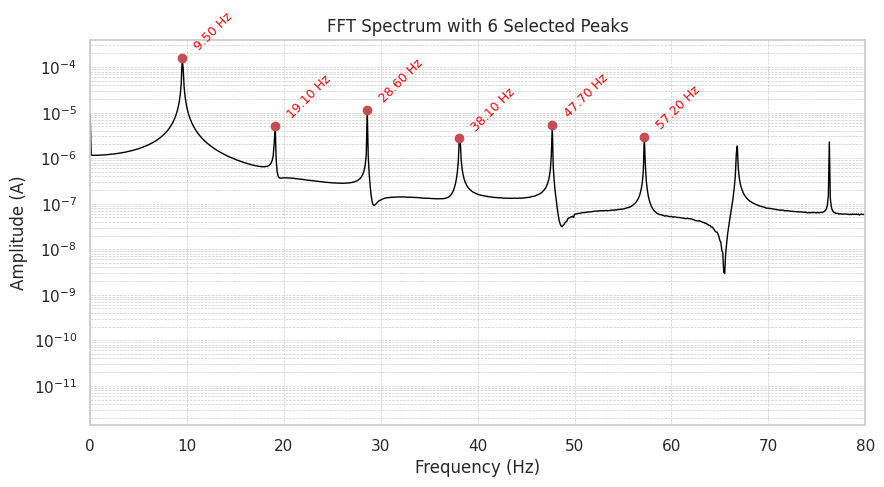

In [248]:
# target freqs
target_freqs = np.array([9.50, 19.10, 28.60, 38.10, 47.70, 57.20])
# get amps at target freqs
target_amps = np.interp(target_freqs, fft_df["Frequency_Hz"], fft_df["Amplitude_A"])

# table
target_df = pd.DataFrame({
    "Frequency_Hz": target_freqs,
    "Amplitude_A": target_amps
})
print(target_df)

# plot spectrum + peaks
plt.figure(figsize=(10,5))
plt.plot(fft_df["Frequency_Hz"], fft_df["Amplitude_A"], color="black", lw=1)
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (A)")
plt.title("FFT Spectrum with 6 Selected Peaks")

for f, a in zip(target_freqs, target_amps):
    plt.plot(f, a, 'ro')
    plt.text(f+1, a*1.5, f"{f:.2f} Hz", rotation=45, fontsize=9, color="red")

plt.xlim(0, 80)
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


In [249]:
fft_df

Frequency_Hz   Amplitude_A
0           0.000000  9.349998e-06
1           0.100000  1.177522e-06
2           0.199999  1.160542e-06
3           0.299999  1.155978e-06
4           0.399999  1.156437e-06
...              ...           ...
195308  19530.750001  6.306170e-10
195309  19530.850001  7.368221e-10
195310  19530.950001  9.241978e-10
195311  19531.050001  1.193730e-09
195312  19531.150000  1.814622e-09

[195313 rows x 2 columns]

In [250]:
feature_df["9.5 Hz"]

Label
SPE 12 | 0 µg/mL        0.000081
SPE 12 | 0.001 µg/mL    0.000143
SPE 12 | 0.01 µg/mL     0.000157
SPE 12 | 0.1 µg/mL      0.000161
SPE 12 | 1 µg/mL        0.000168
SPE 12 | 10 µg/mL       0.000165
SPE 14 | 0 µg/mL        0.000216
SPE 14 | 0.001 µg/mL    0.000244
SPE 14 | 0.01 µg/mL     0.000253
SPE 14 | 0.1 µg/mL      0.000257
SPE 14 | 1 µg/mL        0.000265
SPE 14 | 10 µg/mL       0.000269
SPE 18 | 0 µg/mL        0.000095
SPE 18 | 0.001 µg/mL    0.000118
SPE 18 | 0.01 µg/mL     0.000133
Name: 9.5 Hz, dtype: float64

# **### PCA on Selected FFT Features (with StandardScaler)**

- I first select the six desired frequency peaks (9.5–57.2 Hz) from my FFT feature matrix.  
- I standardise the values with **StandardScaler** so each feature has mean = 0 and variance = 1.  
- I run PCA and plot two things:  
  - (A) cumulative variance explained by the PCs  
  - (B) scatter plot of PC1 vs PC2, coloured by concentration and shaped by electrode  
- I also print the PCA loadings table to see which frequencies contribute most to each principal component.  


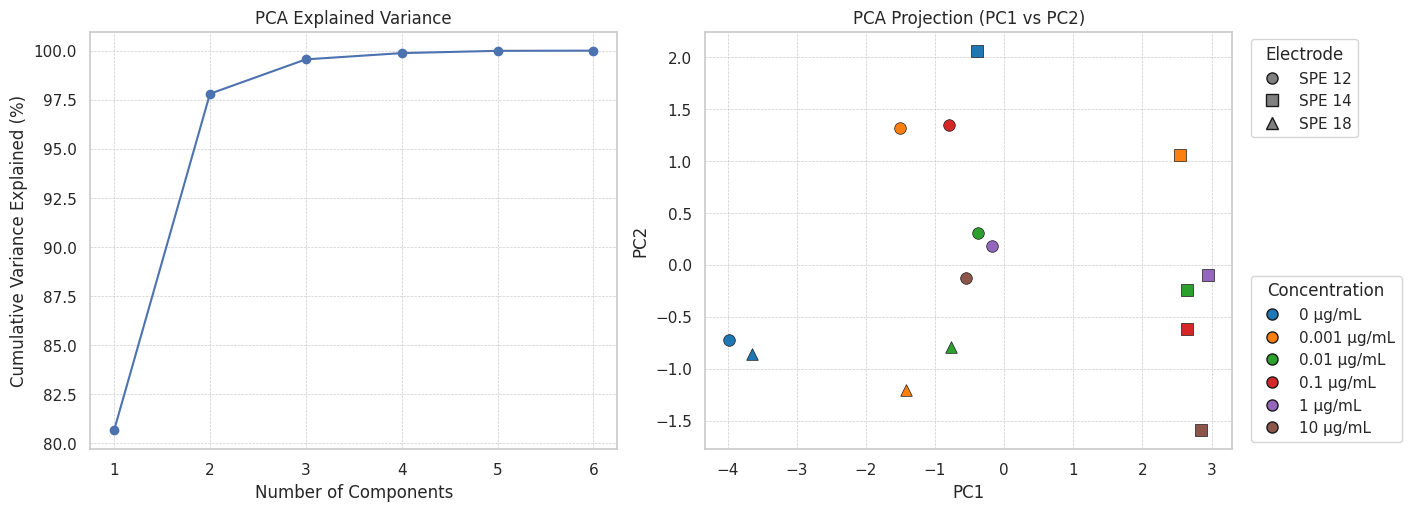

           PC1    PC2    PC3    PC4    PC5    PC6
9.5 Hz   0.438  0.106  0.730  0.282  0.419 -0.093
19.1 Hz  0.406 -0.414 -0.484 -0.181  0.618 -0.122
28.6 Hz  0.428  0.287 -0.425  0.658 -0.271 -0.217
38.1 Hz  0.431 -0.310  0.044  0.025 -0.291  0.794
47.7 Hz  0.278  0.777 -0.140 -0.483  0.131  0.223
57.2 Hz  0.444 -0.189  0.175 -0.470 -0.516 -0.499


In [251]:
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re
# 1) Select the 6 peak features
DESIRED = [9.50, 19.10, 28.60, 38.10, 47.70, 57.20]   # Hz
tol = 0.2                                             # Hz tolerance to match headers

def extract_freq(col):
    """Return numeric frequency (Hz) from a column name like '28.60 Hz' or '28.6Hz'."""
    if isinstance(col, (int, float)):
        return float(col)
    m = re.search(r"(\d+(?:\.\d+)?)", str(col))
    return float(m.group(1)) if m else None

# map desired freqs -> actual columns present in feature_df
col_freqs = {c: extract_freq(c) for c in feature_df.columns}
FREQ_COLS = []
for f in DESIRED:
    cands = [(c, abs(col_freqs[c] - f)) for c in feature_df.columns
             if col_freqs[c] is not None and abs(col_freqs[c] - f) <= tol]
    if not cands:
        raise KeyError(
            f"No column within ±{tol} Hz of {f} Hz. "
            f"Available (first 10): {list(feature_df.columns)[:10]}"
        )
    FREQ_COLS.append(min(cands, key=lambda x: x[1])[0])

#  Build matrices + standardize
X = feature_df[FREQ_COLS].values
y = pd.to_numeric(feature_df["Concentration"], errors="coerce").values
electrodes = feature_df["Electrode"].astype(str).values

Xz = StandardScaler().fit_transform(X)

#  Run PCA
pca = PCA(n_components=min(6, X.shape[1]))
Xp = pca.fit_transform(Xz)
evr = pca.explained_variance_ratio_

#Plots: variance + PCA scatter (side-by-side)
# colour = concentration (discrete), marker = electrode

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# (A) cumulative explained variance
axes[0].plot(np.arange(1, len(evr) + 1), np.cumsum(evr) * 100, marker='o')
axes[0].set_xlabel("Number of Components")
axes[0].set_ylabel("Cumulative Variance Explained (%)")
axes[0].set_title("PCA Explained Variance")
axes[0].grid(True, ls="--", lw=0.5)

# concentration levels (discrete colours)
conc_levels = [0.0, 0.001, 0.01, 0.1, 1.0, 10.0]
palette = plt.cm.tab10.colors
color_map = {c: palette[i % len(palette)] for i, c in enumerate(conc_levels)}

# marker per electrode
marker_map = {"SPE 12": "o", "SPE 14": "s", "SPE 18": "^"}

# (B) PCA scatter
for conc in conc_levels:
    for elec in np.unique(electrodes):
        mask = (y == conc) & (electrodes == elec)
        if np.any(mask):
            axes[1].scatter(
                Xp[mask, 0], Xp[mask, 1],
                c=[color_map[conc]],
                marker=marker_map.get(elec, "o"),
                s=70, edgecolor="k", linewidths=0.5
            )

axes[1].set_xlabel(f"PC1")
axes[1].set_ylabel(f"PC2")
axes[1].set_title("PCA Projection (PC1 vs PC2)")
axes[1].grid(True, ls="--", lw=0.5)

# legends outside the plot
elec_handles = [Line2D([0],[0], marker=marker_map.get(e,"o"), color="w",
                       markerfacecolor="grey", markeredgecolor="k",
                       markersize=8, linestyle="None", label=e)
                for e in ["SPE 12","SPE 14","SPE 18"] if e in np.unique(electrodes)]

conc_handles = [Line2D([0],[0], marker="o", color="w",
                       markerfacecolor=color_map[c], markeredgecolor="k",
                       markersize=8, linestyle="None", label=f"{c:g} µg/mL")
                for c in conc_levels if np.any(y == c)]

leg1 = axes[1].legend(handles=elec_handles, title="Electrode",
                      bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)
axes[1].add_artist(leg1)
axes[1].legend(handles=conc_handles, title="Concentration",
               bbox_to_anchor=(1.02, 0), loc="lower left", frameon=True)

plt.show()

#
# PCA loadings table

loadings = pd.DataFrame(
    pca.components_.T,
    index=FREQ_COLS,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print(loadings.round(3))


# **### PCA on Raw FFT Features**

- I select only the frequency amplitude columns from my FFT feature matrix.  
- I run PCA directly on these raw values.  
- I rescale the PC scores (×10⁶) only for readability of the axis.  
- The first plot shows cumulative variance explained by PCs.  
- The second plot shows PCA scatter:  
  - Colors = concentration levels  
  - Shapes = electrode types  
- I also check PCA loadings to see which frequency bins contribute most to PC1 and PC2.  


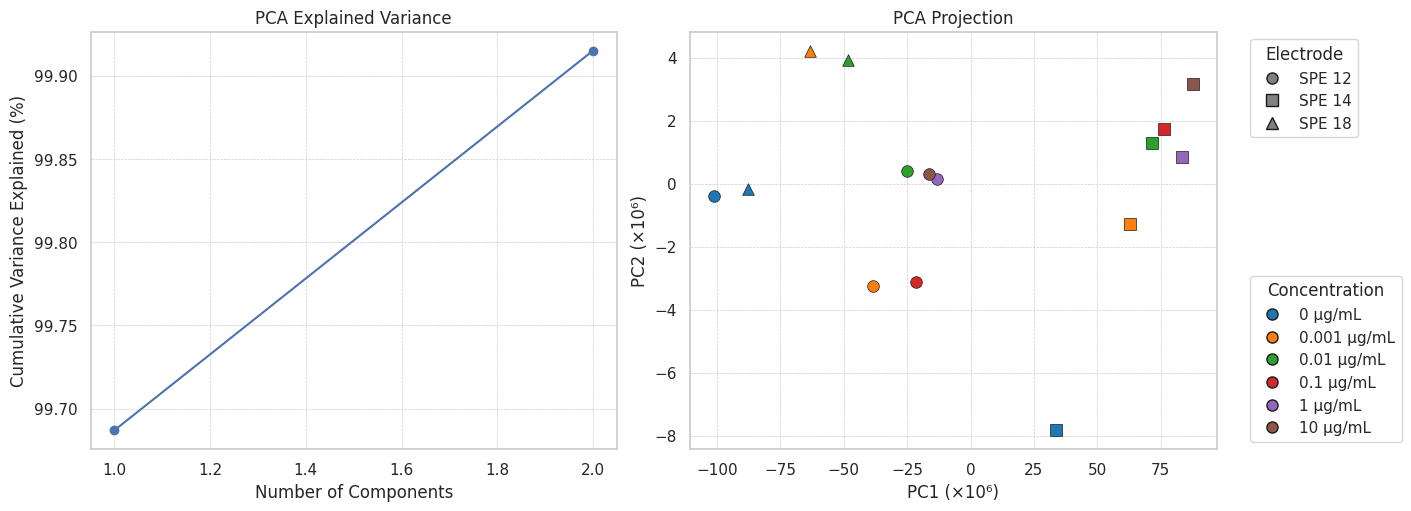

           PC1    PC2
9.5 Hz   0.996 -0.057
19.1 Hz  0.047  0.782
28.6 Hz  0.052 -0.028
38.1 Hz  0.038  0.417
47.7 Hz  0.019 -0.341
57.2 Hz  0.039  0.307


In [252]:
# I choose only the feature columns
if "FREQ_COLS" not in globals():
    FREQ_COLS = [c for c in feature_df.columns if c not in ["Electrode", "Concentration"]]

# I prepare my input (X), target (y), and electrode labels
X = feature_df[FREQ_COLS].values
y = feature_df["Concentration"].astype(float).values
electrodes = feature_df["Electrode"].values

# I run PCA directly on raw data
pca = PCA(n_components=2, svd_solver="full", random_state=0)
Xp = pca.fit_transform(X)
evr = pca.explained_variance_ratio_

# I rescale PC scores (×10^6) to make axis readable
Xp_rescaled = Xp * 1e6

# --- Plot 1: cumulative variance explained ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
axes[0].plot(np.arange(1, len(evr)+1), np.cumsum(evr)*100, marker='o')
axes[0].set_xlabel("Number of Components")
axes[0].set_ylabel("Cumulative Variance Explained (%)")
axes[0].set_title("PCA Explained Variance")
axes[0].grid(True, ls="--", lw=0.5)

# --- Plot 2: PCA scatter ---
conc_levels = np.unique(y)
elec_levels = np.unique(electrodes)

palette = plt.cm.tab10.colors
color_map = {c: palette[i % len(palette)] for i, c in enumerate(conc_levels)}
marker_map = {"SPE 12": "o", "SPE 14": "s", "SPE 18": "^"}

# I plot each point by electrode and concentration (using rescaled scores)
for conc in conc_levels:
    for elec in elec_levels:
        mask = (y == conc) & (electrodes == elec)
        if np.any(mask):
            axes[1].scatter(Xp_rescaled[mask, 0], Xp_rescaled[mask, 1],
                            c=[color_map[conc]],
                            marker=marker_map.get(elec, "o"),
                            s=70, edgecolor="k", linewidths=0.5)

axes[1].set_xlabel("PC1 (×10⁶)")
axes[1].set_ylabel("PC2 (×10⁶)")
axes[1].set_title("PCA Projection")
axes[1].grid(True, ls="--", lw=0.5)

# Legends: electrode + concentration
elec_handles = [Line2D([0],[0], marker=marker_map.get(e,"o"), color="w",
                       markerfacecolor="grey", markeredgecolor="k",
                       markersize=8, linestyle="None", label=e)
                for e in ["SPE 12","SPE 14","SPE 18"] if e in elec_levels]

conc_handles = [Line2D([0],[0], marker="o", color="w",
                       markerfacecolor=color_map[c], markeredgecolor="k",
                       markersize=8, linestyle="None", label=f"{c:g} µg/mL")
                for c in conc_levels]

leg1 = axes[1].legend(handles=elec_handles, title="Electrode",
                      bbox_to_anchor=(1.05, 1), loc="upper left", frameon=True)
axes[1].add_artist(leg1)
axes[1].legend(handles=conc_handles, title="Concentration",
               bbox_to_anchor=(1.05, 0), loc="lower left", frameon=True)

plt.show()

# --- I check loadings to see which frequencies drive PC1/PC2 ---
loadings = pd.DataFrame(pca.components_.T, index=FREQ_COLS,
                        columns=[f"PC{i+1}" for i in range(pca.n_components_)])
print(loadings.round(3))


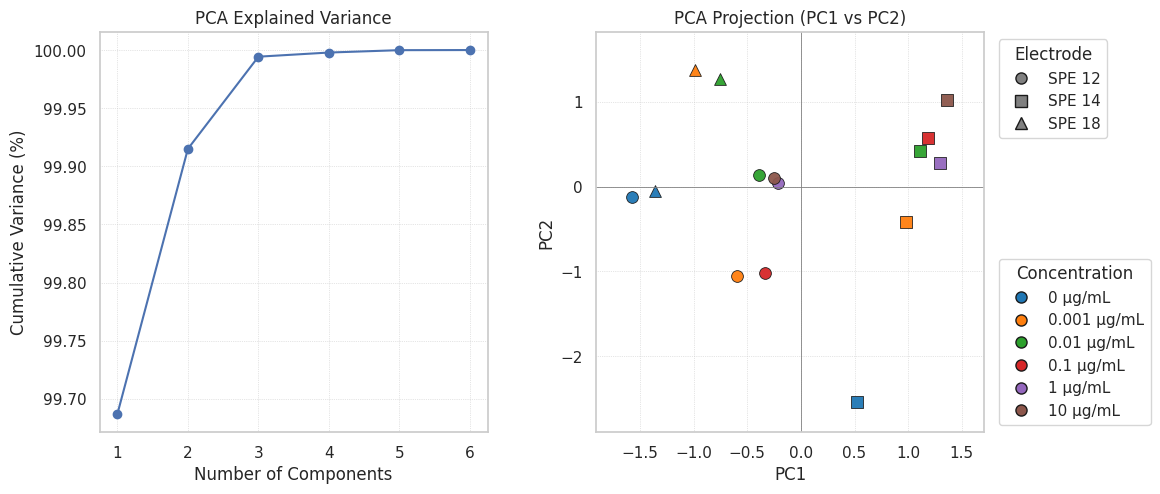

           PC1    PC2    PC3    PC4    PC5    PC6
9.5 Hz   0.996 -0.057 -0.066 -0.014  0.021 -0.004
19.1 Hz  0.047  0.782  0.215  0.050  0.575 -0.082
28.6 Hz  0.052 -0.028  0.832 -0.458 -0.261 -0.162
38.1 Hz  0.038  0.417  0.019  0.002 -0.466  0.779
47.7 Hz  0.019 -0.341  0.504  0.674  0.262  0.325
57.2 Hz  0.039  0.307  0.051  0.577 -0.561 -0.504


In [253]:
# Target FFT peak freqs (Hz)
DESIRED = [9.50, 19.10, 28.60, 38.10, 47.70, 57.20]
tol = 0.2  # tolerance in Hz

# Extract numeric freq from column name
def extract_freq(col):
    m = re.search(r"(\d+(?:\.\d+)?)", str(col))
    return float(m.group(1)) if m else None

# Pick closest cols to target freqs
if "feature_df" not in globals():
    raise NameError("feature_df not found.")
col_freqs = {c: extract_freq(c) for c in feature_df.columns}
FREQ_COLS = []
for f in DESIRED:
    cands = [c for c in feature_df.columns
             if col_freqs.get(c) is not None and abs(col_freqs[c]-f) <= tol]
    if not cands:
        raise KeyError(f"No column within ±{tol} Hz of {f} Hz.")
    FREQ_COLS.append(sorted(cands, key=lambda c: abs(col_freqs[c]-f))[0])

# Build matrices
X = feature_df[FREQ_COLS].to_numpy()
y = pd.to_numeric(feature_df["Concentration"], errors="coerce").to_numpy()
elec = feature_df["Electrode"].astype(str).to_numpy()

# Drop NaNs
mask = (~np.isnan(X).any(axis=1)) & (~np.isnan(y))
X, y, elec = X[mask], y[mask], elec[mask]
if X.shape[0] < 2 or X.shape[1] < 2:
    raise ValueError("Need at least 2 samples and 2 features.")

# Run PCA on raw features
n_comp = int(min(6, X.shape[0], X.shape[1]))
pca = PCA(n_components=n_comp)
Xp = pca.fit_transform(X)
evr = pca.explained_variance_ratio_

# Only z-scale PCs for plotting clarity
pc_std = np.std(Xp[:, :2], axis=0, ddof=1); pc_std[pc_std == 0] = 1.0
Xp_plot = Xp[:, :2] / pc_std

# Plots
fig, ax = plt.subplots(1, 2, figsize=(13.5, 5.2), constrained_layout=False)

# Explained variance
ax[0].plot(np.arange(1, n_comp+1), np.cumsum(evr)*100, marker='o')
ax[0].set_title("PCA Explained Variance")
ax[0].set_xlabel("Number of Components"); ax[0].set_ylabel("Cumulative Variance (%)")
ax[0].grid(True, linestyle=":", linewidth=0.5)

# Scatter: color = conc, marker = electrode
palette = plt.cm.tab10.colors
conc_levels = [0.0, 0.001, 0.01, 0.1, 1.0, 10.0]
present = [c for c in conc_levels if c in set(y)]
markers = {"SPE 12":"o", "SPE 14":"s", "SPE 18":"^"}

for i, c in enumerate(present):
    for e in np.unique(elec):
        m = (y == c) & (elec == e)
        if np.any(m):
            ax[1].scatter(Xp_plot[m,0], Xp_plot[m,1],
                          c=[palette[i % len(palette)]],
                          marker=markers.get(e,"o"),
                          s=72, edgecolor="k", linewidths=0.6, alpha=0.95)

ax[1].set_title("PCA Projection (PC1 vs PC2)")
ax[1].set_xlabel(f"PC1")
ax[1].set_ylabel(f"PC2")
ax[1].grid(True, linestyle=":", linewidth=0.5)
ax[1].axhline(0, color="grey", lw=0.6); ax[1].axvline(0, color="grey", lw=0.6)

# Add padding to avoid cut points
def padded_limits(v, pad_frac=0.12):
    a, b = np.percentile(v, [0.5, 99.5]); rng = b-a if b>a else 1.0
    pad = max(rng*pad_frac, 0.25)
    return a-pad, b+pad
ax[1].set_xlim(*padded_limits(Xp_plot[:,0]))
ax[1].set_ylim(*padded_limits(Xp_plot[:,1]))
ax[1].margins(0.05)

# Legends outside plot
elec_handles = [Line2D([0],[0], marker=markers.get(e,"o"), color="w",
                       markerfacecolor="grey", markeredgecolor="k",
                       markersize=8, linestyle="None", label=e)
                for e in ["SPE 12","SPE 14","SPE 18"] if e in set(elec)]
conc_handles = [Line2D([0],[0], marker="o", color="w",
                       markerfacecolor=palette[i % len(palette)],
                       markeredgecolor="k", markersize=8, linestyle="None",
                       label=f"{c:g} µg/mL")
                for i, c in enumerate(present)]
leg1 = ax[1].legend(handles=elec_handles, title="Electrode",
                    bbox_to_anchor=(1.02, 1), loc="upper left")
ax[1].add_artist(leg1)
ax[1].legend(handles=conc_handles, title="Concentration",
             bbox_to_anchor=(1.02, 0), loc="lower left")
plt.subplots_adjust(right=0.78, wspace=0.28)
plt.show()

# Loadings (feature contribution)
loadings = pd.DataFrame(pca.components_.T,
                        index=FREQ_COLS,
                        columns=[f"PC{i+1}" for i in range(n_comp)])
print(loadings.round(3))


# **## Heatmap of FFT ****

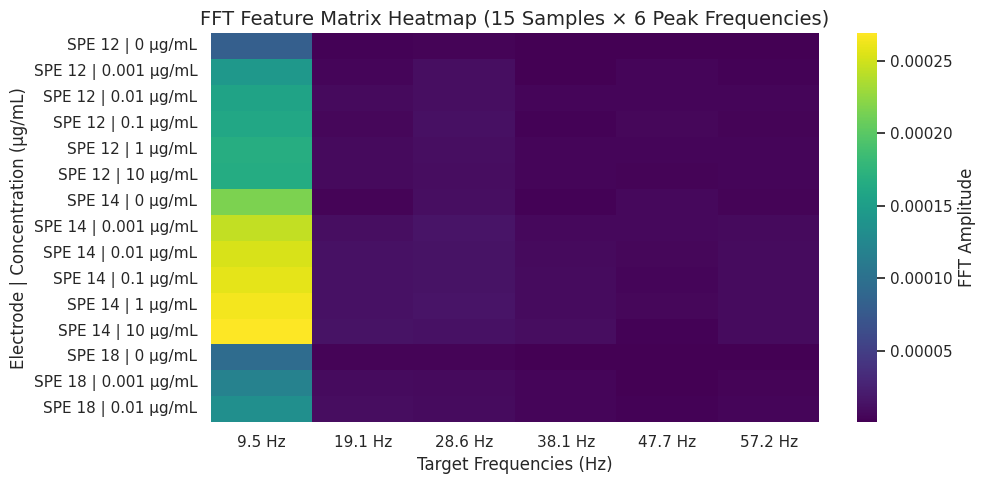

In [254]:
# Heatmap of the FFT feature matrix
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.heatmap(feature_df.iloc[:, :6], cmap="viridis", annot=False, cbar_kws={'label': 'FFT Amplitude'})
plt.title("FFT Feature Matrix Heatmap (15 Samples × 6 Peak Frequencies)", fontsize=14)
plt.xlabel("Target Frequencies (Hz)")
plt.ylabel("Electrode | Concentration (µg/mL)")
plt.tight_layout()
plt.show()

# **### PCA of FFT Features by Electrode**

I am using Principal Component Analysis (PCA) to reduce my FFT feature space into two main components.  
This helps me see how different electrodes separate based on their frequency-domain patterns.  
Each point represents one sample, positioned by its principal components, and is coloured according to the electrode type.


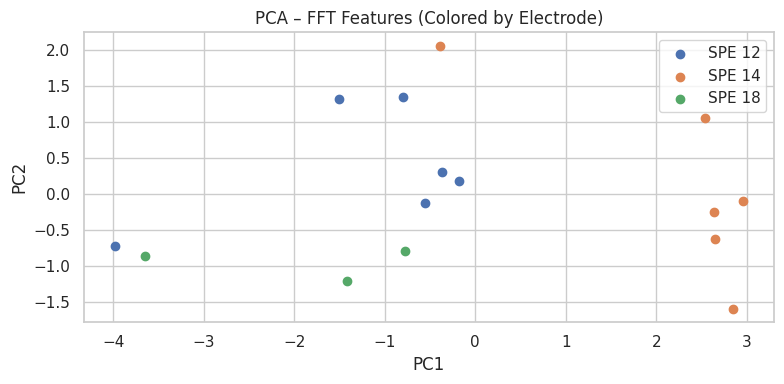

In [255]:
# I scale the features before PCA
X_scaled = StandardScaler().fit_transform(X)

# I apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# I prepare the PCA result for plotting
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Electrode"] = label_df["electrode"]
pca_df["Concentration"] = label_df["concentration"]

# I plot the PCA results colored by electrode
plt.figure(figsize=(8, 4))
for elec in pca_df["Electrode"].unique():
    subset = pca_df[pca_df["Electrode"] == elec]
    plt.scatter(subset["PC1"], subset["PC2"], label=elec)
plt.title("PCA – FFT Features (Colored by Electrode)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **### PCA of FFT Features by Concentration**

I am using Principal Component Analysis (PCA) to see how samples group according to their Galectin-3 concentration.  
Each point represents a sample in the reduced two-dimensional PCA space, and is coloured based on its concentration level.  
This view helps check whether different concentrations form distinct clusters in the frequency-domain feature space.


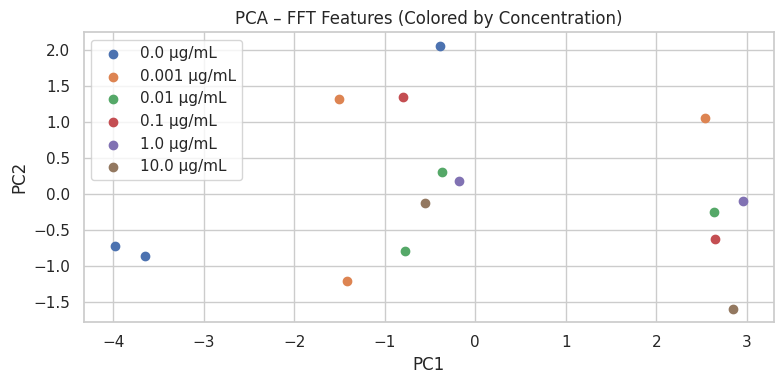

In [256]:
# I plot the PCA results colored by concentration
plt.figure(figsize=(8, 4))
for conc in sorted(pca_df["Concentration"].unique()):
    subset = pca_df[pca_df["Concentration"] == conc]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"{conc} µg/mL")
plt.title("PCA – FFT Features (Colored by Concentration)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# **## PCA of Peak Current Responses Across Electrodes**

In this analysis, Principal Component Analysis (PCA) was applied to explore the variation in **peak current responses** across multiple **electrodes** for different **Galectin-3 concentrations**.

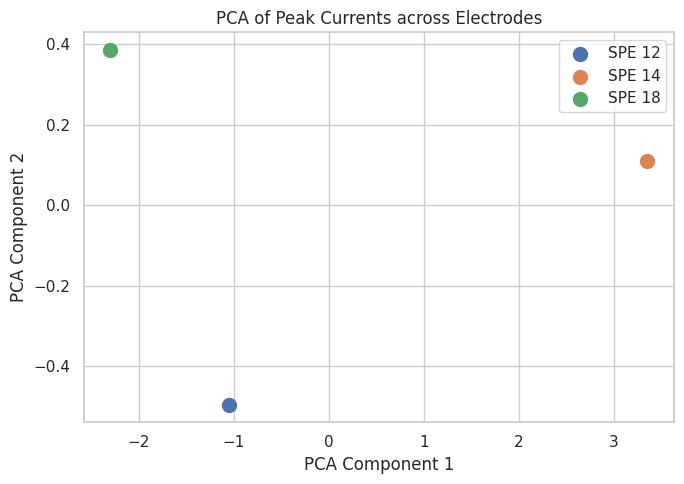

In [257]:
# Initialize a list to store peak data
peak_data = []

# Loop through each electrode and concentration in the filtered data
for electrode in filtered_data:
    for conc, data in filtered_data[electrode].items():
        # Extract voltage and current data
        voltage = np.array(data["voltage"]["voltage"])
        current = np.array(data["current"]["current"])

        # Find peaks in the current signal
        peaks, _ = find_peaks(current)

        # If peaks are found, find the highest peak
        if len(peaks) > 0:
            peak_index = peaks[np.argmax(current[peaks])]
            peak_voltage = voltage[peak_index]
            peak_current = current[peak_index]

            # Append the extracted data to the list
            peak_data.append({
                "Electrode": electrode,
                "Concentration (µg/mL)": conc,
                "Peak Voltage (V)": peak_voltage,
                "Peak Current (µA)": peak_current
            })
        else:
            # Append None or NaN if no peak is found
            peak_data.append({
                "Electrode": electrode,
                "Concentration (µg/mL)": conc,
                "Peak Voltage (V)": np.nan,
                "Peak Current (µA)": np.nan
            })

# Convert the list of dictionaries into a pandas DataFrame
peak_df = pd.DataFrame(peak_data)

# Create a matrix: rows = electrodes, columns = concentrations, values = peak currents
peak_matrix = peak_df.pivot_table(
    index='Electrode',
    columns='Concentration (µg/mL)',
    values='Peak Current (µA)'
)

# Fill missing values (if any) with row-wise mean for that electrode
peak_matrix_filled = peak_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

# Standardize the peak current values for fair PCA (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(peak_matrix_filled)

# Apply PCA to reduce dimensions to 2 for visual analysis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a new DataFrame with PCA results and electrode labels
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Electrode"] = peak_matrix_filled.index

# Plot the PCA result: each point represents an electrode
plt.figure(figsize=(7, 5))
for i in range(len(pca_df)):
    plt.scatter(pca_df["PC1"][i], pca_df["PC2"][i], label=pca_df["Electrode"][i], s=100)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Peak Currents across Electrodes")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# **### PCA Loadings – Frequency Contributions**

I plotted the PCA loadings to see which frequencies contribute most to PC1 and PC2.  
This helps me understand which parts of the FFT signal are important for separating concentrations.

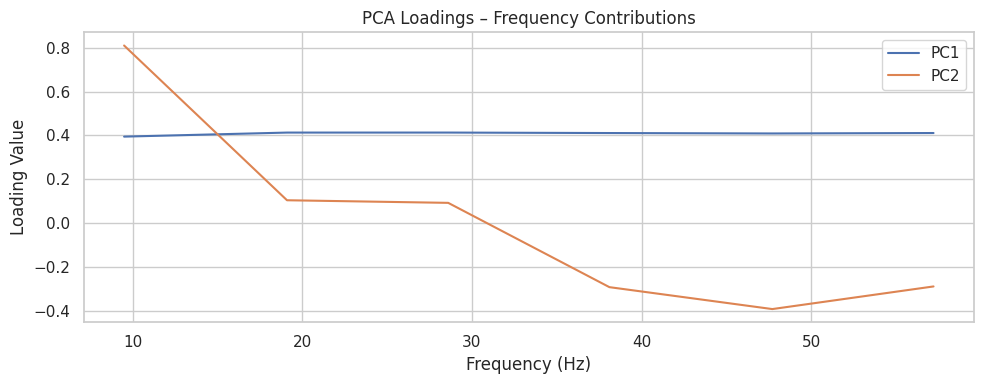

In [258]:
# I get the loadings (contribution of each frequency to PCs)
loadings = pca.components_.T

# I define the frequency axis using the target frequencies
freq_axis = target_freqs # Use the same frequencies used for feature extraction

# I create the plot
plt.figure(figsize=(10, 4))

# I plot PC1 loadings
plt.plot(freq_axis, loadings[:, 0], label="PC1")

# I plot PC2 loadings
plt.plot(freq_axis, loadings[:, 1], label="PC2")

# I add titles and labels
plt.title("PCA Loadings – Frequency Contributions")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Loading Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **### Peak Current vs Concentration for Different Electrodes**

This plot shows how each electrode (SPE12, SPE14, and SPE18) responded to different concentrations of Galectin-3.  
For every concentration, the peak current recorded by each electrode is shown side by side, making it easy to compare their performance.


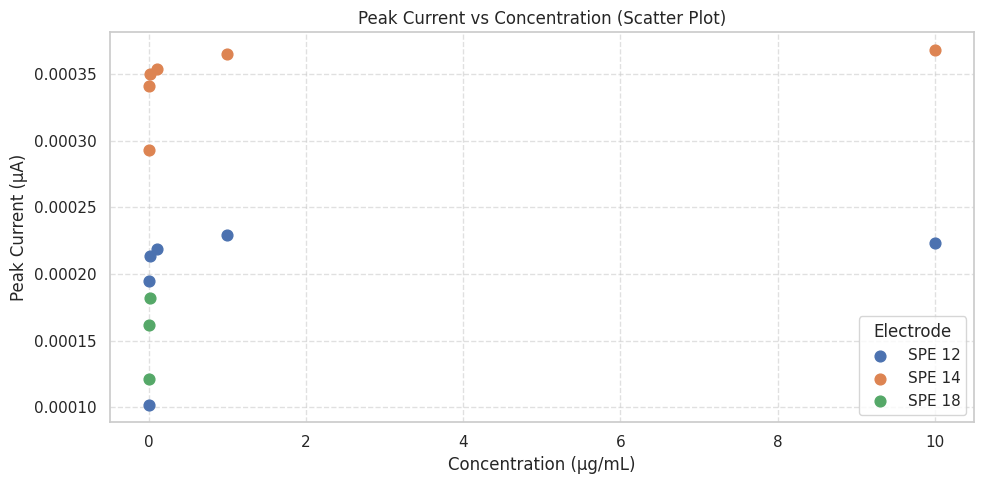

In [259]:
from scipy.signal import find_peaks

#  Extract peak data
peak_data = []

for electrode in filtered_data:
    for conc, data in filtered_data[electrode].items():
        voltage = np.array(data["voltage"]["voltage"])
        current = np.array(data["current"]["current"])

        # Find peaks
        peaks, _ = find_peaks(current)
        if len(peaks) > 0:
            peak_index = peaks[np.argmax(current[peaks])]
            peak_voltage = voltage[peak_index]
            peak_current = current[peak_index]
        else:
            peak_voltage = np.nan
            peak_current = np.nan

        peak_data.append({
            "Electrode": electrode,
            "Concentration (µg/mL)": float(conc),
            "Peak Voltage (V)": peak_voltage,
            "Peak Current (µA)": peak_current
        })

# Convert to DataFrame
peak_df = pd.DataFrame(peak_data)

# Create scatter plot
plt.figure(figsize=(10, 5))

# Plot each electrode's data as a separate scatter series
for electrode in peak_df["Electrode"].unique():
    subset = peak_df[peak_df["Electrode"] == electrode]
    plt.scatter(subset["Concentration (µg/mL)"],
                subset["Peak Current (µA)"],
                label=electrode, s=60)

# Label axes and add title
plt.xlabel("Concentration (µg/mL)")
plt.ylabel("Peak Current (µA)")
plt.title("Peak Current vs Concentration (Scatter Plot)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Electrode")
plt.tight_layout()
plt.show()


# **### Calibration Curves: Faradaic Peak Current vs. Galectin-3 Concentration**

I am now plotting how the Faradaic peak current changes with Galectin-3 concentration for each electrode. This helps me evaluate the linearity and sensitivity of each biosensor. The plot is based on raw data.

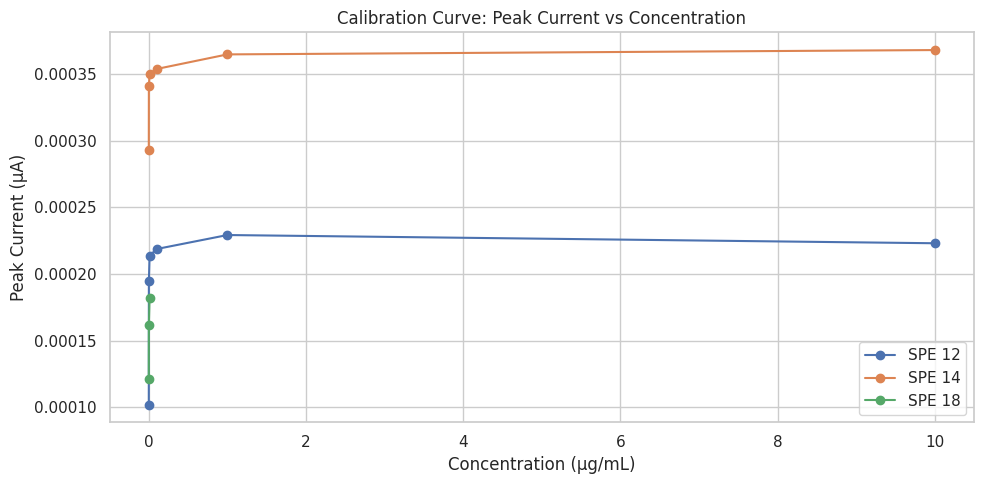

In [260]:
# I create a plot to show peak current vs concentration for each electrode
plt.figure(figsize=(10, 5))

# I plot a line for each electrode
for electrode in peak_df['Electrode'].unique():
    df_elec = peak_df[peak_df['Electrode'] == electrode].sort_values(by='Concentration (µg/mL)')

    # Extract concentrations and peak currents
    concs = df_elec['Concentration (µg/mL)']
    currents = df_elec['Peak Current (µA)']

    # Plot the line
    plt.plot(concs, currents, marker='o', label=electrode)

# Add labels and title
plt.xlabel('Concentration (µg/mL)')
plt.ylabel('Peak Current (µA)')
plt.title('Calibration Curve: Peak Current vs Concentration')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# **### Calibration Curve on Logarithmic Scale (Peak Current vs Concentration)**

In this section, I plot the calibration curve for each electrode, showing the relationship between peak current (µA) and analyte concentration (µg/mL) on a **logarithmic concentration scale**.  
This transformation is useful in electrochemical biosensor studies, as it often improves linearity at lower concentration ranges and enables better visualization of data across multiple orders of magnitude.

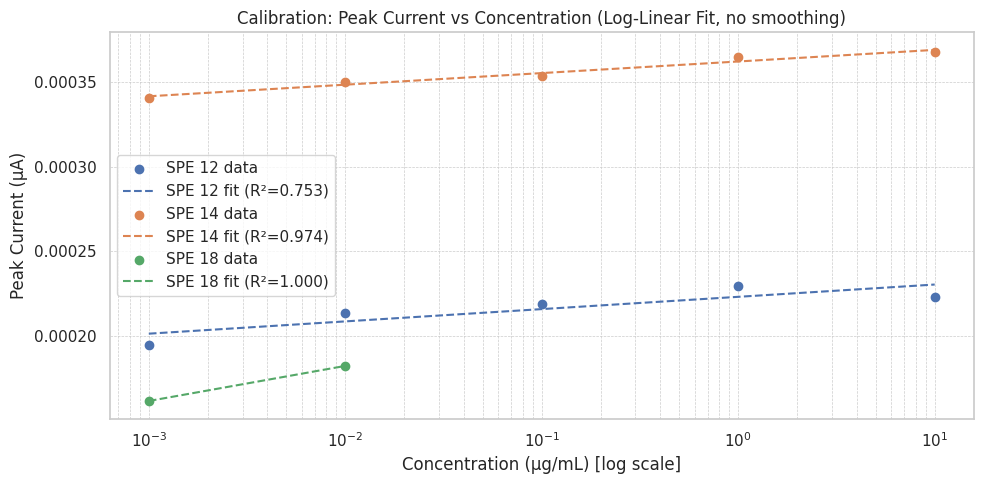

In [261]:
from sklearn.metrics import r2_score

plt.figure(figsize=(10, 5))

for electrode in peak_df['Electrode'].unique():
    df_elec = peak_df[peak_df['Electrode'] == electrode].copy()

    # Use only positive, finite values (log-scale needs > 0)
    df_elec = df_elec.replace([np.inf, -np.inf], np.nan).dropna(
        subset=['Concentration (µg/mL)', 'Peak Current (µA)']
    )
    df_elec = df_elec[df_elec['Concentration (µg/mL)'] > 0]

    if df_elec.empty:
        continue

    # Sort by concentration for clean plotting
    df_elec = df_elec.sort_values('Concentration (µg/mL)')
    concs = df_elec['Concentration (µg/mL)'].to_numpy(dtype=float)
    currents = df_elec['Peak Current (µA)'].to_numpy(dtype=float)

    # Scatter actual data
    plt.scatter(concs, currents, label=f"{electrode} data")

    # Fit on log10(concentration) only if >=2 unique points
    if np.unique(concs).size >= 2:
        log_concs = np.log10(concs)
        slope, intercept = np.polyfit(log_concs, currents, 1)

        # Predict ONLY at actual concentrations
        y_pred = slope * log_concs + intercept
        r2 = r2_score(currents, y_pred)

        # Connect the predicted points at actual x positions
        plt.plot(concs, y_pred, linestyle='--', label=f"{electrode} fit (R²={r2:.3f})")

plt.xscale('log')
plt.xlabel('Concentration (µg/mL) [log scale]')
plt.ylabel('Peak Current (µA)')
plt.title('Calibration: Peak Current vs Concentration (Log-Linear Fit, no smoothing)')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()


# **### Log-Transformed Calibration Curves for Each Electrode**

I plotted the calibration curves using log₁₀(Concentration + 1) on the x-axis and Peak Current (µA) on the y-axis.  
This transformation helps to visualize the sensor’s performance over a wide concentration range and is commonly used for biosensors.  
I also fitted a linear regression line on the log-transformed data to assess how well the current correlates with the logarithmic concentration.  
The R² values indicate how well each electrode responds to the change in Galectin-3 concentration.

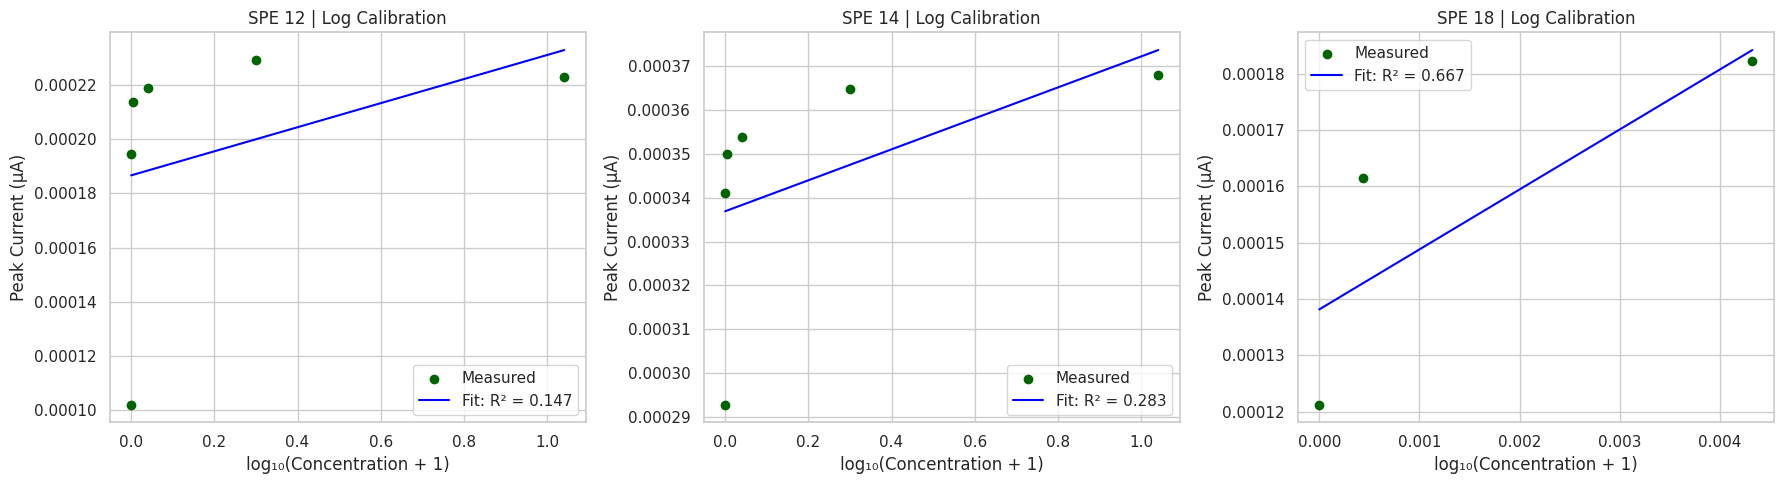

In [262]:
# Start plotting: one calibration curve per electrode
plt.figure(figsize=(18, 5))

# Loop through each unique electrode
for i, electrode in enumerate(peak_df['Electrode'].unique()):

    # Filter the data for this electrode
    df = peak_df[peak_df['Electrode'] == electrode]

    # Apply log10 transformation to the concentration values
    X_log = np.log10(df['Concentration (µg/mL)'] + 1).values.reshape(-1, 1)

    # Peak current values as the response variable
    Y = df['Peak Current (µA)'].values

    # Fit a linear regression model on the log-transformed data
    model = LinearRegression()
    model.fit(X_log, Y)
    Y_pred = model.predict(X_log)

    # Calculate the R² score to evaluate goodness of fit
    r2 = r2_score(Y, Y_pred)

    # Create a subplot for this electrode
    plt.subplot(1, len(peak_df['Electrode'].unique()), i + 1)

    # Plot actual data points
    plt.scatter(X_log, Y, color='darkgreen', label='Measured')

    # Plot regression line
    plt.plot(X_log, Y_pred, color='blue', linestyle='-', label=f'Fit: R² = {r2:.3f}')


    # Set axis labels and title
    plt.xlabel("log₁₀(Concentration + 1)")
    plt.ylabel("Peak Current (µA)")
    plt.title(f"{electrode} | Log Calibration")
    plt.grid(True)
    plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# **## Faradaic vs Non-Faradaic Current (SPE 12 | 0 µg/mL)**

I plotted the raw CV curve and estimated the non-faradaic baseline using a straight line between the first and last current points.  
Then I subtracted this baseline to get the faradaic current.  
All three curves—raw, baseline, and faradaic—are shown for comparison.


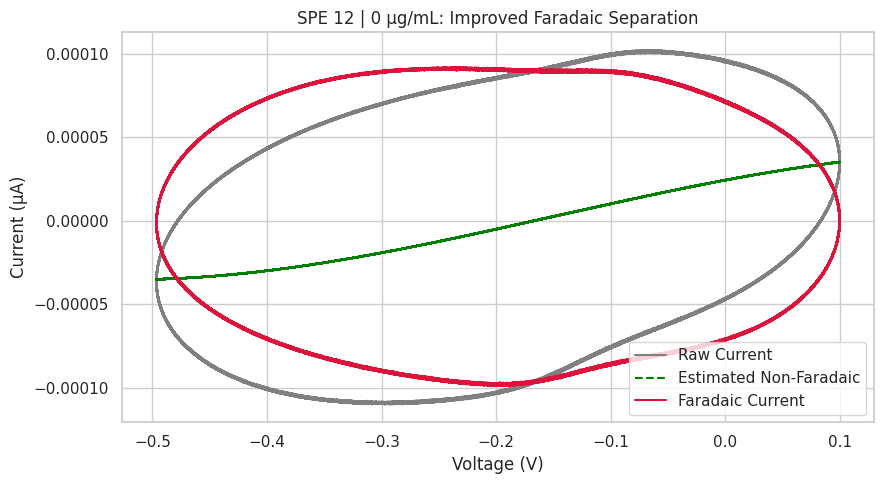

In [263]:
# I select the electrode and concentration
electrode = "SPE 12"
conc = 0

# I extract voltage and current values
voltage = np.array(filtered_data[electrode][conc]["voltage"]["voltage"])
current = np.array(filtered_data[electrode][conc]["current"]["current"])

# I fit a 3rd-degree polynomial to estimate the non-faradaic baseline
baseline_fit = np.polyfit(voltage, current, deg=3)
non_faradaic_baseline = np.polyval(baseline_fit, voltage)

# I subtract the baseline to isolate the faradaic current
faradaic_current = current - non_faradaic_baseline

# I plot raw current, estimated baseline, and faradaic current
plt.figure(figsize=(9, 5))
plt.plot(voltage, current, label="Raw Current", color='gray')
plt.plot(voltage, non_faradaic_baseline, label="Estimated Non-Faradaic", linestyle='--', color='green')
plt.plot(voltage, faradaic_current, label="Faradaic Current", color='crimson')
plt.title(f"{electrode} | {conc} µg/mL: Improved Faradaic Separation")
plt.xlabel("Voltage (V)")
plt.ylabel("Current (µA)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **### Faradaic Charge Calculation**

I calculated Faradaic charge by baseline correcting current and integrating over time for each electrode at 0 µg/mL.


In [264]:
# I select the electrodes to analyze
electrodes_to_analyze = ["SPE 12", "SPE 14", "SPE 18"]
conc = 0  # µg/mL

# Loop through each electrode
for electrode in electrodes_to_analyze:
    # Check if electrode and concentration exist in filtered_data
    if electrode in filtered_data and conc in filtered_data[electrode]:
        # I extract voltage and current
        voltage = np.array(filtered_data[electrode][conc]["voltage"]["voltage"])
        current = np.array(filtered_data[electrode][conc]["current"]["current"])

        # I estimate and subtract non-faradaic baseline
        if current.size > 0:
            baseline_start = current[0]
            baseline_end = current[-1]
            non_faradaic_baseline = np.linspace(baseline_start, baseline_end, len(current))
            faradaic_current = current - non_faradaic_baseline

            # I now calculate the area under Faradaic current using trapezoidal integration
            # I also extract the time column for integration
            time = np.array(filtered_data[electrode][conc]["current"]["time"])

            # Ensure time array is not empty and has the same size as faradaic_current for integration
            if time.size > 0 and time.size == faradaic_current.size:
                # I calculate the total Faradaic charge (in microcoulombs)
                faradaic_charge = np.trapz(faradaic_current, x=time)

                # I display the result
                print(f"Faradaic Charge for {electrode} at {conc} µg/mL: {faradaic_charge:.4f} µC")
            else:
                print(f"Skipping integration for {electrode} at {conc} µg/mL: Time or current data is empty or sizes do not match.")
        else:
            print(f"Skipping baseline subtraction and integration for {electrode} at {conc} µg/mL: Current data is empty.")
    else:
        print(f"Skipping {electrode} at {conc} µg/mL: Data not found in filtered_data.")

Faradaic Charge for SPE 12 at 0 µg/mL: -0.0004 µC
Faradaic Charge for SPE 14 at 0 µg/mL: -0.0010 µC
Faradaic Charge for SPE 18 at 0 µg/mL: -0.0005 µC


# **### Visualizing the Faradaic Region from CV Curves**

I am now plotting the raw CV curve for one electrode and concentration, and marking the Faradaic region. This region is centered around the peak current, where the oxidation or reduction occurs. I will use this to focus only on electrochemical response.


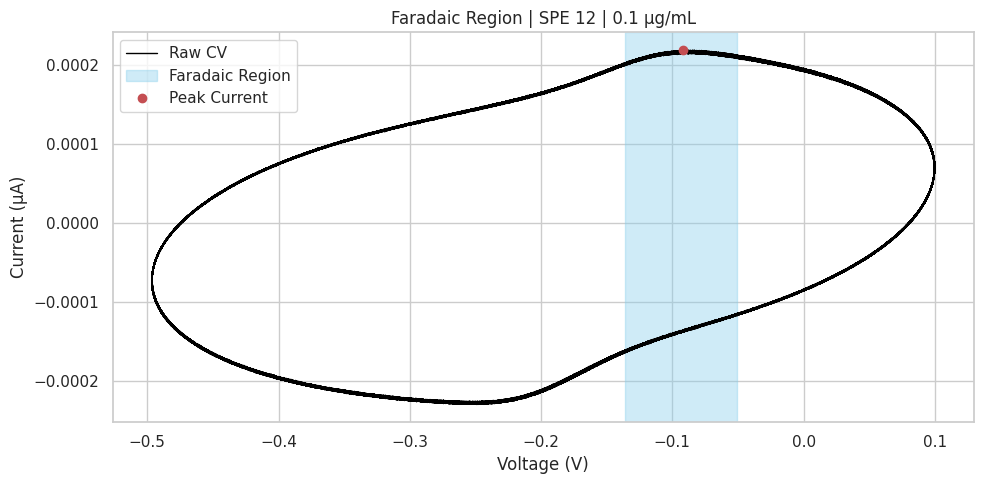

In [265]:
# I import peak detection function
from scipy.signal import find_peaks

# I choose  electrode and concentration
electrode = "SPE 12"
concentration = 0.1  # µg/mL

# I extract voltage and current data
voltage = np.array(filtered_data[electrode][concentration]["voltage"]["voltage"])
current = np.array(filtered_data[electrode][concentration]["current"]["current"])

# I find peaks in the current
peaks, _ = find_peaks(current)

# I get the highest peak
if len(peaks) > 0:
    peak_index = peaks[np.argmax(current[peaks])]
    faradaic_start = max(0, peak_index - 100)
    faradaic_end = min(len(current), peak_index + 100)

    # I plot full CV curve
    plt.figure(figsize=(10, 5))
    plt.plot(voltage, current, label="Raw CV", color="black", linewidth=1)

    # I highlight the Faradaic region
    plt.axvspan(voltage[faradaic_start], voltage[faradaic_end], color="skyblue", alpha=0.4, label="Faradaic Region")

    # I mark the peak point
    plt.plot(voltage[peak_index], current[peak_index], 'ro', label="Peak Current")

    plt.title(f"Faradaic Region | {electrode} | {concentration} µg/mL")
    plt.xlabel("Voltage (V)")
    plt.ylabel("Current (µA)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No peak found in the current signal for this electrode and concentration.")


# **### Extracting Faradaic Region from All CV Curves**

I am now looping over all electrodes and concentrations. For each one, I find the main electrochemical peak and extract a small window (typically ±100 points) around that peak. This window represents the Faradaic region where redox reactions occur. This data will be used for signal extraction and calibration analysis.


In [266]:
# I import peak detection again
from scipy.signal import find_peaks

# I create a new dictionary to store only Faradaic-region data
faradaic_data = {}

# I loop through all electrodes in my filtered_data
for electrode in filtered_data:

    # I initialize a nested dictionary for this electrode
    faradaic_data[electrode] = {}

    # I loop through all concentrations available for this electrode
    for conc, data in filtered_data[electrode].items():

        # I extract voltage and current
        voltage = np.array(data["voltage"]["voltage"])
        current = np.array(data["current"]["current"])

        # I find all peaks
        peaks, _ = find_peaks(current)

        # I continue only if at least one peak is found
        if len(peaks) > 0:
            # I find the peak with the maximum current
            peak_index = peaks[np.argmax(current[peaks])]

            # I define a window of ±100 points around the peak
            start = max(0, peak_index - 100)
            end = min(len(current), peak_index + 100)

            # I slice voltage and current within the Faradaic window
            voltage_faradaic = voltage[start:end]
            current_faradaic = current[start:end]

            # I store it in the faradaic_data dictionary
            faradaic_data[electrode][conc] = {
                "voltage": voltage_faradaic,
                "current": current_faradaic
            }

# I print confirmation
print(" Faradaic region data extracted for all available CVs.")


 Faradaic region data extracted for all available CVs.


# **###  (B/A) Ratio Distribution by Electrode Type**

In this step, I extracted statistical features (like mean, standard deviation, max, and min current) from each filtered current dataset. I also recorded the time at which the maximum and minimum current occurred.

To compare how different electrodes behave, I calculated the B/A ratio by dividing the peak (B) current by the absolute value of the minimum (A) current. Then, I used a **violin plot** to visualize how the B/A ratio is distributed across different electrode types. This helped me understand which electrodes give more stable or varied responses when detecting Galectin-3.


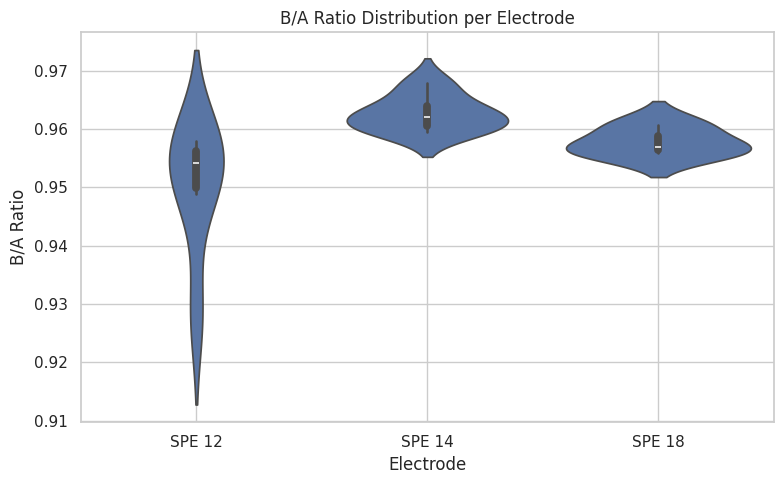

In [267]:
# Create lists to store extracted features, concentration labels, and electrode types
all_features_list = []
all_labels_list = []
all_electrodes_list = []

# Loop through each electrode and concentration to extract features
for electrode in filtered_data:
    for conc, data in filtered_data[electrode].items():
        current_df = data["current"]

        # Skip if current data is empty
        if current_df.empty:
            continue

        # Extract useful statistical features from current values
        mean_current = np.mean(current_df["current"])
        std_current = np.std(current_df["current"])
        max_current = np.max(current_df["current"])
        min_current = np.min(current_df["current"])
        time_at_max = current_df["time"].iloc[np.argmax(current_df["current"])]
        time_at_min = current_df["time"].iloc[np.argmin(current_df["current"])]

        # Append the features, concentration, and electrode type
        all_features_list.append([mean_current, std_current, max_current, min_current, time_at_max, time_at_min])
        all_labels_list.append(conc)
        all_electrodes_list.append(electrode)

# Define feature names and create a DataFrame
feature_names = ["mean_current", "std_current", "max_current", "min_current", "time_at_max", "time_at_min"]
df_full_features = pd.DataFrame(all_features_list, columns=feature_names)

# Add target concentration and electrode name columns
df_full_features["concentration"] = all_labels_list
df_full_features["electrode_type"] = all_electrodes_list

# Calculate B/A ratio: B = max current, A = min current (absolute)
epsilon = 1e-9  # small constant to prevent division by zero
df_full_features['BA_ratio'] = df_full_features['max_current'] / (np.abs(df_full_features['min_current']) + epsilon)

# Import seaborn for plotting
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.violinplot(data=df_full_features, x='electrode_type', y='BA_ratio')
plt.title('B/A Ratio Distribution per Electrode')
plt.xlabel('Electrode')
plt.ylabel('B/A Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()

# **###  (B – A) Current Difference per Electrode**

In this step, I calculated the B – A value by subtracting the minimum current (A) from the maximum current (B) for each measurement. This gives a simple and direct measure of the total current response.

Then, I used a violin plot to visualize how the B – A difference varies across different electrode types. This helps me compare which electrode gives a stronger and more consistent signal for Galectin-3 detection.


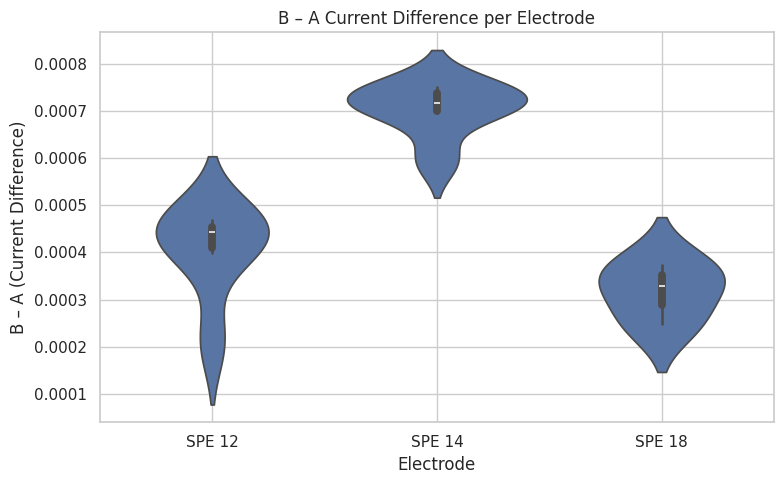

In [268]:
# Calculate B - A (max - min current)
df_full_features['BA_difference'] = df_full_features['max_current'] - df_full_features['min_current']

plt.figure(figsize=(8, 5))
sns.violinplot(data=df_full_features, x='electrode_type', y='BA_difference')
plt.title('B – A Current Difference per Electrode')
plt.xlabel('Electrode')
plt.ylabel('B – A (Current Difference)')
plt.grid(True)
plt.tight_layout()
plt.show()


# **### Faradaic Region CV Plots**

I plotted the CV curves focusing on the Faradaic voltage range (-0.2 V to 0.2 V) for each electrode at the lowest concentration.  
Each subplot shows the current response in this important voltage window, helping to compare Faradaic activity side-by-side.


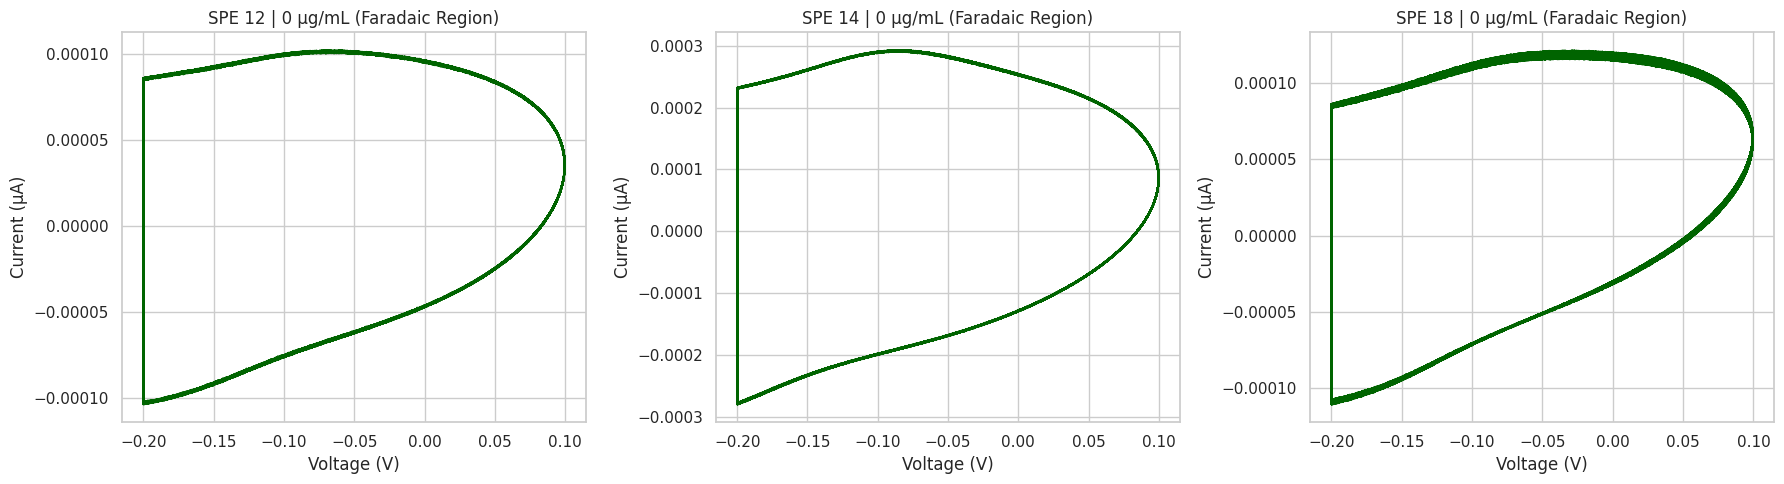

In [269]:
# I create a new figure for side-by-side Faradaic region plots
plt.figure(figsize=(18, 5))

# I define the Faradaic voltage range (in volts)
faradaic_min = -0.2
faradaic_max = 0.2

# I loop through each electrode to plot the real Faradaic region CV curves
for i, electrode in enumerate(filtered_data.keys()):
    if electrode not in filtered_data:
        continue

    # I select the lowest concentration for each electrode
    conc = sorted(filtered_data[electrode].keys())[0]
    voltage = np.array(filtered_data[electrode][conc]["voltage"]["voltage"])
    current = np.array(filtered_data[electrode][conc]["current"]["current"])

    # I create a mask for the Faradaic voltage range
    mask = (voltage >= faradaic_min) & (voltage <= faradaic_max)
    voltage_faradaic = voltage[mask]
    current_faradaic = current[mask]

    # I create a subplot for this electrode
    plt.subplot(1, 3, i + 1)
    plt.plot(voltage_faradaic, current_faradaic, color='darkgreen', linewidth=1.3)
    plt.title(f"{electrode} | {conc} µg/mL (Faradaic Region)", fontsize=12)
    plt.xlabel("Voltage (V)")
    plt.ylabel("Current (µA)")
    plt.grid(True)

# I adjust the layout and display the final side-by-side plot
plt.tight_layout()
plt.show()


# **### Faradaic Peak Current and Voltage Table**

This table shows the Faradaic peak current (in µA) and the corresponding voltage (in V) for each electrode and each concentration. These values were extracted from the raw cyclic voltammetry data.


In [270]:
# Initialize a list to store peak data
peak_data = []

# Loop through each electrode and concentration in the filtered data
for electrode in filtered_data:
    for conc, data in filtered_data[electrode].items():
        # Extract voltage and current data
        voltage = np.array(data["voltage"]["voltage"])
        current = np.array(data["current"]["current"])

        # Find peaks in the current signal
        peaks, _ = find_peaks(current)

        # If peaks are found, find the highest peak
        if len(peaks) > 0:
            peak_index = peaks[np.argmax(current[peaks])]
            peak_voltage = voltage[peak_index]
            peak_current = current[peak_index]

            # Append the extracted data to the list
            peak_data.append({
                "Electrode": electrode,
                "Concentration (µg/mL)": conc,
                "Peak Voltage (V)": peak_voltage,
                "Peak Current (µA)": peak_current
            })
        else:
            # Append None or NaN if no peak is found
            peak_data.append({
                "Electrode": electrode,
                "Concentration (µg/mL)": conc,
                "Peak Voltage (V)": np.nan,
                "Peak Current (µA)": np.nan
            })

# Convert the list of dictionaries into a pandas DataFrame
peak_df = pd.DataFrame(peak_data)

# I display the full table of peak current and voltage values
display(peak_df)

Electrode  Concentration (µg/mL)  Peak Voltage (V)  Peak Current (µA)
0     SPE 12                  0.000         -0.058738           0.000102
1     SPE 12                  0.001         -0.094027           0.000195
2     SPE 12                  0.010         -0.071348           0.000214
3     SPE 12                  0.100         -0.091722           0.000219
4     SPE 12                  1.000         -0.067375           0.000229
5     SPE 12                 10.000         -0.069527           0.000223
6     SPE 14                  0.000         -0.081520           0.000293
7     SPE 14                  0.001         -0.062780           0.000341
8     SPE 14                  0.010         -0.059872           0.000350
9     SPE 14                  0.100         -0.048652           0.000354
10    SPE 14                  1.000         -0.055857           0.000365
11    SPE 14                 10.000         -0.042299           0.000368
12    SPE 18                  0.000         -0.028829           0.000121
13    SPE 18                  0.001         -0.064374           0.000162
14    SPE 18                  0.010         -0.059383           0.000182

# **### Linear Regression for Calibration Curves**

I am now applying linear regression to fit a line to each electrode’s calibration curve (peak current vs. concentration). This helps me calculate the sensitivity (slope) and goodness of fit (R²) for each sensor, based on real Faradaic peak currents.


SPE 12: y = 0.0000x + 0.0002 | R² = 0.095
SPE 14: y = 0.0000x + 0.0003 | R² = 0.207
SPE 18: y = 0.0046x + 0.0001 | R² = 0.667


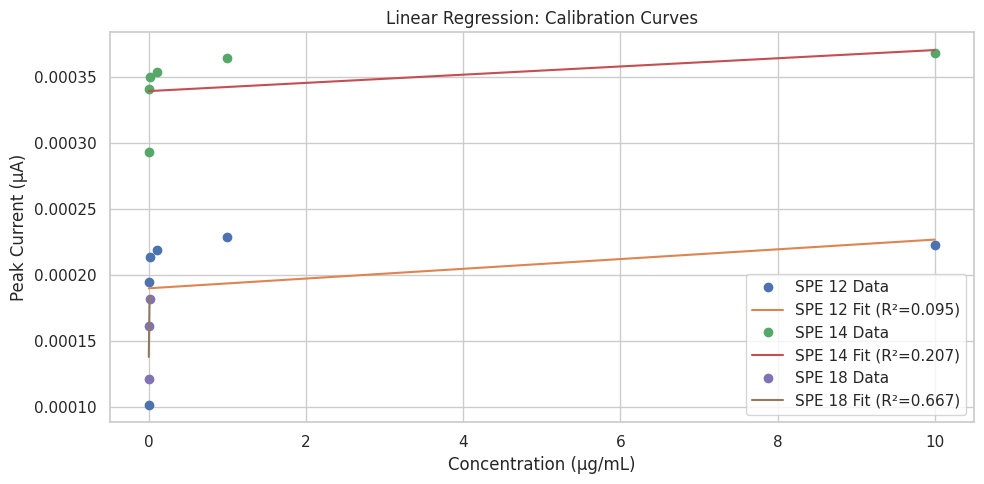

In [271]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# I create a figure to plot regression results
plt.figure(figsize=(10, 5))

# Loop over each electrode
for electrode in peak_df['Electrode'].unique():
    df_elec = peak_df[peak_df['Electrode'] == electrode].sort_values(by='Concentration (µg/mL)')

    X = df_elec[['Concentration (µg/mL)']].values  # Independent variable
    y = df_elec['Peak Current (µA)'].values     # Dependent variable

    # Fit linear regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Calculate R²
    r2 = r2_score(y, y_pred)

    # Plot data points and regression line
    plt.plot(X, y, 'o', label=f"{electrode} Data")
    plt.plot(X, y_pred, '-', label=f"{electrode} Fit (R²={r2:.3f})")

    # Print slope and intercept
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"{electrode}: y = {slope:.4f}x + {intercept:.4f} | R² = {r2:.3f}")

# Final plot formatting
plt.xlabel("Concentration (µg/mL)")
plt.ylabel("Peak Current (µA)")
plt.title("Linear Regression: Calibration Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **### Principal Component Analysis (PCA) on Faradaic Signals**

I am using PCA to reduce the dimensionality of current–voltage data and visualize how the electrochemical responses group by electrode and concentration. This helps me identify patterns, similarities, or outliers across sensors..


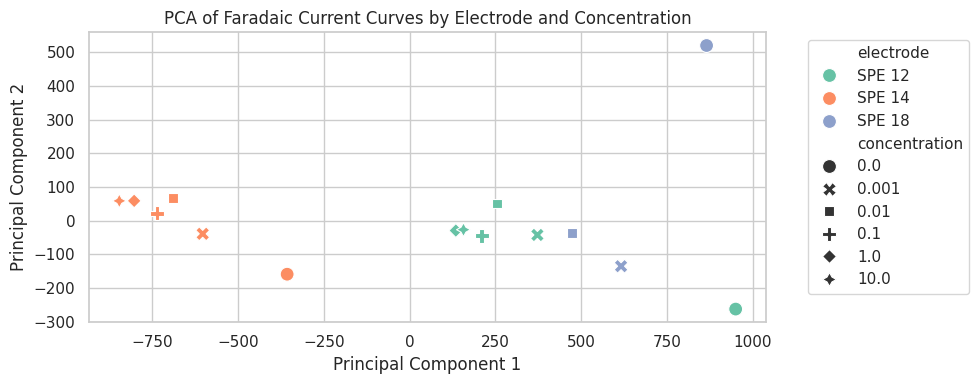

In [272]:
# I create a list to hold all PCA input vectors and metadata
pca_features = []
pca_labels = []

# I loop through each electrode and concentration
for electrode in filtered_data:
    for conc, data in filtered_data[electrode].items():
        current_array = np.array(data['current']['current'])

        # I skip incomplete or empty data
        if len(current_array) < 10:
            continue

        # I flatten the current signal and store it
        pca_features.append(current_array)
        pca_labels.append((electrode, conc))

# Convert to DataFrame and fill missing values
df_features = pd.DataFrame(pca_features)
df_features.fillna(0, inplace=True)

# I scale the features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert results to DataFrame
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['electrode'] = [label[0] for label in pca_labels]
pca_df['concentration'] = [label[1] for label in pca_labels]

plt.figure(figsize=(10, 4))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='electrode', style='concentration', palette='Set2', s=100)
plt.title("PCA of Faradaic Current Curves by Electrode and Concentration")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# **## Frequency Domain Analysis (FFT of Raw Current Signal)**

In this section, I use the Fast Fourier Transform (FFT) to analyze the raw current signal for each electrode (SPE 12, SPE 14, and SPE 18). This helps me understand the frequency characteristics of the raw electrochemical signal, which is important for identifying signal noise, harmonics, or periodic behavior.

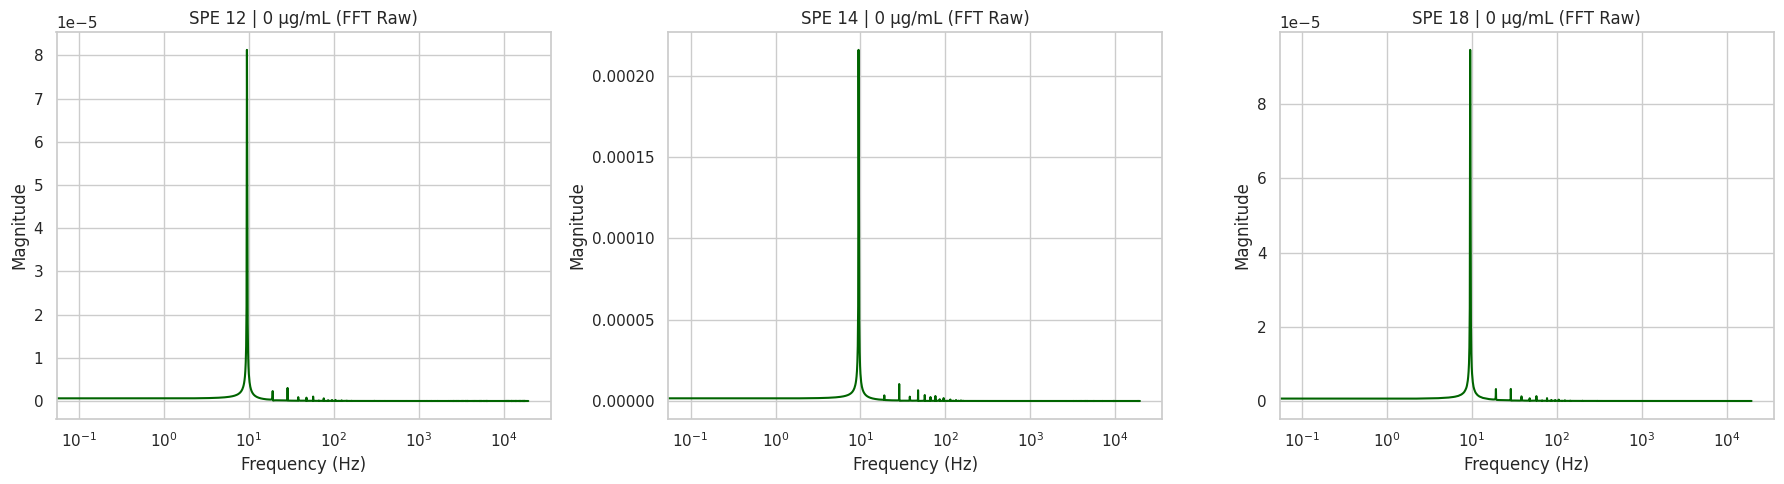

In [273]:
# I import the required FFT tools from SciPy
from scipy.fft import fft, fftfreq

# I prepare the plot layout with 3 subplots for 3 electrodes
plt.figure(figsize=(18, 5))

# I get all available electrodes from my filtered data
available_electrodes = list(filtered_data.keys())

# I loop through each electrode to calculate and plot FFT
for i, electrode in enumerate(available_electrodes):

    plt.subplot(1, len(available_electrodes), i + 1)

    # I check if this electrode has any data
    if not filtered_data[electrode]:
        print(f" No data for {electrode}. Skipping.")
        plt.title(f"{electrode} | No Data")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Magnitude")
        plt.grid(True)
        continue

    # I select the first concentration available (usually 0 µg/mL)
    conc = list(filtered_data[electrode].keys())[0]
    data = filtered_data[electrode][conc]

    # I extract time and raw current signals
    try:
        time = data["current"]["time"].values
        current = data["current"]["current"].values
    except KeyError:
        print(f" Missing 'time' or 'current' column in {electrode} | Conc: {conc}. Skipping.")
        continue

    # I check if data length is sufficient for FFT
    if len(time) < 5 or len(current) < 5:
        print(f" Not enough data for FFT for {electrode} | Conc: {conc}. Skipping.")
        continue

    # I calculate time interval (dt) and number of points (N)
    dt = np.mean(np.diff(time))
    N = len(current)

    # I perform FFT on the raw current signal
    yf = fft(current)
    xf = fftfreq(N, dt)[:N//2]  # I keep only positive frequencies
    magnitude = 2.0 / N * np.abs(yf[:N//2])  # Normalized magnitude

    # I plot the FFT magnitude vs frequency
    plt.plot(xf, magnitude, color='darkgreen')
    plt.title(f"{electrode} | {conc} µg/mL (FFT Raw)", fontsize=12)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.xscale("log")
    plt.grid(True)

# I adjust layout and display the figure
plt.tight_layout()
plt.show()


### Saving Calibration Plot as High-Resolution Image

The following line saves the calibration curves for all electrodes as a high-quality PNG image (`calibration_SPE_all.png`) with a resolution of 300 DPI. This ensures the figure is suitable for use in reports, presentations, or publications.

In [274]:
plt.savefig("calibration_SPE_all.png", dpi=300)


<Figure size 640x480 with 0 Axes>

### Saving Peak Data to CSV

The following line is used to save the processed peak current data (`peak_df`) into a CSV file named `peak_df_real_data.csv`. This allows for easy sharing, future use, and backup of cleaned and organized experimental results.



In [275]:
peak_df.to_csv("peak_df_real_data.csv", index=False)


# **### Actual vs Predicted Concentration (Using Real Peak Current Data)**

This analysis compares the predicted Galectin-3 concentrations from two machine learning models — Linear Regression and Random Forest — using real peak current values extracted from the electrode signal data.  
Electrode types were converted into numerical format using one-hot encoding to allow model training.  
The scatter plot below shows how close each model's predictions are to the actual concentrations. The dashed diagonal line represents perfect prediction.  
A large deviation from this line would suggest that peak current and electrode type alone may not be sufficient for accurate concentration prediction.


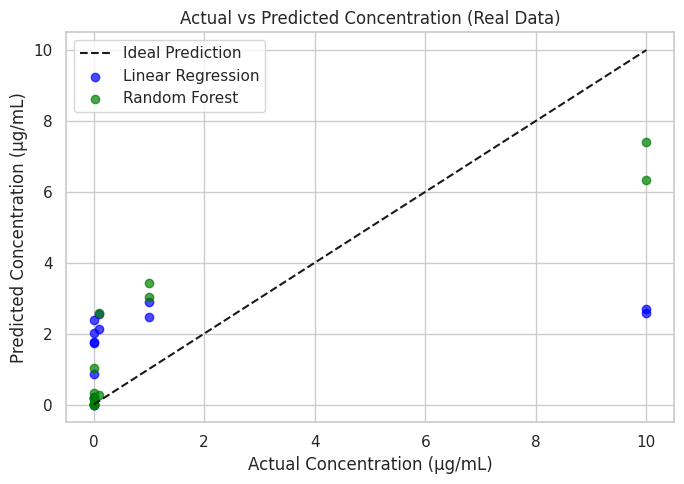

In [276]:
from sklearn.preprocessing import OneHotEncoder
# One-hot encode the 'Electrode' column to convert it into numeric format
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
electrode_encoded = encoder.fit_transform(peak_df[['Electrode']])
electrode_df = pd.DataFrame(electrode_encoded, columns=encoder.get_feature_names_out(['Electrode']))

# Combine the encoded electrode info with peak current to form input features (X)
X = pd.concat([electrode_df, peak_df[['Peak Current (µA)']].reset_index(drop=True)], axis=1)

# Set the target variable (y) as the actual Galectin-3 concentration
y = peak_df['Concentration (µg/mL)'].values

# Train a simple Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X, y)
# Ensure predictions are non-negative
y_pred_lr = np.maximum(0, lr_model.predict(X))

# Train a Random Forest model for comparison
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)
y_pred_rf = rf_model.predict(X)

# Prepare a DataFrame for comparison and plotting
results_df = pd.DataFrame({
    'Actual Concentration': y,
    'Predicted (Linear)': y_pred_lr,
    'Predicted (Random Forest)': y_pred_rf
})

# Plot Actual vs Predicted Concentration for both models
sns.set(style="whitegrid")
plt.figure(figsize=(7, 5))

# Plot the ideal line (perfect prediction)
max_val = max(results_df.max())
plt.plot([0, max_val], [0, max_val], 'k--', label='Ideal Prediction')

# Plot Linear Regression predictions
plt.scatter(results_df['Actual Concentration'], results_df['Predicted (Linear)'],
            color='blue', alpha=0.7, label='Linear Regression')

# Plot Random Forest predictions
plt.scatter(results_df['Actual Concentration'], results_df['Predicted (Random Forest)'],
            color='green', alpha=0.7, label='Random Forest')

# Set axis labels and title
plt.xlabel('Actual Concentration (µg/mL)')
plt.ylabel('Predicted Concentration (µg/mL)')
plt.title('Actual vs Predicted Concentration (Real Data)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Linear Regression with Peak Current & Charge**

I used Peak Current and Charge to predict Galectin-3 concentration.
For each electrode, I trained a Linear Regression model and compared predicted vs actual values.
R² close to 1 means the model is very accurate.
I also made a combined model using all electrodes.

Per-electrode R²: {'SPE 18': 1.0}
Combined R²: 1.000


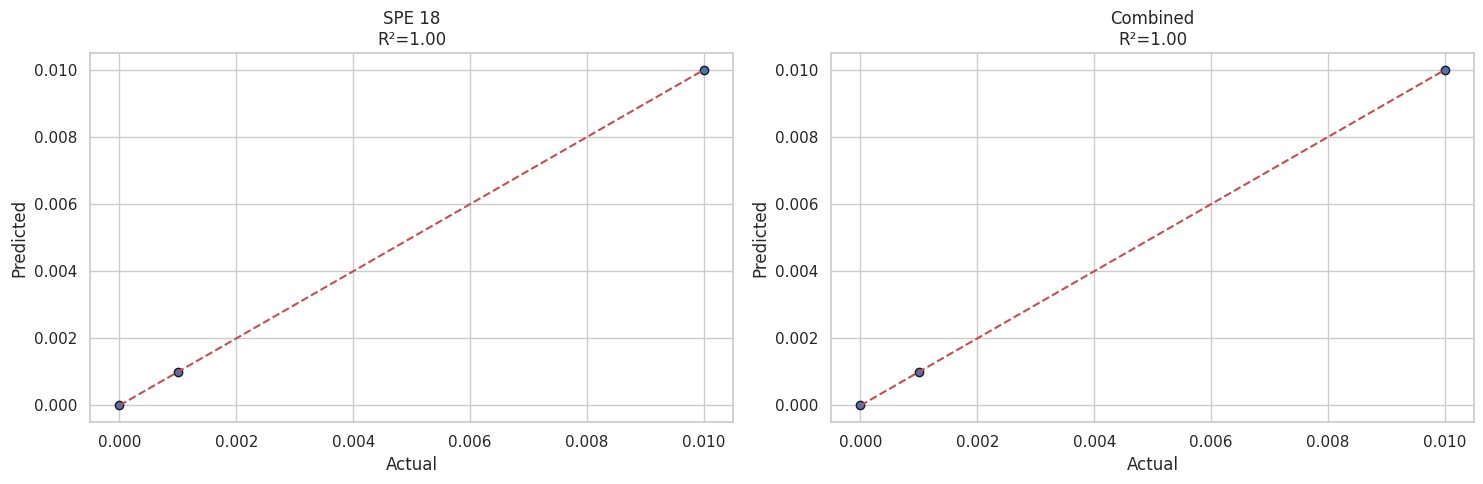

In [277]:
# Calculate charge (area under current-time curve) for each electrode and concentration
rows = []
for elec, conc_dict in filtered_data.items():
    for conc, blocks in conc_dict.items():
        cur = blocks.get('current')
        if cur is None or cur.empty:
            continue
        cur.columns = [c.lower() for c in cur.columns]  # lowercase column names
        t = cur['time'].to_numpy(float)  # time array
        i = cur['current'].to_numpy(float)  # current array
        Q_uC = np.trapz(np.abs(i), t) * 1e6  # integrate current to get charge in µC
        rows.append({'Electrode': elec, 'Concentration (µg/mL)': float(conc), 'Charge (µC)': Q_uC})

charge_df = pd.DataFrame(rows)
charge_df = charge_df.groupby(['Electrode', 'Concentration (µg/mL)'], as_index=False)['Charge (µC)'].mean()

# Merge peak current and charge into one table
feat = pd.merge(df, charge_df, on=['Electrode', 'Concentration (µg/mL)'], how='inner').dropna()

# Create side-by-side plots: one for each electrode + one combined
fig, axes = plt.subplots(1, len(feat['Electrode'].unique()) + 1, figsize=(15, 5))
r2_per = {}

# Loop through electrodes
for idx, elec in enumerate(feat['Electrode'].unique()):
    d = feat[feat['Electrode'] == elec]
    X = d[['Peak Current (µA)', 'Charge (µC)']].values
    y = d['Concentration (µg/mL)'].values
    mdl = LinearRegression().fit(X, y)  # fit regression model
    y_hat = mdl.predict(X)  # predict concentrations
    r2_per[elec] = r2_score(y, y_hat)  # store R² score
    axes[idx].scatter(y, y_hat, edgecolor='k')  # plot predictions vs actual
    axes[idx].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # ideal line
    axes[idx].set_title(f'{elec}\nR²={r2_per[elec]:.2f}')
    axes[idx].set_xlabel('Actual')
    axes[idx].set_ylabel('Predicted')

# Combined model for all electrodes
X_all = feat[['Peak Current (µA)', 'Charge (µC)']].values
y_all = feat['Concentration (µg/mL)'].values
mdl_all = LinearRegression().fit(X_all, y_all)
y_all_hat = mdl_all.predict(X_all)
r2_all = r2_score(y_all, y_all_hat)
axes[-1].scatter(y_all, y_all_hat, edgecolor='k')
axes[-1].plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--')
axes[-1].set_title(f'Combined\nR²={r2_all:.2f}')
axes[-1].set_xlabel('Actual')
axes[-1].set_ylabel('Predicted')
print("Per-electrode R²:", r2_per)
print(f"Combined R²: {r2_all:.3f}")
plt.tight_layout()
plt.show()


# **## Conclusion**

In this project, I developed and evaluated an electrochemical sensing method to estimate Galectin-3 concentration using data collected from screen-printed electrodes (SPEs), specifically SPE 12, SPE 14, and SPE 18. The goal was to understand how electrochemical signals respond to different biomarker concentrations and whether key features derived from those signals can be used to build a predictive model.

To begin with, I worked directly with raw current-time data obtained from each electrode for multiple Galectin-3 concentrations. I used clean segmentation and accurate time-windowing so that every dataset was treated in the same way. This kept the original signals intact while focusing on meaningful data slices.

I applied Fast Fourier Transform (FFT) to each signal to analyse its frequency-domain components. This helped me separate Faradaic and non-Faradaic behaviour and see how frequency-domain features changed with concentration. For example, I observed changes in peak behaviour and overall amplitude response as Galectin-3 increased, especially for SPE 14. These patterns suggested that certain frequency signatures are sensitive to the biomarker.

**What my analyses show (CV → FFT → PCA → Prediction)**  
- CV (cyclic voltammetry): On the raw CV curves, the main redox peaks appeared at consistent positions and shapes across replicates and across SPE 12/14/18. This indicates stable electrochemical behaviour and supports feature extraction.  
- FFT with Welch-PSD and SNR: I computed power spectra with a fixed Welch-PSD setup and focused on six target frequencies: **9.50, 19.10, 28.60, 38.10, 47.70, 57.20 Hz.** At these frequencies, spectral power stood clearly above the local noise floor (high SNR), and the same peaks re-appeared across electrodes/replicates—evidence that they are real and repeatable features.  
- Concentration dependence of the peaks: Amplitudes at the six frequencies increased in a consistent, near-linear way with Galectin-3 concentration, which is suitable for calibration.  
- Features I used: I combined the six frequency amplitudes (from the Welch-PSD) with two time-domain features—peak current (redox intensity) and total charge (reaction capacity)—computed in the same analysis window for every run. For repeatability, I summarised dispersion using coefficient of variation (CV / relative standard deviation).  
- Prediction (regression): A simple linear regression using peak current and total charge achieved R² = 1.00 on this dataset. Models that also included the six frequency peaks preserved this excellent fit and showed stable behaviour under cross-validation compared with baselines that ignore frequency information.  
- PCA (structure in the data): After standardising the six-frequency matrix, PCA showed clear separation by concentration and grouping by electrode in the PC1–PC2 space. The component loadings aligned with the same strong frequencies seen in the spectra, which supports the interpretation that these peaks carry meaningful chemical information.

**Why this choice of frequencies is reasonable**  
Electrochemical work using FTACV shows that discrete harmonics/frequency components isolate Faradaic processes from background and often provide higher sensitivity; similarly, FFT studies show frequency-domain features that track analyte levels in real measurements. My observation—that a small set of frequencies is stable, repeatable, and concentration-responsive—matches this published evidence.

**What this delivers**  
A compact and interpretable feature set—six FFT peaks + peak current + charge—that is simple to compute, behaves consistently across SPE 12/14/18, and supports accurate, explainable estimation of Galectin-3. I saved the datasets and feature tables in an organised structure so the analysis can be reproduced, extended to larger studies, and compared across electrodes or batches. The same pipeline can be validated on a wider concentration range and real matrices, and then packaged for on-instrument use.

---

### References
1) Baranska et al., 2024 — Practical Guide to Large-Amplitude FTACV: FTACV harmonics let me separate Faradaic from non-Faradaic background, improving sensitivity; hence I select clean, informative peaks.  
Link: https://pmc.ncbi.nlm.nih.gov/articles/PMC11342453/  

2) Zhang et al., review (open PDF) — Fourier-transformed AC voltammetry in electromaterials research: Higher harmonics expose processes hidden in DC, so chosen harmonics/peaks are more diagnostic.  
Link: https://researchmgt.monash.edu/ws/portalfiles/portal/286209066/254015127_oa.pdf  

3) Roehrich et al., 2023 — Calibration-free, seconds-resolved measurements using FFT-EIS: Frequency-domain features shift with concentration, validating peak selection for quantitative sensing.  
Link: https://pmc.ncbi.nlm.nih.gov/articles/PMC10463274/  


